# Slice NetCDFs [Distributed]

## Overview

> This notebook demonstrates how to open and explore the netCDF file, and slice it using Spark + Xarray. Data is sliced by time, latitude, and longitude attributes.

__Examples:__

<p/>

* Single File: slice example with flattening
* Distributed: slice examples with / without flattening

## Source Data

The source data is NOAA Global Precipitation [Data](https://downloads.psl.noaa.gov/Datasets/cpc_global_precip/); contains all years since 1979, each ~60MB.

## Prerequisites

Python 3 or later. Python modules: we will add 'h5netcdf', 'xarray', and 'cftime'; also will update 'scipy' version (numpy, pandas, matplotlib already available)

---
__Last Updated:__ 21 NOV 2023 [Mosaic 0.3.12]

## Setup

### Imports

In [0]:
%pip install h5netcdf cftime xarray scipy --quiet
%pip install databricks-mosaic --quiet

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
#  - choose option-1 or option-2 below, essential for REPARTITION!
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management

# -- import databricks + spark functions

from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# -- other imports
import io
import json
import os
import pandas as pd
import xarray as xr

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




### Data

> Adjust `nc_dir` to your preferred fuse rawPath. _For simplicity, we are going to use DBFS, but this is all shifting with Unity Catalog [more [here](https://docs.databricks.com/en/dbfs/unity-catalog.html)]._ __Note: [DBFS](https://docs.databricks.com/en/dbfs/dbfs-root.html), [Workspace Files](https://docs.databricks.com/en/files/workspace.html), and [most recent] [Volumes](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#volumes), are FUSE mounted to the cluster nodes, looking like a local rawPath.__

In [0]:
nc_dir = '/home/mjohns@databricks.com/geospatial/netcdf-precip'
nc_dir_fuse = f'/dbfs{nc_dir}'
os.makedirs(nc_dir_fuse, exist_ok=True)

nc_sample_path = f'{nc_dir}/precip.2023.nc'
nc_sample_path_fuse = f'/dbfs{nc_sample_path}'

os.environ['NC_DIR_FUSE'] = nc_dir_fuse
os.environ['NC_SAMPLE_PATH_FUSE'] = nc_sample_path_fuse
os.environ['NC_SAMPLE_FILE'] = 'precip.2023.nc'

In [0]:
os.rawPath.isfile('test.txt')

Out[3]: False

In [0]:
def download_url(url:str, out_path:str, debug_level:int = 0):
  """
  Download URL to out rawPath
  """
  import os
  import requests

  if os.rawPath.exists(out_path):
    debug_level > 0 and print(f"...skipping existing '{out_path}'")
  else:
    r = requests.get(url) # create HTTP response object
    with open(out_path,'wb') as f:
      f.write(r.content)

In [0]:
# single year sample
year = "2023"
download_url(
  f"https://downloads.psl.noaa.gov/Datasets/cpc_global_precip/precip.{year}.nc", 
  f"{nc_dir_fuse}/precip.{year}.nc", 
  debug_level=1
)

...skipping existing '/dbfs/home/mjohns@databricks.com/geospatial/netcdf-precip/precip.2023.nc'


In [0]:
# - you can adjust the range to avoid so many files
# - reminder: range is not inclusive, so this is through 2022 as-is
for year in range(1979,2023):
  download_url(f"https://downloads.psl.noaa.gov/Datasets/cpc_global_precip/precip.{year}.nc", f"{nc_dir_fuse}/precip.{year}.nc")

In [0]:
%sh
# avoid list all files
ls -lh $NC_DIR_FUSE | head -5
echo "..."
ls -lh $NC_DIR_FUSE | tail -5

total 2.6G
-rwxrwxrwx 1 root root 61M Nov 21 19:00 precip.1979.nc
-rwxrwxrwx 1 root root 63M Nov 21 19:00 precip.1980.nc
-rwxrwxrwx 1 root root 64M Nov 21 19:00 precip.1981.nc
-rwxrwxrwx 1 root root 62M Nov 21 19:00 precip.1982.nc
...
-rwxrwxrwx 1 root root 58M Nov 21 19:02 precip.2019.nc
-rwxrwxrwx 1 root root 57M Nov 21 19:02 precip.2020.nc
-rwxrwxrwx 1 root root 58M Nov 21 19:02 precip.2021.nc
-rwxrwxrwx 1 root root 64M Nov 21 19:02 precip.2022.nc
-rwxrwxrwx 1 root root 55M Nov 21 19:00 precip.2023.nc


### Helper Functions

> These are used a couple of places in the examples, have UDF version of each.

In [0]:
def from_360(lon):
  """
  Standardize from 0:360 to -180:180 degrees.
  - NetCDF does 0:360 for longitude
  - See https://itecnote.com/tecnote/python-change-longitude-from-180-to-180-to-0-to-360/
  """
  return ((lon - 180) % 360) - 180

@udf(returnType=DoubleType())
def from_360_udf(lon):
  return from_360(lon)

In [0]:
def from_180(lon):
  """
  Standardize from -180:180 to 0:360 degrees.
  - NetCDF does 0:360 for longitude
  - See https://itecnote.com/tecnote/python-change-longitude-from-180-to-180-to-0-to-360/
  """
  return lon % 360

@udf(returnType=DoubleType())
def from_180_udf(lon):
  return from_180(lon)

## Load Metadata [Spark]

> We start with the Mosaic reader to load our NetCDFs, all 45 in this case. Loading results in various metadata about the NetCDFs.

In [0]:
df_mos = (
  spark
    .read.format("gdal")
      .option("driverName", "NetCDF")
    .load(nc_dir)
)
print(f"count? {df_mos.count():,}")
df_mos.orderBy(F.desc("rawPath")).limit(5).display() # <- limiting display for ipynb output only

count? 45


rawPath modificationTime length uuid x_size y_size bandCount metadata subdatasets srid tile dbfs:/home/mjohns@databricks.com/geospatial/netcdf-precip/precip.2023.nc 1970-01-20T16:23:13.201+0000 57443346 -7234899442207905050 720 360 323 Map(NC_GLOBAL#dataset_title -> CPC GLOBAL PRCP V1.0, precip#long_name -> Daily total of precipitation, time#delta_t -> 0000-00-01 00:00:00, time#long_name -> Time, lat#units -> degrees_north, NETCDF_DIM_time_VALUES -> {1078200,1078224,1078248,1078272,1078296,1078320,1078344,1078368,1078392,1078416,1078440,1078464,1078488,1078512,1078536,1078560,1078584,1078608,1078632,1078656,1078680,1078704,1078728,1078752,1078776,1078800,1078824,1078848,1078872,1078896,1078920,1078944,1078968,1078992,1079016,1079040,1079064,1079088,1079112,1079136,1079160,1079184,1079208,1079232,1079256,1079280,1079304,1079328,1079352,1079376,1079400,1079424,1079448,1079472,1079496,1079520,1079544,1079568,1079592,1079616,1079640,1079664,1079688,1079712,1079736,1079760,1079784,1079808,1079832,1079856,1079880,1079904,1079928,1079952,1079976,1080000,1080024,1080048,1080072,1080096,1080120,1080144,1080168,1080192,1080216,1080240,1080264,1080288,1080312,1080336,1080360,1080384,1080408,1080432,1080456,1080480,1080504,1080528,1080552,1080576,1080600,1080624,1080648,1080672,1080696,1080720,1080744,1080768,1080792,1080816,1080840,1080864,1080888,1080912,1080936,1080960,1080984,1081008,1081032,1081056,1081080,1081104,1081128,1081152,1081176,1081200,1081224,1081248,1081272,1081296,1081320,1081344,1081368,1081392,1081416,1081440,1081464,1081488,1081512,1081536,1081560,1081584,1081608,1081632,1081656,1081680,1081704,1081728,1081752,1081776,1081800,1081824,1081848,1081872,1081896,1081920,1081944,1081968,1081992,1082016,1082040,1082064,1082088,1082112,1082136,1082160,1082184,1082208,1082232,1082256,1082280,1082304,1082328,1082352,1082376,1082400,1082424,1082448,1082472,1082496,1082520,1082544,1082568,1082592,1082616,1082640,1082664,1082688,1082712,1082736,1082760,1082784,1082808,1082832,1082856,1082880,1082904,1082928,1082952,1082976,1083000,1083024,1083048,1083072,1083096,1083120,1083144,1083168,1083192,1083216,1083240,1083264,1083288,1083312,1083336,1083360,1083384,1083408,1083432,1083456,1083480,1083504,1083528,1083552,1083576,1083600,1083624,1083648,1083672,1083696,1083720,1083744,1083768,1083792,1083816,1083840,1083864,1083888,1083912,1083936,1083960,1083984,1084008,1084032,1084056,1084080,1084104,1084128,1084152,1084176,1084200,1084224,1084248,1084272,1084296,1084320,1084344,1084368,1084392,1084416,1084440,1084464,1084488,1084512,1084536,1084560,1084584,1084608,1084632,1084656,1084680,1084704,1084728,1084752,1084776,1084800,1084824,1084848,1084872,1084896,1084920,1084944,1084968,1084992,1085016,1085040,1085064,1085088,1085112,1085136,1085160,1085184,1085208,1085232,1085256,1085280,1085304,1085328,1085352,1085376,1085400,1085424,1085448,1085472,1085496,1085520,1085544,1085568,1085592,1085616,1085640,1085664,1085688,1085712,1085736,1085760,1085784,1085808,1085832,1085856,1085880,1085904,1085928}, time#axis -> T, precip#avg_period -> 0000-00-01 00:00:00, NC_GLOBAL#References -> https://www.psl.noaa.gov/data/gridded/data.cpc.globalprecip.html, lat#standard_name -> latitude, lat#actual_range -> {89.75,-89.75}, time#coordinate_defines -> start, NETCDF_DIM_EXTRA -> {time}, DERIVED_SUBDATASET_1_NAME -> DERIVED_SUBDATASET:LOGAMPLITUDE:/vsimem/6835514557054555330.nc, precip#cell_methods -> time: sum, lon#axis -> X, lon#standard_name -> longitude, NC_GLOBAL#title -> CPC GLOBAL PRCP V1.0 RT, precip#actual_range -> {0,776.75}, lon#long_name -> Longitude, lat#axis -> Y, NC_GLOBAL#version -> V1.0, NC_GLOBAL#Source -> ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/, lon#units -> degrees_east, precip#statistic -> Total, time#units -> hours since 1900-01-01 00:00:00, NETCDF_DIM_time_DEF -> {323,6}, lon#actual_range -> {0.25,359.75}, precip#var_desc -> Precipitation, DERIVED_SUBDATASET_1_DESC -> log10 of amplitude of input bands from /vsimem/68355145570

## Slice Example-1: Single File [with Flattening]

> Before we move to distributed with Xarray, let's consider what slicing a single file might look like.

_Read XArray Dataset_

In [0]:
xds = xr.open_dataset(nc_sample_path_fuse)
xds

<xarray.Dataset>
Dimensions: (lat: 360, lon: 720, time: 323)
Coordinates:
 * lat (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
 * lon (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 * time (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-19
Data variables:
 precip (time, lat, lon) float32 ...
Attributes:
 Conventions: CF-1.0
 version: V1.0
 title: CPC GLOBAL PRCP V1.0 RT
 References: https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...
 dataset_title: CPC GLOBAL PRCP V1.0
 Source: ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
 history: Updated 2023-11-20 23:31:01 xarray.Dataset Dimensions: lat : 360 lon : 720 time : 323 Coordinates: (3) lat (lat) float32 89.75 89.25 88.75 ... -89.25 -89.75 actual_range : [ 89.75 -89.75] long_name : Latitude units : degrees_north axis : Y standard_name : latitude coordinate_defines : center array([ 89.75, 89.25, 88.75, ..., -88.75, -89.25, -89.75], dtype=float32) lon (lon) float32 0.25 0.75 1.25 ... 359.2 359.8 long_name : Longitude units : degrees_east axis : X standard_name : longitude actual_range : [2.5000e-01 3.5975e+02] coordinate_defines : center array([2.5000e-01, 7.5000e-01, 1.2500e+00, ..., 3.5875e+02, 3.5925e+02,
 3.5975e+02], dtype=float32) time (time) datetime64[ns] 2023-01-01 ... 2023-11-19 long_name : Time axis : T standard_name : time coordinate_defines : start delta_t : 0000-00-01 00:00:00 avg_period : 0000-00-01 00:00:00 actual_range : [1085832. 1085928.] array(['2023-01-01T00:00:00.000000000', '2023-01-02T00:00:00.000000000',
 '2023-01-03T00:00:00.000000000', ..., '2023-11-17T00:00:00.000000000',
 '2023-11-18T00:00:00.000000000', '2023-11-19T00:00:00.000000000'],
 dtype='datetime64[ns]') Data variables: (1) precip (time, lat, lon) float32 ... units : mm var_desc : Precipitation level_desc : Surface statistic : Total parent_stat : Other long_name : Daily total of precipitation cell_methods : time: sum valid_range : [ 0. 1000.] avg_period : 0000-00-01 00:00:00 actual_range : [ 0. 776.75] dataset : CPC Global Precipitation [83721600 values with dtype=float32] Indexes: (3) lat PandasIndex PandasIndex(Float64Index([ 89.75, 89.25, 88.75, 88.25, 87.75, 87.25, 86.75, 86.25,
 85.75, 85.25,
 ...
 -85.25, -85.75, -86.25, -86.75, -87.25, -87.75, -88.25, -88.75,
 -89.25, -89.75],
 dtype='float64', name='lat', length=360)) lon PandasIndex PandasIndex(Float64Index([ 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75,
 4.25, 4.75,
 ...
 355.25, 355.75, 356.25, 356.75, 357.25, 357.75, 358.25, 358.75,
 359.25, 359.75],
 dtype='float64', name='lon', length=720)) time PandasIndex PandasIndex(DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
 '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
 '2023-01-09', '2023-01-10',
 ...
 '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
 '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
 '2023-11-18', '2023-11-19'],
 dtype='datetime64[ns]', name='time', length=323, freq=None)) Attributes: (7) Conventions : CF-1.0 version : V1.0 title : CPC GLOBAL PRCP V1.0 RT References : https://www.psl.noaa.gov/data/gridded/data.cpc.globalprecip.html dataset_title : CPC GLOBAL PRCP V1.0 Source : ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/ history : Updated 2023-11-20 23:31:01

_Slice Dataset_

In [0]:
xds.sel(time=slice('2023-01-01','2023-01-31'))

<xarray.Dataset>
Dimensions: (lat: 360, lon: 720, time: 31)
Coordinates:
 * lat (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
 * lon (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 * time (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-31
Data variables:
 precip (time, lat, lon) float32 ...
Attributes:
 Conventions: CF-1.0
 version: V1.0
 title: CPC GLOBAL PRCP V1.0 RT
 References: https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...
 dataset_title: CPC GLOBAL PRCP V1.0
 Source: ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
 history: Updated 2023-11-20 23:31:01 xarray.Dataset Dimensions: lat : 360 lon : 720 time : 31 Coordinates: (3) lat (lat) float32 89.75 89.25 88.75 ... -89.25 -89.75 actual_range : [ 89.75 -89.75] long_name : Latitude units : degrees_north axis : Y standard_name : latitude coordinate_defines : center array([ 89.75, 89.25, 88.75, ..., -88.75, -89.25, -89.75], dtype=float32) lon (lon) float32 0.25 0.75 1.25 ... 359.2 359.8 long_name : Longitude units : degrees_east axis : X standard_name : longitude actual_range : [2.5000e-01 3.5975e+02] coordinate_defines : center array([2.5000e-01, 7.5000e-01, 1.2500e+00, ..., 3.5875e+02, 3.5925e+02,
 3.5975e+02], dtype=float32) time (time) datetime64[ns] 2023-01-01 ... 2023-01-31 long_name : Time axis : T standard_name : time coordinate_defines : start delta_t : 0000-00-01 00:00:00 avg_period : 0000-00-01 00:00:00 actual_range : [1085832. 1085928.] array(['2023-01-01T00:00:00.000000000', '2023-01-02T00:00:00.000000000',
 '2023-01-03T00:00:00.000000000', '2023-01-04T00:00:00.000000000',
 '2023-01-05T00:00:00.000000000', '2023-01-06T00:00:00.000000000',
 '2023-01-07T00:00:00.000000000', '2023-01-08T00:00:00.000000000',
 '2023-01-09T00:00:00.000000000', '2023-01-10T00:00:00.000000000',
 '2023-01-11T00:00:00.000000000', '2023-01-12T00:00:00.000000000',
 '2023-01-13T00:00:00.000000000', '2023-01-14T00:00:00.000000000',
 '2023-01-15T00:00:00.000000000', '2023-01-16T00:00:00.000000000',
 '2023-01-17T00:00:00.000000000', '2023-01-18T00:00:00.000000000',
 '2023-01-19T00:00:00.000000000', '2023-01-20T00:00:00.000000000',
 '2023-01-21T00:00:00.000000000', '2023-01-22T00:00:00.000000000',
 '2023-01-23T00:00:00.000000000', '2023-01-24T00:00:00.000000000',
 '2023-01-25T00:00:00.000000000', '2023-01-26T00:00:00.000000000',
 '2023-01-27T00:00:00.000000000', '2023-01-28T00:00:00.000000000',
 '2023-01-29T00:00:00.000000000', '2023-01-30T00:00:00.000000000',
 '2023-01-31T00:00:00.000000000'], dtype='datetime64[ns]') Data variables: (1) precip (time, lat, lon) float32 ... units : mm var_desc : Precipitation level_desc : Surface statistic : Total parent_stat : Other long_name : Daily total of precipitation cell_methods : time: sum valid_range : [ 0. 1000.] avg_period : 0000-00-01 00:00:00 actual_range : [ 0. 776.75] dataset : CPC Global Precipitation [8035200 values with dtype=float32] Indexes: (3) lat PandasIndex PandasIndex(Float64Index([ 89.75, 89.25, 88.75, 88.25, 87.75, 87.25, 86.75, 86.25,
 85.75, 85.25,
 ...
 -85.25, -85.75, -86.25, -86.75, -87.25, -87.75, -88.25, -88.75,
 -89.25, -89.75],
 dtype='float64', name='lat', length=360)) lon PandasIndex PandasIndex(Float64Index([ 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75,
 4.25, 4.75,
 ...
 355.25, 355.75, 356.25, 356.75, 357.25, 357.75, 358.25, 358.75,
 359.25, 359.75],
 dtype='float64', name='lon', length=720)) time PandasIndex PandasIndex(DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
 '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
 '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
 '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
 '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
 '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
 '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
 '2023-01-29', '2023-01-30', '2023-01-31'],
 dtype='datetime64[ns]', name='time', freq=None)) Attributes: (7) Conventions : CF-1.0 version

In [0]:
xds.sel(lat=slice(89.0,88.0), lon=slice(0.25,0.75))

<xarray.Dataset>
Dimensions: (lat: 2, lon: 2, time: 323)
Coordinates:
 * lat (lat) float32 88.75 88.25
 * lon (lon) float32 0.25 0.75
 * time (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-19
Data variables:
 precip (time, lat, lon) float32 ...
Attributes:
 Conventions: CF-1.0
 version: V1.0
 title: CPC GLOBAL PRCP V1.0 RT
 References: https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...
 dataset_title: CPC GLOBAL PRCP V1.0
 Source: ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
 history: Updated 2023-11-20 23:31:01 xarray.Dataset Dimensions: lat : 2 lon : 2 time : 323 Coordinates: (3) lat (lat) float32 88.75 88.25 actual_range : [ 89.75 -89.75] long_name : Latitude units : degrees_north axis : Y standard_name : latitude coordinate_defines : center array([88.75, 88.25], dtype=float32) lon (lon) float32 0.25 0.75 long_name : Longitude units : degrees_east axis : X standard_name : longitude actual_range : [2.5000e-01 3.5975e+02] coordinate_defines : center array([0.25, 0.75], dtype=float32) time (time) datetime64[ns] 2023-01-01 ... 2023-11-19 long_name : Time axis : T standard_name : time coordinate_defines : start delta_t : 0000-00-01 00:00:00 avg_period : 0000-00-01 00:00:00 actual_range : [1085832. 1085928.] array(['2023-01-01T00:00:00.000000000', '2023-01-02T00:00:00.000000000',
 '2023-01-03T00:00:00.000000000', ..., '2023-11-17T00:00:00.000000000',
 '2023-11-18T00:00:00.000000000', '2023-11-19T00:00:00.000000000'],
 dtype='datetime64[ns]') Data variables: (1) precip (time, lat, lon) float32 ... units : mm var_desc : Precipitation level_desc : Surface statistic : Total parent_stat : Other long_name : Daily total of precipitation cell_methods : time: sum valid_range : [ 0. 1000.] avg_period : 0000-00-01 00:00:00 actual_range : [ 0. 776.75] dataset : CPC Global Precipitation [1292 values with dtype=float32] Indexes: (3) lat PandasIndex PandasIndex(Float64Index([88.75, 88.25], dtype='float64', name='lat')) lon PandasIndex PandasIndex(Float64Index([0.25, 0.75], dtype='float64', name='lon')) time PandasIndex PandasIndex(DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
 '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
 '2023-01-09', '2023-01-10',
 ...
 '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13',
 '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
 '2023-11-18', '2023-11-19'],
 dtype='datetime64[ns]', name='time', length=323, freq=None)) Attributes: (7) Conventions : CF-1.0 version : V1.0 title : CPC GLOBAL PRCP V1.0 RT References : https://www.psl.noaa.gov/data/gridded/data.cpc.globalprecip.html dataset_title : CPC GLOBAL PRCP V1.0 Source : ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/ history : Updated 2023-11-20 23:31:01

_Convert to Pandas & Flatten_

In [0]:
if 'time' in xds.dims.keys() and not isinstance(xds.indexes['time'], pd.DatetimeIndex):
    xds['time'] = xds.indexes['time'].to_datetimeindex()
pdf = xds.to_dataframe() # <- this is the right move (get a multi-index)
print(f'rows? {pdf.shape[0]:,}, cols? {pdf.shape[1]}')
pdf.head()

rows? 83,721,600, cols? 1


precip 
 
 
 lat 
 lon 
 time 
 
 
 
 
 
 89.75 
 0.25 
 2023-01-01 
 NaN 
 
 
 2023-01-02 
 NaN 
 
 
 2023-01-03 
 NaN 
 
 
 2023-01-04 
 NaN 
 
 
 2023-01-05 
 NaN

In [0]:
pdf.dropna(inplace=True)
print(f'rows? {pdf.shape[0]:,}, cols? {pdf.shape[1]}')
pdf.head()

rows? 30,052,731, cols? 1


precip 
 
 
 lat 
 lon 
 time 
 
 
 
 
 
 83.75 
 323.25 
 2023-01-01 
 0.000000 
 
 
 2023-01-02 
 0.000000 
 
 
 2023-01-03 
 0.000000 
 
 
 2023-01-04 
 0.000000 
 
 
 2023-01-05 
 0.022191

In [0]:
pdf_flat = pdf.reset_index()
print(f'rows? {pdf_flat.shape[0]:,}, cols? {pdf_flat.shape[1]}')
pdf_flat.head()

rows? 30,052,731, cols? 4


,lat,lon,time,precip
0,83.75,323.25,2023-01-01,0.000000
1,83.75,323.25,2023-01-02,0.000000
2,83.75,323.25,2023-01-03,0.000000
3,83.75,323.25,2023-01-04,0.000000
4,83.75,323.25,2023-01-05,0.022191


_Get the [spark] schema from the flattened [pandas] sample_

> This will be used in our distributed execution (below).

In [0]:
df = spark.createDataFrame(pdf_flat)
print(f"count? {df.count():,}")
df.limit(5).display()

count? 30,052,731


lat,lon,time,precip
83.75,323.25,2023-01-01T00:00:00.000+0000,0.0
83.75,323.25,2023-01-02T00:00:00.000+0000,0.0
83.75,323.25,2023-01-03T00:00:00.000+0000,0.0
83.75,323.25,2023-01-04T00:00:00.000+0000,0.0
83.75,323.25,2023-01-05T00:00:00.000+0000,0.022190852


In [0]:
df.schema

Out[18]: StructType([StructField('lat', DoubleType(), True), StructField('lon', DoubleType(), True), StructField('time', TimestampType(), True), StructField('precip', FloatType(), True)])

## Slice Example-2: Vectorized UDF [with Flattening]

> Use `applyInPandas` UDF to work more directly with the netCDF [outside of Moasaic + GDAL]. __Note: Will enforce grouping by rawPath.__

In [0]:
# idenfified earlier in sample
flat_schema = (
  StructType(
    [
      StructField('lon', DoubleType(), True), 
      StructField('lat', DoubleType(), True), 
      StructField('time', TimestampType(), True), 
      StructField('precip', FloatType(), True), 
    ]
  )
)
flat_schema

Out[11]: StructType([StructField('lon', DoubleType(), True), StructField('lat', DoubleType(), True), StructField('time', TimestampType(), True), StructField('precip', FloatType(), True)])

In [0]:
def slice_flatten_path(key, input_pdf: pd.DataFrame) -> pd.DataFrame:
  """
  slice the `rawPath` column [optimal w/single rawPath]:
   - based on provided time, lat, lon slices
   - Read with XArray using h5netcdf engine
   - Handles conversion to pandas
   - flattens out multi-dimensions
   - drops na values (much smaller)
  Returns pandas dataframe
  """
  import io
  import pandas as pd
  import xarray as xr 

  # -- iterate over pdf --
  #  - this may just be 1 rawPath,
  #    depends on groupBy
  #  - to further optimize, consider enforcing 1 rawPath
  #    and not doing the `pd.concat` call, just returning 
  pdf_arr = []
  for index, row in input_pdf.iterrows():
    path_fuse = row['rawPath'].replace("dbfs:","/dbfs")
    xds = xr.open_dataset(path_fuse)

    xds_slice = xds
    if 'time_slice' in input_pdf:
      xds_slice = xds_slice.sel(time=slice(*row['time_slice']))
    if 'lat_slice' in input_pdf:
      xds_slice = xds_slice.sel(lat=slice(*row['lat_slice']))
    if 'lon_slice' in input_pdf:
      xds_slice = xds_slice.sel(lon=slice(*row['lon_slice']))
    
    if 'time' in xds_slice.dims.keys() and not isinstance(xds_slice.indexes['time'], pd.DatetimeIndex):
      xds_slice['time'] = xds_slice.indexes['time'].to_datetimeindex()
    pdf = xds_slice.to_dataframe() # <- handle drops in xdf for large files
    pdf.dropna(inplace=True)
    pdf_arr.append(pdf.reset_index())
  
  return pd.concat(pdf_arr)

In [0]:
from_180(-83.0) # <- becomes min

Out[13]: 277.0

In [0]:
from_180(-80.9) # <- becomes max

Out[14]: 279.1

In [0]:
spark.catalog.clearCache()                                                       # <- cache for dev, help avoid recomputes

df_path = (
  df_mos
    .repartition(df_mos.count(), "rawPath")                                         # <- repartition is important!
  .withColumn(
    "time_slice", 
    F.array([F.lit(x) for x in ['2023-01-01', '2023-01-31']])
  )
  .withColumn(
    "lat_slice", 
    F.array([F.lit(x) for x in [28.6, 26.9]])                                     # <- max, min
  )
  .withColumn(
    "lon_slice", 
    F.array([F.lit(x) for x in [from_180(-83.0), from_180(-80.9)]])               # <- min, max ... convert to 360 
  )
  .groupBy("rawPath")
    .applyInPandas(slice_flatten_path, schema=flat_schema)                        # <- applyInPandas UDF 
  .withColumn("year", F.year("time"))
  .withColumn("month", F.month("time"))
  .withColumn("day", F.dayofmonth("time"))
  .withColumn("geom_wkt", mos.st_astext(mos.st_point(from_360_udf("lon"), "lat"))) # <- convert to -180:180
  .cache()
)

print(f"count? {df_path.count():,}")
display(df_path.limit(5)) # <- limiting for ipynb only

count? 372


lon,lat,time,precip,year,month,day,geom_wkt
277.25,28.25,2023-01-01T00:00:00.000+0000,8.654497,2023,1,1,POINT (-82.75 28.25)
277.25,28.25,2023-01-02T00:00:00.000+0000,0.12019344,2023,1,2,POINT (-82.75 28.25)
277.25,28.25,2023-01-03T00:00:00.000+0000,0.0,2023,1,3,POINT (-82.75 28.25)
277.25,28.25,2023-01-04T00:00:00.000+0000,0.0,2023,1,4,POINT (-82.75 28.25)
277.25,28.25,2023-01-05T00:00:00.000+0000,6.124646,2023,1,5,POINT (-82.75 28.25)


_Render average precipitation through the years_

> This is per collected location __[our slice in Florida]__. Note: `precip` units are in millimeters.

In [0]:
df_kepler = (
  df_path
    .groupBy("geom_wkt")
  .agg(F.avg("precip").alias("avg_precip"))
)


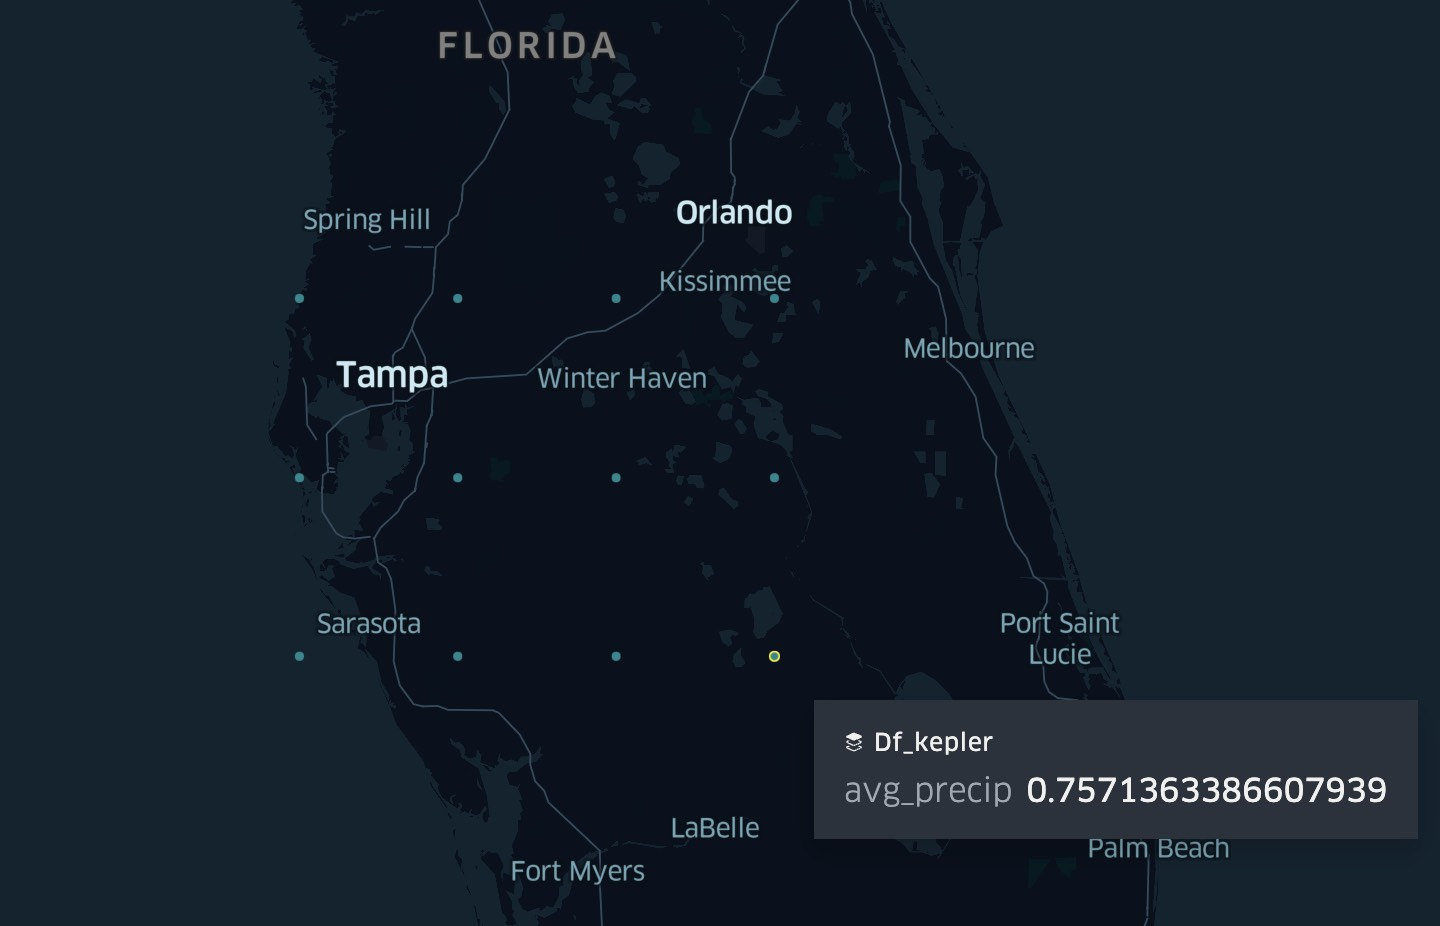

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABaCgAwAEAAAAAQAAA56kBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wAKAAUACQAbABBhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIA54FoAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAICAgICAgQCAgQGBAQEBggGBgYGCAoICAgICAoMCgoKCgoKDAwMDAwMDAwODg4ODg4RERERERMTExMTExMTExP/2wBDAQMDAwUEBQgEBAgUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/3QAEAFr/2gAMAwEAAhEDEQA/APx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKF7Z/alyxY7RwoIGT+Nc1cWFxaxiSUDB44PQ12lY2syOkICtw3BGMg/jSaLhJ3scxRRRSNmgooooCwUUU4qwAYjg9DQMbRV+10+a7jaSMgYOOe9W4rKGzj8/UQTuO0KO2e5osTdIxaK2DDo7OAsjfMfwH5jpVW4eyVgtqm4DqzE8/yoBPyKNFFFBQUUUUAFFFFABRRRQAUUUUAFX9L1CbStRh1G3+/C4Ye+Oo/EcVQooA6fxbp8NlqxuLL/j2u1E8J/wBl+cfgciuYrtrf/id+EJLU83Glt5qephc/OP8AgJ5+lcTTfcmPYKKKKRQUUUUAFFFFABRSgFiFUZJq+NKvjj5MfiP8aAbS3M+irN1aS2jhJccjPFVqATuFFFFAmwooooEFFFFABRRRQAUUUUAFFFFBVgooooE0FFFFAi1HcBLWS3bPzEEe2OtVaKKAWgUVKYZQnmYyvqOR+OOh9qioKuFFFFABRRRQAUUUAZ4FAE1vbz3c6W1speSQhVUdSTXa6pcw+GNPfw3p7BrqUf6ZMvb/AKZKfQfxetSqP+EJsBKcf2rdJ8o/59427/77foP14AksSzHJPU09ifi9BKKKKRQUUUUAFFFFAHaeKmN7p2lay/LzwGN2/vNC23J98YrjUZkYOvBByK7KRTe+BI3Tk2V0yt7JKoIP0LDFcXTkTDaxs3NzJb3zXEJH71BgnsCBz+lbdu4WIBRk7iGCkYB79+n61yEkpkVAf4F2/qT/AFrTs4JbmyeKBl5PzBs8emOf6UXJlHQ27KZ5FeKY5eNiCemR2OKu1gDfp11E0pGJFCt9Rx+nFb9MykgooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//Q/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKzdQuY40aDaWcoTwM4B4ya0qxprG9uJmEkgETHOAT0HSgcbX1OYoqzdwvBMUdQnoAc8VWqTpQUUUUAKAWIVRknoK6A3b6ZDDblQxwSw9MnjmsKKWSF/MiO00SyyTOZJTlj1NAmr7mjqGoLeRoiAqBywPrWVRRQCVtEFFFFAwooooAKKKKACiiigAopVUsdq8k1dGm3x58pvypNpbjsUaKvf2bff88m/Kqjo8bbHGDQpJ7BZjKKt/Ybsp5mw7fXtVShNPYLG94a1VdH1iK6mGYWzHKvrG/DD8uah1/Sm0XV59OJyqNlG/vIeVP4iseu11Fl1vw1aagCDdWZ+zSDuydY2/DkVXQh6O5xVFbH/AAj+teV5/wBll2dd2w4/PGKynjeM4cYqFJPYtpjKKcqsx2ryauf2bf8A/PJvyptpbhYo0VYktLmLiRCKhQKXCudozyfShNPYHoaekRJJdbnP3BkD3/8ArV1dZyWVtAoMalnTJBH3j+XX8aDqdujFJg0ZH94f4Zqk1sYSTlqkUtcKbI1P3snH071ztat0lxqNw01upZBwOO1Vzp16oyYm/Kpcl3NYRaRSop7Run3ximUDsFFKAWOB1q21heIu9oyB60Npbhy32KdFFFMmwUUUUAFWYLS4uQTAu7HXkf1NVq1tHm8u68o9HH6jmgHorozpoZbd/LmG01FXR64YwkYK5Y5wc9Olc5Qxxd1cKKKKBhRRRQAUUUUA0T29zNbNuiPXqD0P1qOQxlyYhhT0B7UyrdrGs4aD+MjKn3Hb8aCbW1KlFSSRSQtslUqfeo6CgooooAK7jR7W18P6evibVVDzP/x5wt/Ew/5aMP7q9vU1yen2cmoX8NhF96Z1Qf8AAjitzxlepeeIZ1hP7qAiCMdgsY28fiCaa01Jlq+U5+6uri9uXu7ty8kh3Mx6kmq9FFIYUUUUDCiiigAooooBs6jwpqVvZ6g1lqB/0S9XyZvYN0b/AICeax9V0240jUZtNuvvwsVJ9R2P0I5rPruNT/4qDw3Dra83NjiC49Sn/LNz/wCgk9zT3RF7O5w9XbC6NrcByflPDfT/AOtVKikW1fQ29VEz3a24bKvtIHYdq2rKR5IAsvDp8rZ9R/jWdp00N1B5NwoZohxkA8e1U7e9hhvd0WRE+AQ3bHA79qZi1dW7HUUUUUzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9H8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprrvQpkjIxkdadRQByWrQGK7L84cZ/xrMrtb2JpbdlUkcc4GSR6D61xrmMn92CB7nP8AQVLN4SuhlFFFBdwooooC4UUUUAFFFFABRRRQAUUUUAFFFFAF3Tv+P6L/AHhX6wfEf4haV8MPD1trN/aNcrNIsKqmFwdpbOT7Cvyf03/j+i/3hX6wfEzwT4Y8c+HbbTvFV4bGCKRZFcOiZbaRjLgjoa5K/wASubU3ozw0/tceFSMf2NN/32n+FfEHiHUodX1+61S3Ty0uJnkCf3Q7FsfhmvrTxj8C/hPoXhe+1jS9dM1xbQs8cZlhbcwHC4UZ5PHFfGZAEuB2NVSUbtxJqN9T9FbeGE/ssFioyLBjnHfzDX50P98/Wv0ctv8Ak1c/9g9//Rhr843++frRQ6lVOggBJwO9foT8DvAfhbwR8Pv+FkeKI0eaaMz7nXd5cQPy7Qf4m6568gV+fMP+tX61+knxSJtP2cIo7XhfslkvHpmOiu9kKmupys37W+jwam1jPosqwq20kyjfj/d24/DdS/HbwB4W8X+AV+J3hSJI5EjSZmRQvmxPgEsB/Euc569RXxr4mUanYWfiiIczL5M+O00Yxn/gS4NfePgj/Sv2ZJUuuVFheDn0UyYqatP2bTiOnPnWp+eGhD/ic2yn/nov86/U74sfEqz+Fuj22qTWP2z7TKYwoYJjAzknB/lX5aaN/wAh2D/rsv8A6FX6j/GH4aRfE3RbXTZb4WP2eUyB2XcDlcYxlf50VviVwp7OxxvgD4m+CPjlLc+HdW0dEljiMm2XbIGTIBKttBUgkf418L/FjwjF4I8d3/h62yYYpMxZOTscBlz7gHFfcngD4V+GPgRb3njTXNT88eVsMmzaqqSDgAFizMQMV8K/FHxcnjjxxf8AiOEFY55P3YPUIoCrn3wBmil8fu7Dntqe+/siqs/ivUTMN+y0+XPOPnUcV5B8eEVPitrCIAAJuAP91a9h/ZA/5GvU/wDr0/8Aai15B8ev+Ssaz/12/wDZVqo/xBP4D6W/ZAjjfQ9ZLKD+9h6j/ZatTU/2qPCunapPpdxo8rCGRoy25OdpwTgj29azv2Pv+QFrP/XWH/0Fq+KvGP8AyNOof9fEv/oZqFBSm0xt2jc+/vEng34f/HLwFL4o8J26QXoVvLdUCP5iDJjkA4OfXnqCDX5wzRmGVom4KnFff/7IUsreF9VhY/ItxGQPcpz/ACFfEHjFI4/FOoRxfdW4lAx6Bziro6ScRVNVc2fhj4Wfxl430/QACUmlHme0a/M5/wC+Qa/TnUW8OeK5dX+GQRFaG0QMAB8omVgCP935T+NfL/7JXhVFl1HxveDCQL5EbH1PzOfwUAfjXOfDT4h3Fz8f5danJEOrzSW5H+y3+rH4FVFZ1XzSfkVBWR8v63plzo2rXGl3i7ZbeRo3Hoykg/qKy6+m/wBqPwj/AGF49/tu3XEOqIJf+2i/K/8AQ/jXzJXTTlzRTMZKzCiiitCQpyO0bh04IORTaKAJ5rme4x5zbsdKgoooAKKKKACiiigAooooAKKKKBNmnaLFcILR2bcx49B+f9Pz61mkYODVmymWC5WV+AM8+mRioJI2ikMb9VOKBLcZRRRQUdl4KVbe/n1uQfLYQPKM9C5G1R+ZrjmZnYsxyTyTXZr/AMS3wOzdH1K4x9Y4ef8A0M1xdN9iY6tsKKKKRQUUUUAFFFFABRRRQJoK6TwvqkOm6l5d7za3KmGcf7DcZ+qnmubooTsJq+hqa1pc2janNps/Jjbg/wB5TyCPqOay67e9/wCKg8MR6kObrTcQy+rRH7jf8BPBriKbQ4u+5YtbhrWdZh0HUeoqxeWLwZmj+aI8gjsD0rProtHuFkiazk5xkj6HqKSFLTVFjSboTQeSx+ZOPqO3+Fa1cm8c2l3fmKCUB4PYg9q6pHWRBIhyCMiqRjNdUOooooJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0vx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArD1LTri4k86IhuMBemK3KRt207evbNA07ao4SSKSFtkqlT71HXQNBqzzFZNrKxyc4K8e3UflVdtNOWEo8nAzuzlD278jPuamxtzLqY9FSSp5blNwbHdeRUdBaCiiigAooooAKKKKACiiigAooooAu6d/x/Rf7wr9BP2rmZfh9pxU4/0pf/RT1+ecMrQyrKvVTmvR/GPxa8aeO9Oi0vxJcieGBt6AIi4OMZ+VRnisKkG5Jo0jJJNHnHnS/wB40xfvD602gHBzW1uxjc/Tbwtod/4l/Zwg0HSwGuLqyZIwxwMlz1NfKZ/Zg+KxJP2WLn/ptH/jXO6B8fPiR4a0eDQtIvFjtrZdsamKNsDJPUqSeTWx/wANMfFr/n/X/vzF/wDE1yxhOOx0OUXueSeKPDOq+DNdl0HWlCXNuRvUEMBkBhyMjoa/QjwQ1j8X/gQPDEc6rcx262r552SRYMbEdcEAH86/PHxN4l1XxbrE2va1J5tzOcu2AMkAAcAADgCrnhPxt4m8E339oeG7t7aQjDbejD0ZTkEfUVc6bkl3FGSTPc7L9n74qQ2d54ck09Sk0kbpKZk8tShOT1zyPbNfRnxHksPhR8CR4TaYNPLB9kTHG9n5lYDrgAsfyr5/0L9pL4n6zdDSftFtHLIrCNzCOXAyB6c/SvAvF3jHxR4w1JrzxRcyXEyZXD8BefuhRgKM9gKThOduYFKMb8plaGd2t2zesq/zr7z/AGuJZIvCOmGMkZuWzj/cNfn3bXElrcJcRcMhBH1FeieNfix4z+IFnFY+J7gTxwMXQBETBIwT8oGeKqpTbkmhRkkmj65/Z68T2PxC8BXvw38SHzWgjZQGOS0Enp7o3T04r4u8feEL/wAD+Kbvw7qA+aByFbs6HlWHsRzVPwn4v13wVqy634emMFwgIDAA8HqCCCCD71e8aePvEPj28TUPEkizTouwOEVDt9DtAz+NKMHGV1sDkmtT6L/ZA/5GvU/+vT/2oteQfHr/AJKxrP8A12/9lWuU8FfEDxL4AvJL/wAMzCCWVdjEqrZXOcYYEdRWL4i8Qal4o1ebXNXfzLm4O6RsAZOMdBgdqag+fmByXLY+3v2Pv+QFrP8A11h/9BavKNe/Zr+J+p+ILu8gt4fKmmd1YzIBtZiQcZz39K8k8E/FXxj8Pree18MXAgW4KtICiPkrnH3gcda7Z/2lvi0ylf7QUfSGL/4iocJqTcSuaLVmfX3hHQ7D9n34W3Vzrlwj3JLTPt6NKVwkaZ5PQfqelfnBeWtzfSPqcrZaVtxHc7j1rodW8ZeKfHeoLL4nvpbryxuCuflHsFHyj3wKR5nth9qixui+cZAIyvIyDwa0p03G8nuZVKquoo/QLRL7Svgb8GbK61mFnbarSRpjc80/zFeeOBx9BXmSftQ/DtJA8fh9g3YgRA/nivljxl8WvGvjzT4tL8SXXnQwtvRQiIM4xk7QM8eteaVnGhf4jV1Ox+k3x10ux+JHwhh8XaSC32dUu4z38txhwfoDk/7tfnhNo9wg3QkSD8jXpug/GXxnpPhc+E4b0R2IVo/LaNH+WTJIyVJ7n6VydtPDPHmFt2OvrWlGDjdMxrT6o4lkZG2uCCOxptb+uJzHIB6gn+VYFbMUXdXCiiigYUUUUAFFFFABRRRQAUUUUAFFFFAmTwSRRMXlTfx8oPTPv7VHJI8rmSQ5J6mmUUAkFKAScDkmkrpvB9it/wCIbZJf9VE3myHsFj+Y59uMUJXG3ZXLvjQi1ubXQk6WECI3/XRhuc/ma4yr2qXz6lqM+oSdZpGf6ZOcfhVGm3qKKsrBRRRSGFFFFABRRRQAUUUUAFFFFAup0HhnVo9J1RXuhutpgYp19Y34P5daq67pb6Lq0+mud3lt8reqnlT+IIrJrs/FP+mWGl60P+W1v5Tn1eE7ST9Rin0E9Hc4yrdnPHbyiWRSxHTBxj/GqlFIe+h3kiGWMorFc9x1pIFZIlV8bsc49e9V9PLmyj8zrj9O36VPKXSBivzMqnHuR7CqOd9iaioLa4S5hEqd+o9D6VPQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9P8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKiaTdGxgIZhkAe/oaAJaozpZ3TGOUb3jz8ucH+YqSG7jlbyyCsndT2x/+vioLmAxSNfwkBlQ5BGc4/EUDWjOWuDCZmNuMJ2qGnMdzFsAZPQdKbUnSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAmgooooGFFFFAEsM0tvMlxA2142DKR2IOQa63xdDFdtb+JrQYi1BdzgdFmXhx+J5HrXG12Mnz+AY2/uX7L+cYNNdUS90zjqKKKRQUUUUAFFFFABRRV+LT5ZY2ZSCw/gBBP4+lAN23LGikC7IJ6qcfmK6d1DqUPQjFcrptrK95z8vlH5v8K6G8ujaR+ZsLfToPrTRjPV6HFUUUUjYKlhmlgfzIW2mlt4WuJlhXqxrsFsrRQFEa8eoFCRMpJaMwrq/jvbPa3yuhBx2Pbj86xq7f7Haf88l/If4VzWpWS2koMZ+V84Hpim0TCS2Rm0UUUjQKKKKACiiigAooooAKKKKBNhRRRQItzwRxwxSxknzAcg9iOtVKmxJKoC5bYvPHQZ/+vUNA0Fd74cB0/wtq+tEDdIi2sZ/66H5/wAhg1xNra3F7cJaWqGSSQ7VUdSTXo2s6dHaaNb+GIZstC7SzsvKmRhjA6Z2jjNVHuTNrRM8yorVl0e7TlMP9D/jWdJFLFjzVK59RipKTT2I6KKKBhRRRQAUUUUAFFFFBNwooooGgrs7b/T/AARcQdXsLhZR/uSjaR+YzXGV2Xgki4v7jRm6X1vJEP8AfA3KfzFOIp7XONopSCDg8GkpAamnXssU6xuxKN8uD29MeldUCT2xXA12dhc/abZXP3hwfqKaIqR6kew2dzvXPlzH5v8AZbsfxrRprosiGNxkEYNNi3gbH5I7+o9aZm3ckooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9T8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAz9Se4hgM8D7dvUYBzk+9cyk11Zy7uVbqQe/1rspoY50Mcoyp7VXljuGBhi2JHjAyN36cD+dFi4ysrHO2css16Z9+1uW6Zz7Y+lXbvV1ePy4kOHBBLcdeOOtRNc2NtcqojDeXnLDjLeoHT/PFX28qa1Wa0AjySNxABQc5/z70kU97tHLUU5gAxCnIB4PrTaRqFFFFABRRRQAUUUUCbCiiigVwooooKCiiigAooooAKKKKAuFSywSQhWcYDjIPrUVdXa/Z9QsFhf+EAEdwR0NCJm7HKV2UXz+AZV/uXyt+cZFctdWslpL5b8jsfUV1Nh8/gjUF/uXELfmCKaJl0ZxtFFFI0CiiigAooooAK1tGcLebT/EpA/n/SsmnKzIwdTgg5FAmrqx2drA1uZATkMxYH61LPNHBE0sv3RWUutwbBvVt2OcYxn86zr3UvtkQi2bcHOc5/pTuYqDb1M+V1kkZ1UKCeg7VHU8FvNcvshXPqew+tXZtJu4huUBx3x/hSNrpaDdJkZL1QP4gQf5/wBK66uZ0fyo53Mp2sBtAPHXr+NdFLLHDGZZDgCmjGpuLJIkKGSQ4UdTXIX1615JnGFX7oovb6S8f0QdBVGhs0hC2rCiiikWFFFFABRRRQAUUUUA0FFFFAkgooooHYt208cSvFKDtkxkqcEYqwNONwf9AcSk9F6N19KzK7fw/wCVoekS+KpUDziQQ2oboHxlnx32jp701qTLTVHQafZf8IhaEOAdTnX5j18hD2H+0e57VkEknJrm49du2lMl6TKWOSx+9z/OtePUbOVdwcD2PFO5jKL3ZdrldWjmim+Z2ZH5AJ6HuK6L7Xa/89U/76FUNRL3NuVt1WReuQckY9B/9ehjhozlqKUgqSrDBFJUm4UUUUAFFFFABRRRQTYKKKKBoK0dIvjpmq2+oD/ljIrn6A8j8RWdRQNq50XiyxGneI7u2T7hkLr6bX+Yfoa52uz8U/6Zp2l60P8Altb+S5/24TtJP1GK4ynLciK0CtbSLgQ3HlN0k4/EdKyaUEqQynBFIpq6sd/UU0qwIZXBIHXAzxUFjdC7gEn8Q4I96syKzoVVipPcVRz2s9RwIYBlOQehpaqWsbW6C2clsdGxjj0/CrdAmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1fx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprrvUrkjPpTqRiQpKjJ7CgDlZ7FGlneNgqxkdenPUcenpTxaudPaMSIdp8wgHJAA56Vs6iHNq3kkZXkggHIHXr+dc/Z3kdoCwi3N03ZPQ+1I2TbRnUU+RxI5cKFz2HSmUjS4UUUUAFFFFABRRRQDQUUUUEhRRRQUFFFFABRRRQAUUUUCYVdsLs2k4Y/dPDD+v4VSooFa+h2dxBb6hDtDA46MOcGjSVYeEtaibqjW5/8AHyD/ADqjokieS0WfmDZx7YFbtlCItD153IWNhCAT3fduwPeqRnt7p57RRRUmwUUUUAFFFFABUkUbzSCKMZLHFR1q6ROsVzsbHzjAPv8A/XoE3ZXL1xoqsN1sdp9D0/PrWI1pcpKIWQhm6D1/HpXcUVVjFVGiva262sIhXnHU+pqZ3SNd7kADuadTXRZEMb8hhg0Eepy2reS1wJoWVtw5wc8j/wCtVa2tLm7G2L7oPJPTNNubSa1ciQHGeG7GpoNTu4AEUgqBgAj/ACak6Onul+TQzt/dSc+4rPk0y9jbGzdk4yOa04tcTGJ0IPqv/wBei11jfMVuAFVj8p9PY/409CU5Isto9oYiighscNk9f5Vy8kbxOY5Bhh1FdXbaeYmMkkjMWOTg7Rk+wrntRkZ7twW3bTgcY/D8KGEHrYpUUUUjQKKKKACilUbiF9amkh2LuzmgTkloQUUUUBcKKKKBjlVnYIgyScACuy8YMtk1r4biPy2EQD46GV/mc/yFQeDbWF9WOp3YzBYIbh/cr90fUtiuau7qa9upLy4OXlYux9ycmnsid2V6KKKRQUUUUAFFFalrZ/aLKWQDLAjb68dfzzQDdjLooooAKKKntoHuZhEnfqfQetAALadovPVCU9aY8Ukaq7ggMMg+tdzHGkMYjjGAOlZ1/c+XcQQgBssCQRn2GKdjJVL9DlpI3ibZIMH0+vNMrX1oYuwfVR/M1kUjSLurhRRRQM7O1/0/wRdW/V7C4SYf7kg2EfTPNcZXZ+CCJ9Rn0d+l/byQj/exuU/mK40gqcHgim+hMd2jVsoIL9TC42SKOGHce46Vmyx+VK0Wc7SRn6Vd0pyt8oBwGyD+Vb9xpltcsZGyGPUg/wCNFiXLlepzthdm0nDH7rcN/j+FdkCCMiuWn0a4iUtEQ4Hbofyq9pF5vT7LIeV+77j0/ChCmk9UbTbtp29e2aZDKk8Syp0YZqSqi74Z2MjDy3xtHTB9B9aZkW6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9b8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAK5toj5nXMowx/DFZV1BDptqwjXf5hAO/8AH0xWrcz/AGeFpSpOOmP88Vyt1qE93GI5QoAOeP8A9dDNIJso0UUVJqwooooBBRRRQMKKKKACiiigkKKKKCgooooAKKKKAYUUUUEhRRRQNE9tJNFOrW/Lk4A65z2xXX+KpBplrbeFYmybf97ckHO6dxz9do4qPwjbw2zz+JbwZh09dyg/xzNxGv58n0rk7i4mup3urht0kjFmJ7knJNPZC3ZDRRRSKCiiigAooooAKUEqQynBHQ0lFAGpBq91FxJ+8X36/n/jWzBqtpNgOdjeh6fnXJUUXJcEz0AHPIorz+tGy1BrTduBcEDAz0p3M3T7E2pX80reSAY09DwT9fasiu0iaLULVZJUGGzwecdq53U7aC2mCQgjIyR2/ChlQkvhsZtFFFI0J1urlVCLIwA6YJqCiigAooooAKKKKAHopdsCrsozGarQOFYg96u0HPVbuZdFXpYlZSw4IqjQaRlzK4UUVe0ywl1TUIdPg+9M4Qe2T1/DrQaHTzf8SfwZHB0m1STe3r5MXCj8W5riq6fxffxXutvFa/8AHvagW8Q/2I+P1OTXMU2THa4UUU5VZ2CoCSewpFDadscrvAO317UskbxOY5BgjqDXR6LHIsLSN91jwPp1NApSsrnNAFiFUZJ6CuqkhNhprpb5Jxyfr1P5VqYGc96yr/UhbuIEznqSMcfnmnaxk5OWiOVopzkFyR3Ppj9BTaRsFdHocSiN5u5O38q5yr9nfy2ZwBuQ9V9/rQiZptWR2NUJhFbytfXJHACp6/8A6z/Kp7e6guk3xHp1B6iuZ1WV5LognKgDb6YI6iqZlGN3YrXd093MZX47AegqtRRUm3oFFFFAmzQ0m+bTdUt9QX/ljIr/AIA8j8q0/F1iun+I7uCP7jP5i46bX+YY/OucrtfHqmHXEs25Nvbwx7v72EBznv1p9BbNHHwuIpkkPRWB/I13def13Vu5kgSRurKCfyoRNXoJcQC4jMRYqD1296w5tNntZTc2uMJggZOeOtdHRTM1JogtrhLmESp36j0PpVa5sFnk84MQw6c8A+v4daZlLCfaqlYpOS3YH+g/z2rToDbVCDOOetLTJJBEhkboOT9KcCGAZTkHoaBC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9f8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsLW43ZEkUfKucn0zjFbtVryUQWryEZwMYPTnihji7Mw7WG2Fqr3SDaSSWJwRx29RWPIUMhMQIXPANOlmlnfzJW3Goqk3t1CiiigaCiiigYUUUUAFFFFAkgooooGFFFFABRRRQAUUUUE2ClVWdgiDJPAApK7HwjbwwSzeI71cw6eu8A9GlPEa/nz+FCVxt2RL4nZdJsbbwpCeYB5tyR3mcdP8AgK8VxNT3NxNd3D3Vw26SRizE9yTk1BTbuEVZBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQB1+kspsUAPTIP51zuoy+beSN2Bx+XFFneyWZYoM7h0Pr2NUqLkRjZthRRRQWFFWobK6uF3QoSPXp/Okazu0JDRtx7GgLorUUUUAFFFFAD4yquGboKtfaI/Q1SooJlBS1ZdM6Y4P6VSoooCMFHYK7Xwr/AMSyyvvEzcNbx+VCf+msvGR/urk1xVdvrciweD9ItIF2rMZZpP8AacNtBP0HFOPcJdjiKKKKRQVsadfWtqNsiYY9XHNY9FAmr6M7UfY73DjbJt5+n1/+vVoAKAqjAHQVwSsyNuQkEdxU8l7dSqEeQkYx/wDr9fxp3M3T8zqr29S0iJBBfstcczM7F25JOTTaKTZcY8oUUUuDjdjgd6ChKKKKAFBKnIOK10glv7aMIBmMEZzzx0H0+v8A+vHrX02KWdlMRC+UwJ65YH/63H40ImXcyKKsXf8Ax9S/77fzqvQUFFFFAmgrs/EH/Ew0DTNaHLKhtZPrEflz7lTXGV2eg/8AEx8O6nox5aNVu4x7x8P+ammuwpdGcZXXaTIHslGclSQf51yNdHocmY5IvQg/n/8AqoQqi0N2iisa+1OW1lMKIOxBJ6/hTMUr6It3k8AieAuoYqRgn1qnYXiRyfYnfcBjY3bp0z7dq5yRzLI0jdWJJ/GmUrmyp6WPQKKytN1D7UvlS/6xR+Y9a1aZi1bRhRSbhnbnkc4paBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/Q/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArn9ZuAQIEYHnJHOf8Pwredd6FMkZGMjrXGXawxsIY1wyZDHOcmky6a1KlFFFI1YUUUUDQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKAFVWZgqjJPAArtfEzLpGn23hSE/NF++uSO8zjp/wFeKi8JWsUMsviS+XNvYDeAejy/wL+fNcrdXM15cyXdw26SVizH1JOTT2RO79CCiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWppVolzMWlGVTt6k9Ky67LTYRDZpjqw3H8aERN2RdACgKowB0FLRRVGA1lV1KsMg9q4i5hNvO0J/hP6dq7moZ7eG4XbMob+dDRUJWOForZu9IeFTLA25QMkHrWNUm6aewUUUUDCiiigArstd58LaIf9icf+RK42uy1v/kUtEPtcj/yJTXUmW6ONooopFBRRRQAUUUUAFFFFAEjuGwFG1R0Gc/j9aZk4254pKKAFycY7UlFFABWppt2tsJQcAsuQT6jOB+NVoo0ZASOak8mL0oMpVFsy3qtvIdt4DvVgMkdB9PY1i101x9nj0vy0zgjj1Jzz+tczQyoO6CiiigsK6Pwlfpp3iG2ml/1bt5cgPTa/wApz+ea5yihA1dWNDVrB9L1O405+sMjJ9QDwfxHNT6K+26Kk/eU8e9bnjH/AE1rLxAv/L9Apc/9NI/kf+QrmLDH2yPJI56im9GRvE7Sua1xMTpJ6rj8j/8AXrpa5bWPP+0fP9wfd6dx/nrTZnT3MiiiipNmPjkeJxJGcMOhroIdbjPE6Ee45rnKKLktJ7nYJcW9xKJIJuRxt6Z/A4NXwQRkVwFbekXpjf7LIflb7vsf/r07kyp2V0dLRRRTMgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9H8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuQ1VomvW8vtwfrXX1yOp27RXTOFwhxg9ulJmlPczaKKKRowooooGgooooGFFFFABRRRQAUUUUAFFFFAmwooooC4VtaHo02tXnkqwjijG+aVvuog6k/wBBVTTNNvNXvU0+xTfJIcD0HqT6Ad66TXNTtbGy/wCEX0NswIczzDrNIP8A2Udh+NNLqxN9EU/EWt2995el6SpisLXiNe7Hu7f7R/SuYoopN3GlbQKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVr6ZfvDILd+UY4HsT/SsiigTV9D0Ciq9rOtzAsoIJxzjse9WKo5gooqGeYQQtM38IzQAlzNDBCXn+70x6+1cNVi4uZrp98xz6DsKr1LZ0QjYKKKKCgooooAK7LWf+RQ0U+9yP8Ax9a42u3mi/tXwVbNZnc+mPJ5ydwspBDD1Axg011Jl0OIooopFBRRRQAUUUUAFFFFABRRRQAUUUqjLAdKAJYpGVgvYmr1VUhw4YEECrVBzVGm9B3yuvky52E547e4qtdWMtt84+ZDyGHIqbBxgU0ahcRwLa8YU857j0Pt/Sgqk30M6irM7W8rM8S7OeB2Iz+h/Sq1BuFFFFAHZwn7d4Gmjk+9YXKsp/2ZRgr+YzXHxuY5FkXqpBH4V1+mceC9T95oP5tXG030Jj1Ozsb1L2MkDay9RVLVo8QFsfL1/wCBE9T9Bx+NQ6F/y1/4D/Wt8gMCrDIPUUzJ+7LQ4Ciuu/smyMhkIOD/AA54/wAap6pZRR2wkhULs647g/zpWNFNPQ52iipYXSOVXddyg8g0iywbGdynkKWDqD/j6d+lUyCpKsMEdRW7qGoXEcwFu+EZQRwO/wBRTZIBfxo0Kt5gCgucbTxzk56iixCk+po6be/aotkh+devuPWtOuV8mXTFE78PvwBnqoHP510sEyXEQmj6NVIykuqJaKKKCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0vx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK53W5ZCUixheufU/wD1s10Vc5rjgyRx9wCfz/8A1UMunuYVFFFSbdQooooGFFFFABRRRQAUUUUAFFFFABRRRQDQVLBBNczJb26l3chVUckk9BUVdl4D+XxALj/nlDK+fTCGhK7sQ9Fct6jPH4SsX0GwYNfTjF3Kv8A/55Kf/Qj/AJHBU5mZ2LuSSTkk9SabQ2VGNgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFaWlx20txsuBkn7o7ZrNpQSpDKcEdDQDV1Y7DULeOSyZAMbBuGO2K46tS51Wa4iMO0KCBn1rLoZEE0tQqaCB7mUQpgFvWoacjvG29CQR3FBZpWFrc/bCgJjKfeI/l6c11lctDrNzGf3oDj8j+n+FUTeXZJJlbn3NO5m4uT1O2ZgoLMcAdzXOajqcc8Rt4BkHGWP58VkPPNKNsjsw9CSaiobCNO2rCiiikaBRRRQAUUUUAFdx8PQG8Q+U7EI8MocDuNp4x39a4eu58LyDTtD1bW48ieNI4Ymz080kMfqAOKcdyZ7HDUUUUigooooAKKKKACiiigAooooAKKKKAF3MBtB4qUTuoA9KhooE4p7kxncgjjmoaKKASS2CiinKNzBfWgZIsEh56U8Wx/iNW6Qso4JAoOb2smdFZxmPwVqOe9xCP/Qq4qu5iZT4IvcHP+kxD9DXDU30NabbTbNnRGIuXXsVz+RFdPXIaXOsN2N3Rxt/OuvoRFTcKhuEMkDxjqykD8qmqpeXS2kPmkZJ4A96ZC8jiqKKKk6ia3lSGUSOgcDsame+uZJ1uGblTkDsPaqdFAW6nWzRNqGngn75G4Y9fSqGiSFZJLds9M49McGtCxcw6askmflBP4ZP9KwbGdhqCyt/Gxzj/AGv/AK9MyS0aOwooopmQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9P8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKiM0S9WApVljb7rA0AOd1jQu/AAya5fVJrW5kEsTkkDGMcdfU4/lXQ3dwbWAz7d2McZx1rjJXEkhdVCgnoOgpM0prqR0UUmak2FooopgFFFFABRRnFJkGgBaKTIozSAWikzRmi4C0UUUwCu48DEJNqcpGSmnzsPb7tcPXaaQTpvhTUNU6PdMtpGfY/NJ+YAFOO5M9rHF0UUUigooooBhRRRQTcKKKKB3CiiigGwooooBBRRRQMKKKKACtHSzB9p8udQwbgZ7Gs6igGr6HeLDCilEQAHqAODXG3kccN08cRyoPH+H4VNLqd7KoXftGP4ePxqgSScnkmm2RCLW4lX9NSCS5EUy7twIHNUKcrMjB1OCDkUi2dXBptvEssG7cHA4OMgdv1q/HIJIxLgqD2Iwa4qS5mld3ZiN/UDpU6ajdxwiFG4Htk49OadzJwbJNUnjuLkNEcgKBn9f61m0UUjVK2gdKTNe1/s7/CK4+Onxj0T4aRyNDFfTFriVRkpBEpklYe+1SB7kV+xvxd+Pf7MH7E+q23wl8H+CINT1GGBJLjYsSMgcZXzZ5Ed3kYfMRjgEcjpQZzqWfKldn4D5pa/fnRNK/Zx/4KG/CzWpvDfh6Lw74n0sbVkVI0mhldSYmLxBRLE5Ughhxg8A4Nfkf8O/2Xfin8TvDPibxP4Zjt/K8KOY72KWQrLvUMSsahSGI2nuKAjVTvfQ+dScVr33h/X9MsYdT1KxuLe2uMeVLJG6JJkZG1iAG454PSvrzxR+wb8cPA/wAHbv4zeMfsen2tnCk8lnJKxugjsqjKqpQNlh8pbI74r7H/AG6bczfsZ/CiOFfmK2IH46ec0gdVXSR+M1dwFWy8AFjgvfXQ+oWMf4/zr61+DP8AwT2+NPxm8J2njrTbvTdP0q+DNDJcTMzOFYqfkjR8cg9SD7Vl/tG/sbfG74E+F4Nd8QRWt9oNq2z7TYuziJpCBmVXVGXceAcEZ4z0qlpqJzi2opnxNRX194C/Yd+PPxM8C6J8QvBlrbXdhrszxRYm2tEELhpJgVwiZjIzk84GORXqHj3/AIJmftD+CvDEniWyfT9ZNvGZZraylczKqjJ2rJGgcj0U5PYGpKdSO1z88aPYV2nw++HfjP4peLrXwL4FsXv9Tu2KpEuBgLyzMxwFVRySSAK++Z/+CXf7RGkWFtrkVzpV3Ojo8lpFO/mKMgnBeNUYj0Dc9s0b7DlOMdGz86NV0DXtCMQ1yxns/OG6Pz42j3gd13AZH0rJr9hv+CtUQjv/AAEAoVha3ikY6YMHH4V8xfB//gnn8fPi74Zt/GSCz0TTrxBJA+oSOkkiHo4jRHYKeoLYyORxR1sTGqnFSkfC1FfXvx5/Yj+N37P+if8ACVeJYbfUNIVgj3djI0iRljhfMVlR1BPAOMZ4zXyEDmguMlLVBUscRk9gKiq/DjyximTUlyq6GG3XbwTmo/s746irMjFULCqfnS+tBnBylqiMgqcHrSUrMWO5utJQbX7hRRRQFwpQSDkUlFA9xSzN1OaSiigDsrXjwLdn1u4x/wCOmuNrsPC91bXMc3hnUSFhvceW5/5ZzD7rfQ9DXMXlpcWF1JZXS7ZImKsPcU3sTHdorV2lhcG5tldvvdD9RXF11ukMrWSheoJB+uc0Impsadc/rp/1S59ePyroKw9bZBGi4+Yk4Pt3/pTZnDc5uiiipOgKntYTcXCw/wB48/TvUSI0jhE5LHArqNLsmtkMkww7foKEiZSsg1YmOy8uMfKSAfYCuWBKnI4IrviAwKsMg9RXEXYQXUioNoDEY+lNk030O1jcSIsi9GGR+NPrM0mcS2gQn5k4P07Vp0zJqzsFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9T8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqvdOUhLCrFQzqrRENQCPqbU7L4a/A/wdoEuseHY/Ees67aLeyS3TkQxo4BCKMEEjOOme5PNeKeOvEnhLxxd6bF4L8OR6DeySGKVYpS0UhcqEwCAF5zniu88IfHezg8MW/gP4o6JD4j0i0G2BydtxCvTCN3wOBypxxmtHxt8N/Bel/wDCL/FD4Y3Er6JquoRQmC45kglV+Vz1I+UjnOMdTmqeq90xj7svf379DET9mf4uXzz2F/Da2Oxtitc3CRiVsA/u+pYe+MV4f4x+HPi/wF4lXwn4otTbXbldnIKOGOAysOCCe9exfta3uoXPxs1SKWR3jt1gVASSFBhQ4A7DJJ+tdt8V55tZ+FPwu8QaoxkvWEkLSNyzRo6BcnqeAPzpSS1S6GlOpNKLez/yueX6V+zL8WdV1W/0tLWGEacwSaaaVUi3sgcKrfxHawzgcVm6XbeNbf4L62ttZ2T6NFfxx3Nyyg3KzDaFVDnO08dvWvTP2x/E2q3fxWfw2JWSzsoIWSJThS8iBmcgdWOQMnsKzfCv/JpPij/sMW38oqTik2l5gpylCM59bHnnhT4CfErxno1l4h0K1jexvTJtneRURBE21jIWI28g49aZ8QvgV8QvhppkWu67DFNYTMEFzayCWIMegJGCM9sjFeo+Mby7g/ZK8JW0EjJHNqN0JFUkBgGkIyO+DSfDCeW9/Zm8fWF2xkit5LOSJW5CMzjJX0zgUcq28h+1n8XS9vxseceFfgF4/wDFWgQ+KAbTTrG5JEEt/cJbiXHUoG5I98VmeOvgt45+HGmjVPFa28EckgSELPG7TAjO+NVJLIO5r6I8c+GtJ8efDPwTL4g1eLw9c2eniJYLpWKyRcBZV29NwAOD1zXk/wAdfGPhTVdH8MeBvCV22pReHbNoJLwoUWSRypIUNztXbTlFJBTqzlJfPp+p434OtLbUPF+lWF4gkhnvII3U9GVpFBB+oNek/tG+GtD8I/GDVtA8OW62lnB5XlxJnC7okY4znuTXn/gL/ketF/6/rf8A9GrX2/8AHr4jfBzQvilqWleKfBa6tfReV5l0bh4y+Y1I+UccAgfhSSTi7lVJuNVWV9Dwbwr4P8NX37M3iTxjdWiPqdnqEMUNwc7kRjFlRzjB3HtXKaTH4zPwO1Sa0s7NtEF/Gs9yyj7Us2FKqpznb0zx619Lar4l8FeKP2V/E154H0MaDbx31ukkIlaXe++I78t7ED8K8q8Of8mi+IP+w1B/6DHTlFdOxlGbd219r/Irajp9gv7JWn6ksKC4OuOhl2jeV8tuN3XFJ4y0+xh/Za8JX8MKLPLqN0HkCgMwBkwC3U4xV3U/+TPNN/7D0n/otqTxv/yah4O/7CV3/wChSUd/Qaeq/wAT/U+VaKKKg7RyqzsEQEknAA6k12nilH0zTdN8PMNrxRGaUdw8pzg+6gAVad7PwZaxNbr52qTxrJ5jD5YFcZG0Hq+O56Vwk881zM1xcMXdzlmY5JJ9TT20JXvO5FRRRSKCiiigGFFFFBIUUUUAFFFFABRRRQCCiiigoKKKKACiiigC7p6CS9jU+ufy5rq5LS2lyZEUk9Tjn8+tcjZ3P2W4EuMjoR7V1a39m4yJF/Hj+dNGVS97o5C4ha3maFv4T/8AqqGp7mY3E7TH+I/p2qCkarzCiiigAooooA/Rv/gmJJby/tMQiUAOmlXYT/e+Tn/vnNeUft9LcH9rHxa9yefOtwoP937NFtx7Yryz9m74vyfAr40aJ8SGRpbazlKXUa9Xt5VMcoHuFYke4FfsX8af2W/gh+2tq9v8ZPht4zgsry6gjS4MYSdZAgwpki3o8cir8pB9BxRurHPJ8k+Z7Hz3/wAEjTP/AMJv4yC58r7Da7vTd5r7f0zX0j+xNqNhomrfHHV40EltaeILqbZ2ZYzO2PxxTvC9j8C/+Ccvwo1u4bxBFrfiTUxvSP5BNPLGpEMawozFIlZiWZj3PPQV4F/wT78a6UfhB8VbzxNqFvBeagXmImkVGkeSCYkqGIzlj2prSyMp+9zSW2h+cPxO/aG+M3xk1i9uPFmu3s9vqDkmxWZ1tlTduVFhBCbVwMcdsmv0u/btkkt/2MPhYiHBKWKkj/sHmvyLNxZaHpjW0AD39xje/aJP7o/2j3Nfqn+3D4k8Pap+x58LdO02+t7i4iSyLxRSK7rtsCp3KCSME45qehtJe9GyPIvhZ+x/8XfGHwl03x58QvHcHgvwxIm6wjvriQDy5CXVhGXjjQOSWX5txHOK+97bwLc+FP2CPG3hTVvFtr44toLK9ltb62k81EjVFdItxZ+UcbgN3Ga4Xxn4K8J/t1fs2eCrbwL4psNI1Pw7BGtzaXL/ACpIsKRSLIoO5dpTKNtIINP8PaD8LPgl+xp8RPg9pHi2x1zV7eyup754JFCCe5iKJFECxLYEYBxznriqSsZSk5b9zm4fGPifwN/wSt07XfCF9Lp17jyRPA2yRUl1B0cKw5UlSRkYNedf8EtPiZ481r4r674P1zVbq+0+XTGu/KuJXlCzJNGodd5OCVcg461N4h8SeHpf+CVthoMd9btfJLGGtxIvmg/2iW+5nd90g9OleVf8Et9c0XQvjzqk2t3cNmkujTIjTOsYLedCcAsQM4BNJPVDt7k/U+mf+Cfvg7RbP9pj4s61bxKh0m6ls7ZQPuRy3cpIHpxEo+lfmb4j/aJ+MuqfGe58dL4jv4bw6gzRhJ3VI0EnyxqgO0IF424xjrX2X+yn+0B4M+FX7YfjqDxZfx2ujeJr68iS7Zv3KypdO8LM3QKwLDd0GRniuk8a/wDBPLwhYeObn4k3Hj/S7HwdLdG83SEGZYmff5aMG8tzztVgefSla60KuoyfMeg/8FJdIt/E3xU+EuhaiN0WoXLwSj1WWe2Vv0Ncd/wVW8eeJtC17wr8NtBu5bHSRYvdPBAxjV38wxIGC4yEVPlB4GTVD/gpX8SPDt74k+Gni7wPfwX32OKW9iMThsDfBJEWxyudvQ817d8cPhd8P/8AgoX4Q8O/EX4XeJ7LTtZsYGimtrpslVkwzRSqp3o0b5wdpDA/jVPW6REdFBy21OP/AGEPEGsfFj9lH4g/D3xxcSajZ2Uc0MH2hi5SOe2ZtoZsnCuu5R2J4r8QRX7q/Zvh/wDsBfsv+I/B154htdY8XeI1mCRW5G7zZY/JTCZLLHEpLFmxk8AdBX4VCk+htS1cmth6/eH1rRACjArNU4YGtJWDKGHegVe+g2QZQ/Ss6r8kip8rZ5qhQVRWgUUUUGjCiiigQUUUUAFFFFBQV3eo/wDFUaENbTm9sgEuR3ePosn1HRq5KJF8sZAzXT+DSRqV6BwDaT/+g049jJzvt0OKrY0a4Mc5gPR/5isenI7RuHTgg5FI0aurHfVzWtownSTsVx+R/wDr10gIIyKoanAJ7Rj3T5h+HX9KpmEHZnH0UUVJ0GhpcfmXqcZC5J/D/wCvXYVzmhoDJJJ3AA/P/wDVXR00YVHqFcJO6yTu69GYkfnXWajcta2xZPvNwPauOoZVJdTT0q48m6Cno/y/j2rra4AEg5HBrt7Sf7TbrN3I5+o60IKi6liiiimZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9X8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqtdqzQkL1qzRQB7ZpV1+zHqulWx8Q22saVfRRqswtmSSOVlABYbs43H2FSeLfiZ4d8R3Xhb4f/D6xlsNB0i+jkT7QQZZpXkGXfGQOp7nr26V4fVW6kaIJLHv3qwKmPqCOQfbFNt2JVNXu2fZnx8m+BN58VtRi8ejVLO9g8kSvY7HjnUxIRuD8qwHGRxj3r51+K3xb0rxvr2jWnh2zew0Hw+iQ2cDEGTapBZ2wcbm2jjPbrzXj2s6pquq3r3erTSzSyY3NMxZ2xwMluTWRSlJu5pSw6ild3sev/Hbx9o3xM+JN14u0FJY7aeOFFWYBXzHGEOQCw6j1qzonxF0TTvgZrPw1njlN9qF/DdROoHlhY9mQxzkH5TjANeL0VN3ds09kuVR7foe1eI/iNomrfBHQPhxbRyi+0u7nnldgBGVkLlQpBJJ+YZyBTvA/wARtD8N/CXxX4Fvkma71z7P5DIoKL5TZbeSwI9sA14nR1ou9w9lG1vO/wCp+h3iLxR8TfDHgXwlZeCdFh8U6SdLhJuZrU3ZErfei+TBQJwBnn8q80+M+ladffCHT/Gfibw7b+GPEU180KQW6GHz7cJku0R5GD0J/rXzNofjnxn4ZgNr4f1W6s4iclIpWVc+u0HGaytY13W/EN19t168mvJcY3zOztj0BYnAq3O6MIYdxaZP4Y1K30bxNp2r3YJitbmKZwvJ2o4Y4zjnA4rufjf450n4kfEzUfGOhpJHbXfl7FlADjZGqHIBI6j1ryqio6WOnkXNz9T3Pw98S9B0r4Da58MriOY3+p3sVxE6qPKCoY87juzn5D0FVNI+I2i2PwK1X4ZzRym+vdQju43AHlhECAgnOc/KccGvF6KLsn2Ufxue1XnxH0Sf4C2nwwSOX7fBqbXjOQPL2MrLgHOc8+lHiL4jaJq3wQ0H4cW8covtLu555XIHllZS5G05zn5h2rxWii7D2UfxuFSQxNNKsKdXIUfU1HXa6DpltptqvirXARCjZt4ujTSDpj/ZB6mhK5bdiDx1Ksnim6RPuxbYx9EUD+Yrkat395LqN9Nfz43zOztjpljniqlDd3cIqySCiiigYUUUUCYUUUUCCiiigAooooAKKKKAQUUUUFXCiiigAooooAKKKKACiiigAooooAKKKKADrT45JIjuiYqfUHFMopWAViznc5JJ7muk8HWcV94ltLSbOx2Ocf7pNc1XZfD/AP5G6zPpvP5RsacVqiZ/CzkJfmkY+pJqPFLRSsUAJX7pIpKWiiwCVds4I5d2/tiqdalgjKrMRgHGKLASfYYM5wfzqG7gWOEYZsA8DPFaVUr/AP1I+v8AjRYDHxT45JIm3xMVI7g4NNoosArFnYs5JJ6k0lFFABUiyyKNqnio6KYNJ7j2kd/vGmUUUAlbYKKKKACiiigTCiiigQUUUUFFqSUqi+WeK6jwWSb+7J/585//AEGuNrsfBX/H/d/9ec//AKDTjuZuKUWcdRRRSNDs9Ok82yjb0GPy4qW7/wCPWX/cb+VZWhyZjki9CD+f/wCqtW7/AOPWX/cb+VUjnatI4eiiipOg6vR49lnu/vEn+n9K1ar2sflW0cZGCFGR796a97bJv3N9wgNgE4z9Ko5nqyprEmyz2/3iB/X+lcqAWIVRknoK3L6Uak6x2fzbAWPbPQU/SLIhjdSjGOFHv3pbmsXyx1K1to88uGnOxfTv/wDWrore2itY/Li6dTn1qeinYzlJvcKKKKCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1vx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArmL3U7kzPDGdiqSOOp/H/Cunrir2ORLmQupAZmIyOvNDNKaTepVJJOTyTSUUVJsFFFFABRRRQBtapoV9pMUNzNtkhuFDJLGdyH1GfUdxVC1sL69bbZQyTH0RS38hWppPiTVNGie3tWVon5KSKHUMP4gD0NWbrxp4ouxtkvZEX0jxGP8Ax0CnoT7wj+DfEkVo99cWpiijUsxkKpwBnoTn9K5ipprie5fzLh2kb1Ykn9ahpPyGr9TV0rRr/WpWhsApZBuO51Xjp/ERW7/wgPio/ct1b6Sx/wDxVcbRT0B36HUXPgvxPZhDcWhUSOsa/MpyzHAHB71Z/wCEA8X/APPk3/fSf/FVx1Lk+tGgrS7nZab4dSwebUfFCmK3tH2NHkbpJMZEYx7EEn0rE1vWrvXLz7Vc4VVG2ONeFRB0VR6Ctq7/AHfgazX/AJ6XUr/koFcbQ+wR11YUUUUigooooAKKKKBMKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUFIKKKKACiiigAooooAKKKKACiiigAooooAK7+xC+DtOGqzj/iZ3Sn7Oh/5ZIeDIw9SOFFU9A061sLM+KdZUNDGcQRH/ltIP8A2Ve5rmtS1G71a9k1C+ffLIck/wAgPYdqe2pL97QpEljk8k0lFFIoKKKKACr9rd7MRy9Ox9KoUUAdGCCMiqd//qR9f8aqW10Yjsflf5U+7uY5VCJng5zQBQpQCxCqMk9BSVp6Q+29C4+8CP6/0oE3ZXK1xZ3FsqvMuA3+cVVruLqaCGEtccqeMevtXEuVLkoMAngelDQoSvuNooooKCiiigAooooAKKKKACiiigGgooooAK6HwvqUGl6ukl4MwSq0MvqEcYJH061z1FCBq6saut6VNoupy6dNz5Z+VuzKeVI+orKruZ/+Ki8Lrdjm70sBH9WgP3T77Dx9K4am0KLvuaWkyiK8APRwVrqZsmFwoDHacA9DxXCglSGU4IrubaYXECzD+Ifr3oRnUXU5F7wsMLHGv0Uf1zThfEf8soj/AMBFVZk8qZox/CSPyq7pkXmXKl03JyCSOBx+VItpWudam/YPMxuxzjpmqk8DxwsbECN+vAHOO1XaKo57nNWV7fXNysTPx1PA6D8K6Ws21hUXs84GOQo/LJrSoRUmm9AooooJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//X/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIpmZYiUIDdt3TNcTPLNLIWnJLdOe1bGs3RLfZE6Dlvr2FYVJm1ONlcKKKKRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdlrHyeD9GQfxtcOf8AvsD+lcbXa+K/Lt9M0fT485S0Epz/ANNjuriqctyYbBRRRSKCiiigAooooAKKKKBMKKKKBBRRRQAUUUUAFFFFAJBRRRQUFFFFABRRRQAUUUUAFFFFABRV7T9M1PVpmt9KtpbmRVLFYkZyFHUkKCcD1qhntSuAtdH4e0WPUpXvdQYxWNsN08nt2Vf9pugqbTvBHizU9cs/DkFhMl5fkCCORDGXz3G/aMe/Srni86potw3gm7gNn/ZzlZYj95pR95mIJBPpjjFUu7Jcr+6mY2v60+tXgkRfKt4hshiHREHQfU9zWHRRSKStogord8M+GNe8Y63D4d8NW5uryfOyNSATgZPLEAYA7msy+srvTL6bTb9DHPbu0ciHqrKcEfgRQF1exVooooAKKKKACitCTT5Vt1nQh89QvOP8aqeRP/cb8jQJNMipyu6NuQkEdxW1pVtHmR7pOFAxuHHfPWs+/wDJ+1N5GNvGNvTpQHNd2K8kssuDKxbHqc1HRRQMKKKKACiiigAooooAKKK1Y9InlQSRuhB75P8AhQJtLcktdLjurYSrJ8xPPoPb61kOrIxRuCDg11llbJp8BaYgE/eOePasXVHtZpfOt2yx4Yc9u9OxEZXdjLrS0yO3muDFcDO4cD369azacjMjB14IORSLa0sbdxojrlrZt3sev51WTR71/vAL9T/hmrdprD5P2rGFXOQOSePwraguYLhd0LBv507GTlJbmNoepP4f1lZp13R8xzJ2aNuGH5c1H4i0n+xtVe1jO6FgJIX/AL0bcqf6U7VrF95u4+QfvD0x3rat/wDiovDDWZ5u9LBkj9WgP3l99p5+nFHkUn9o4euh0SfIa2Y9PmH9a56p7aY286zD+E8/TvSRcldWLmqwGK7L4wr8j+tbLIRpI8vghA3pyOanvLdb222qRnqp/wA+tUbOWa4sJYXOXUFQO+McUzK90jWgcywJI3VlBP4iparWZzaRf7o/lU7btp2Yz2zTM2VLMljMxGP3hH5ACrtU7BWW2Ac5bc2SPXcauUDe4UUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0Px/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDj9TVzdySYO3IGe2cVn1qao9tJNugYse/OR+B/wAisupZ0x2CiiigYUUUUAFFFFAJhRRRQAUUUUAFFFFAMKKKKAR2njUgzacMYIsIAw98H+lcXXZePPk8RPa/88Ioo/yQf41xtOW5MNkFFFFIoKKKKACiiigAooooEwooooFYKKKKACiiigdgooooGFFFFABRRRQAUUUUAFFFFABRRRQB9a/scjd8QtXAGT/Y1zj/AL6jqj8C/hZaWst18VfifA9tomgkOIpUKtc3HVI1VuSM4+pIHTNaX7GkskHxG1WeI7XTR7hlPoQ0ZFehfDT4kXPxr0e6+D/xbvhJf6kDPpd4wVWimUHap2gDJ5I45GR3FaxSaV/M8+tKSlPl20ueJXPiPVPjT8b7CPVLqSzl1K7jhD25w1tGThEjPqo6nuc1Bo3wa/4Sz4ya34KudSeOz0hrma7vZhvk8mBsMxH8THP9apfC/wAM6z4O/aI0Xw1r8Ziu7PVIo5Ae5DcEHuCOQe4q/wCKPiB4i+Gnx/8AEPibw2y+at7cxyRyLujkid/mRx6Hj8az03l3NXdPlpdtDM8U6N+zyNDun8G6vqrajAuYku4E8qZsjgFACuRyN1dUvwp+E3gjwzpOq/FzVb9L7WrYXcNtp8aN5cL/AHWdnyCT6Cuhg0/4XfHPwpr+saRon/CN67oto18zWzk2syr1BQ8KT2wB+Ncb4b+Oum3Hh2y8E/FnQYPEGn2KCO3myYrqGPsFkHUAdBkfWnondivNq0b6b7XM3wR4H8JeJvjZp/hHwPrN4NOuyTHeBfJuEIiZyMeoI2kjg0/4a/CCw+IvxB1/wlfag9sNNhupluGwctDIEBkz2OctivavCXw80P4dftUeGrLw1LI+n6hbm+gWb/WRpLBL8je4xWT8Af8AksHjj/sH6n/6NFNQ1SfcmVV2bi+i/MwPDfwX+DXxEkk8J/D7xJdS+II42dPtMIS2nKcsI+Aw9iT05wataB8GfgV4m1Y/DzSvE923iP540kaEC0kmQHci8biMg/xc9s1zP7IsZ/4XhpkvbZcD/wAhNWL8G4Gj/aC0aXs2pN/NqFZpOw58ycoqT0VyP4VfBaLxz4q1/wAJeILw6dNotrPK0nBQSQOEO/P8A5JxzxXe+Gvgp8HPiS0vhj4ceJLp9dgQyAXcIS3mCfe8vADD2yc+1d18Mf8Aks3xQ/68dU/9G15V+yD/AMlrtf8Ar2uP/QDRGK0TQpzm1KSeyTOt8M/Bz4I+J9QbwH4b8S3beItrhJHhC2kssYJKpxuxwcfN9M15n8PPhhfeM/EGqaZrl2ul2WgxyS6jcsN3lrGSpAHckg4+n4VpfAI5+Ougkf8AP5J/6C9e6fDe7tWk+LWmfYV1K486S4Fq5YCZIp5Sy/IQ3HHApxSlZ2JnKULq99vzseYQfC74SfEK2u9H+FWs38msW8LzR2+oRKqXIjGSIyoBB7jP5Vw/gP4T+FrjwTL8TfihqUum6QLg2sEduge4uJQMsFzwAMdx2PSug0D45aH4Q1SPxB4c8Iaba3kAby5FlnJG5Sp4LkcgkV6ZdeJ9JH7M+g+IrrQbfWorXULqK4jmaRUgeV2cN+7YdQQMn196S5XqNyqR01s35XPGPGPwt8EXXgef4j/CXUri+sbGVIr23vECTw+YcI/y8FSeP68Gvn0cive7n43WMfhHVvCPhvwzZaVFrEaR3DwvMzEI25Th2IyDXgY6VLt0OqlzWamLRRRSNQooooAKKKKACul0WArE1w38XA+g71zVbP8AaR+zyQxfIFUBD364P4/ShEzTasi3rF0gj+yofmJy30rm6KKBxjZWCiiigYU5HeNg8ZwR0IptFAGjeai90pjIG3II9Qcc/wBafouqzaLqcWow8mM8r2ZTwQfqKy6KLisrWOn8UaMum3gvLEbrG6HmQOOmDzt9ivTFcxXVaBr8VpE+j6whn0+c/Ov8SN/fT0I/WqOv6KdFu1jjkE0EyiSGRejIeh9j6im11Qk7aM0NJuPOtQjdY+Pw7f4U21UwalNFjhxvB/z7msjSrjyboKej/L+Patu5AjvoLjoDlCfr0H50IzkrNotJAUtzArYzuAI7ZJx+VQ+TJaxPIkjyEAkBjnn+dXqKZFyrZMrWqOv8XJ+pPP61aqraIsUZgX+BiPz5H6GrVAPcKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0fx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHKrOwRASScADqTXX638NPiFpmhtrR051iUbmIKFlXqSUBLfpWN4fv4NL16y1O6XdFbzxyOPVVYE/oK+2ta+Lnw9s9Cl1Eanbz5jOIUcNIxI+7sByPxranCMk+ZnmY/F1qE4Row5rn5q3NzJdOJJcZAxxVelJySaSuc91BRRRQAUUUUCbCiiigEgooooGFFFFABRRRQAVraFpk+r6rDZQDO5gWJ6BRySfYCsmu8uv8AilND/s5eNQ1BQ0x7xwnonsW6n2ppCk+iMLxTfw6n4hu723bdG8h2n1A4B/SsCiikxpWVjQ0vStR1u/j0vSYWnuJThEQZJNdV4m+GnjfwfZrqHiGwaCBiF3hldQT0BKE4/Guj+CPinRvCXjuLUddYRwSRPD5h6IWxhj7cYP1r6R+N3xH8F3fgG60XTb6G9uLzYqLCwfbhwxYkZxgCtoU4uDk3qeTisbXp4mFCnC8XbXX+tD4RooorE9YKKKKACiiigAooooAKKKKASCiiigAooooAKKKKACiiigDo/DXhHxH4wvGsPDlq1zIg3NggBR6lmIA/OpPE/g3xL4Nuks/Elo1s8gymSGDAdcMpIP517t+zj418NeGZ9R03XrhLRrry2jkkIVTs3AqWPA655q3+0d438MeI4dP0jQbmO8kt3eSSSIhlUEABdw4JPXitvZx5Oa+p5Lxtf659W5Pc769vuPleiiisT1gopQCxCqMk13NtpWneG4F1HxKnm3LDdDZ/yaX0H+z3/OhK4m7HQfDvxd4m+FDTeMtLWJWvoHtESZS29HwWIAIOBgc15fBf31rfpqltI0dxE4kR1OGVlOQQe2COKsarq19rN0by/fex4A6Ko7BR2ArNofYSju3uz2bX/jn4w8SeM9K+IGowWg1XSdmyZIyvm+Xyvmjd82PbHWsfSviv4j0rxxfePkhtZ7rUTIbiGaLzIXEp3Mu0nIGR65rzGii73uT7KKVkj3TxL8ffEmt+HLnwro2m6dodlfAC6XT4PKaYDszFmOPYVPof7QGs6VpNrpl/oWj6k9jGsUE91a7pVVRhclWUHHuK8Eop8z3uL2MLWserL8Z/HLfEqP4rXUsc+qwn5N6/u1XYUChARhQpOBmqPhT4qeJvB3iDVPEukrCbjVoZ4JvMUlQs7bn2gMMHI4yTXm9SRGMSKZgSueQKV33K9nG1rHovw28V+I/h94gh8XaAsX2iEOIxMCy4dSpJAI7Hjmqul+KdV8H+KLTxhp/lm+tZjOiuCV3HPUAg459abE8ckYeI5U9MVFPa29wP3yg+/f8AOnbsZXTbbRtaF8X/ABX4e8Ra34nslga51+KeG53oSoW4bc5QBhg56ZzWD8PvHuu/DXxIninw8IzcojxjzVLLhxg8Ajn05rFutGkjBe3O8Dsev/16xaWpooxadludx4N8bap4Q8T2virTfLF3ZyGWPzASmWBHIBHr610eh/EHxV4a8Wz+P9DvFttQuJZJJGXBRvNO5lKnIKk9jXklFCdglSTPszTfih8VfH2nz3PhLwro4kdWjlvY7ZY3JYfNgyOBn6A14x4R+JXxH+Cl5eeHI40EM5H2mxvIxJC5xwSue47qea9/+BPxF8G2HgSDQtUvYbK5tGk3iZgm4M5YMCcA8HH4V4B8dfFWi+LfHJvdBcSwwwJCZF6OyliSPUc4z7VvOKUVNS1PIw1epPEzw06VoLrr8iTxv8btY8Z6HJ4ci0jS9KtZmV5BZW4jZipyMsST19K8VHAqzHa3EsZliQsoOOP8OtQEEHBrB66s9mEYxVoiUUVcs7NryQopCgDJP/1qCm7FOitHUbEWbrsOVbpnrxWdQCd9QooooAKKKKACiiigAooooA19P01buMyykgZwMfrVK7SCKUxQbvlJBLY6j6Vvvdw6dZpHEQ7Ecf4/TNc1LI00hlfGWOTigiN27kdFFFBYV2d9/p/gqyu+rWU727eu1xvX8ByK4yuz8Nf6bo+raOeS0IuE/wB6E5OPcg012Jl3ONBIORwa6yRmu7BbiMZdcOP95ev9a5Kt7RJ8M1sx6/MPr3pIU1pc6KioohsBj7L0+nb8ulS9OTVGBQs5hLNOvdX/AKY/pV+ud0WUtPKrclxuz9D/APXroqEVJWYUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//S/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAZK6xxtI3RQSfwrj7+5jupvMiXaoGKnvL+5eSWDd8mSMewNZdJs2hG2rCiiikaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFaWj6XPrOpRabbYDSnGT0AHJJ+g5oBuxv+GbK3tYpPFGqLm3tDiND/wAtZv4V+g6muZvr251G8kvrtt0krFmPua3fE2q211LHpel8WNmNkX+2f4nPux/SuXpvsiYrqwooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUoBJwOSaAEqe1tbi9uEtbRDJJIcKq8kmuptPCckUC6h4imGn255AcZlf/AHU6/iafceJrXT4WsfCsH2VGG1p35ncfXov0FO3cnm/lLpNh4J4TZdatjr96O3Pt/ef9B/Phbm5nu52ubpzJI5yzMckmoiSTk0lDY0rBRRRSGFFFFAMKKKKBIKKKKBnYaUP9BT8f5mtCqenhBZRhOmP17/rU9w5jgeReqqSPwFUcz1ZkWGpiSZopjwzEoT7np/hWNf8Al/bJPK6Z/Xv+tVKKm5uo2d0FFFFBQUUV0ek2cbQGaZQ248ZAPA/+vQKUrK5PpEUsdtuc8NyBj9fxrH1ZSt8xP8QB/TFaF7qk9tctBGq4XGMg+n1rIubt7shpFUEdxTZEU78xUqzaXDWs6zDoOo9RVaikaM3NalR2iVTngt+B/wD1Vh09ndwAxztGB9KZQxRVlYKKKKBhRRRQAUUUUAFFFFAC5J69qSiigAooooAK6fwbeJZeJLV5fuSN5Tg9CJBt5/OuYpyO0biRDgqcg+4oTtqJq6sWtRs30/UJ7GTrDIyH/gJxUNvM1vMsy9VNdX44VX1ldSjGFvoIrgD03Lg/qDXHUPRgtVqd5kNtlQ5H8wfxpl05jtpHXqFOPyqnpMvmWYB/hJXn860xVHO9Gcno77L0L/eBH9f6V1lc3Kyw6yuwdwD0H3vp9a6ShFT7hRRRQQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0/x/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKguYBcQmEsVz3H+eanqnfRNLbN5ZIZfmXHXIoBbnJXFtNavsmGPQ9jUFbtnO2oBrO7w3GVbuDWIjsjbl4IqTpT6MHR0bY4II7Gm1aMdxcxtcEZEY5buef1PP5VVoGgooooAKKKKACiiigAooooAKKKKACu28OI2m6FqPiFuDs+ywn/bkxux7qv864pVZ2CIMk8ACvXrixs20eTwHCM3lvELrcP4pwCXT3whwPpVRXUib6HkFFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVYtrS6vJRDaRtK56KgLH8hQBXorsY/BWqRoJtYkh0+M85ncBiPZRkn6YpxtPA1p8k93dXTDqYY1Rfw3nNPlZPOuhxlFdl9s8DQ/6uyupv+ukoX/0EU5PEuh2Z83S9HijlH3XlkaXB9cHAzRbzDmfYp6b4Uvry3GoX7rZWn/PabgH/AHV6sfpWgdf0fQR5XheDfN3u5wC3/AE6L9TzXManq2o6xcG61KZpX7Z6D2A6AfSs6i9tg5b/ABFm7vLq/na5vZGlkbqzHJqtRRSKCiiigAooooAKKKKBMKKKKBoKKKKANzRroq5tXPDcr9e9dJXAqzIwdTgg5FdlaXsV2gKnDd17/wD6qaZjUj1HS2NpN9+Mdc5HB/Ss6XRICMxuV+vI/pW3WBq19j/RIjz/ABH+lNii23ZGAwUMQpyAeD602iipNwq8mpXsaCNHwAMDgf4VFa2sl3IY4yAQM81bm0m4hiaVmXCjPBP+FAm1szPlleaQyyHLHqajoooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFGRQAUUUZFAE0VvPN/qkLc4yBxUNdVo0jyWxDnO04H0rD1KNYbx1U5z8350EqV3Y6TxfzHpLf9Q+IfkWrja6zxPcQz2uleU2Slmit7EM1cnmm9whsb+hy8yQk+jAfz/pXQ1xFpctaziUdOhHqK7VHWRBIhyCMihGVRa3ORvpJE1FpCMMrAj8OldhXJ6vEY7wv2cA/0rpbWXzrdJc5yBn696EOeyZPRRRTMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//U/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA468U2d64hOPTHbIqnGUVwZBuXuM4zWrrEUayidGyXyD7bcCslSoYFhkZ5FSdMdUdlc+VBYuMbV2kYHvXF11Opn7RYCWA5XIJx6Vy1NkU9gooopGgUUUUAFFFFABRRRQAUUV0Gj+G9Q1dGuV2wWyffnlO1F/HufYUWBu25oeELaGGebxDejMGnL5mD0aQ8Rr+fP4ViW2sXttrC64G3TiTzST3JOSPoelbGt6lpkOmx+HdDdpIUcySysNvmvjAIHUKB0Brkqb00RKV7tnUeLdPgtNTF5Y/wDHreqJ4vYP1X/gJyMVy9dvYf8AE98LTaWebjTibiH1MZ/1ij6H5q4ih9wj2YUUUUh3CiiigW4UUUUFBRRRQAUUUUAFFFFABRRRQAUU+OOSaRYoVLOxwABkknsBXexxWPguMT3ircasRlIjykGe7er+g7U0ribsQWulaf4dtBqfiRPNuJFzBaHg89Hk7geg6mqVz4012WI29m62cP8ActlEY/MfN+tc3dXVxe3D3d25kkkOWZupNV6L9hcvWQ+SSSVzJKxZj1JOSaZRRSKCiiigAooooAKKKKACiiigAooooAKKKne3ljiWZxhX6UAyCiiigAooooAKfHI8TiSM4I6GmUUAXv7Svv8Anof0/wAKpEliWY5JpKcqs7BUBJPYUBZIbRRRQBtaM0MbSSysFwABk46//qpdU1CO4QQ25yvVjyPoKxKKLk8utwooooKCiiigAooooAKKKKACiiigAooooAKKKKAEPSvsvXfgJ4Zm/Zs0/wCJnh5HGsJEtzdAyFg8O8o5CHgbeGyPQ18aHpX6VeF/HFr4V8IfDLQ9ZAbTNfs7uwuw3TbIwVf/AB5hn2q6aTvc5cVKUeVw7/ofm/YWV1ql9DplkhkmuHWNFHVmY4A/EmvrP9o/4J+EPhP4P8O3Ghb3vrovFeSmQsryRopYhei/MTwKn+F/wzT4efF3xBrfipCbDwQkt1ubpI5B+zY9SwO4e4rq/HV9N8Rfh18M7vxEwZtW1a4Wc9iHuAp/ShR9133IqVm6keV6f8C54B4N+Cfxe8QaQdZ0TQ55bWQBkdike4Y6qHZSQR0IGDTfhh4a8/466R4X8YWOA14kVxbXCdRjkMp7Gvon466YNV+Jt61z45stIFkUitrMm4U2yooxgIm0E9ePWkn1/wANeJfjx8PNQ0nU4NW1GNIrfULmAMFkliJCudyqcsDT5UnYlVpSTdt0++mhynw/8I+GdT/aik8LahYwzaclxfotu6AxhYzJtAXp8uBivLJP2dfjFqkdzrmk6DM1n5jsmDGrFMnBVCwYjHTA57V7t8MDj9sCcj/n71L+clfMk/xM8d2fxDfxKmqXLXUN2WBMjYwr/d25xtxxtxjFJ2tr3Kg583uPov1POk0zU5NSGjx28huzJ5XkhT5m/ONu3Gc54xiveLb9n7442Glm+m0CYwgb8BozIB/uBi34YzX1wmg6TZ/ta6t4gigTzLfRW1JEI4E5RULY9cZP1NfBWhfEvxtb+OrbxX/aNw14bpZXYyMd25hlSM4KnpjpihxUfiKVWVVe52TKtt4W8S+LWurfQ7J55dNiee4AwDHGnDlgxHQ9e9UvCNlq/iC/h8O6JbtdXk77YolIBYkZwM4HY9a/Qq90mz0v44fEP7EgjW68NvcMo6b5ETcfxPP418Zfs3ZX45eHVP8Az9Y/8cahxs0hRq80JO2yv+Bz8Xh/xXcNqSwafIx0hgl2FwfKYsUAPPJ3AjjNb+sfDT4maDb6dc6rpEsC6tKsFqHKhpJH+6u3OQT/ALQFfTHwy1YaBrHxd10RrK9k0s0auMjeks5Ukexwa+dvBviXxN4m+KPh288Q6hcXjPqts5EsjMobzV5Ck4HpwKLaIlTbb00X+Rf0r4IfGXWlnfT9BnIt2ZH3lE+ZeCF3sN34ZFebX9lrGlas/h/U7SWG/RxGYGQiTceg29ST2x1r2X4/eMvFsXxl1swancxCxudluEkZRGFAI2gEAf1719Rppdlr37RvhbxBqKq1y3htb5mbo06qyqx4PTOenaq5buyJdVxSlJbq58gy/A/4zQ6Sdbk0C4+zhd5xsMm318sNv/DGa8thl8wcjBHUV9K6dv0vx6njeb4jWL3Udz5sgLXOGG7LRkbCNpHGOgFeS/FG78N6h8Udbv8AwhIkunXE5lieMEKd4DNgEDA3E1LSRUJNuzOKooopGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1fx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKoi48iTyJw3zMdrYyDk5A+vb8KvUA0cdfW8scrzOMBnOM9Tye1UK0dVaVrxvMGMcL9KzqlnTHY2tKulINjP91+n49vxrLuIWt5mhbqpqIEqQynBFJQCVncKDxRSHqKTGGaM1+3fw+/aA/4Jz/2Bo2g6p4YtP7QMMEEzS6Sj5mICszPg5y2TnNfWvxr0D9jD4AeHbXxR8R/B+kwWt5OLeLydNilZnKlsYC+gJppdbmDr2dnE/mPzS193/tiePv2b/irfeG7D9mjRBZ3KPNHcpb2ItjM0pjEKhVGXbIYAY7+9cnoP7A37WHiCy+3QeFJLZeoW6nggc/8AeQMPxApGimrXlofHlFeo/FD4KfFT4L6jHpnxM0W40qSfJiaQBo5MddkiFkbHfByK07L9nr416l4T03xzpnhy8utL1eYQWc8KiTzpG3YVVUlv4WGSuOKLlcy3ueOKAWAPSu48eTi31QeHrTKWlgqoiZ4JI3Mx9yTXt3iP9ij9qHwp4abxZrHhO5FpGu+QRPFNKijkloo3ZwB3+XjvU2gfssftCfGy8u/FPgbw1cTWLPtE8zR26MygKwUzMm7BGDjODVX0sQ5Runc+UqK9A+JHwq+Inwh13/hG/iRpM+lXbLvRZgNrrnG5HUlXGe6k10ln+z18a9S8Jad460zw5eXWlatKILOeFRJ50jbsBVQl/4WGSuMipuXzLe55loOqvourQ6io3BG+df7yHhh+IqfxPpkej69c6fCcxowKf7rAMo/AHFfUE/7BX7WNvo39tt4SmZNu4xLNA0wH/XISb8+wGfavm7xql8PEDW9/A8F0iJHLFIpV1kQbSrKQCCCMEGnfTUlNN6M5Kivrjwt+wn+1V4tsxf2HhSe3iZQym7khtmIPTCSurfmK8r+K37Pnxk+CTxf8LM0KfTYpztinO2SF2HOBLGWTPtnPtSBSi3ZM8boooplhRRRQAUUUUAFFFFABRRRQAVas7K61C5SzsozJK5wqr1NS6dpt5qk/wBns03EDcx7Ko6lj2ArprjW7HRLBtK8NkmSQYnuiMM3+yn91ffqaPUTfRFqS7sfBsLWumss+qMNsk45WH1WP1b1auUvtPuYd1zI/mAnJbvk9z+NZWa7KPULcxKWb5ioJHcU73Id46o48gjg8UldOdL1LxFfC20G1mvJghZkhQuwVeS2FBOBnk1zHIODwRSLTuFFFJmkMWigc0UwCiiigAoopM0gForUsYbUxtJdKWPZR/8Ar71VvYhFcMioUHYH/Jpi5tbFWiiigZatHto5d90CwHQDufeuhvNl9pxmj7fMM+3X+tcpXYaX/wAeCD6/zNNGdTTU4+ip7mEwTvCf4Tx9O1QUjQKKKcyOmN4IyMjPpQIbRRRQCQ5EaRwicljgV1NjpiWrCZiWbHGe2fz5/Guat5FinSVwSFIPHtXZrdW7x+aHXb65poio3sjC1ax2E3cXQ/eHofWsOuq1DUYo4NsLK7Nx6gCuVpMcG7ahRRRQWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACHpXu/xH8faB4g+Gvgrw5o0rm80OCdLn5Su1ndSu0nr06ivCaMCgmUFJpvofYXxe+P+h+NvhLp2g6OCms6h5J1ltjLu+zLtQbjw24/Nx0Awa888UfEjRLv4QeDfDOjTMNU0G4uJpQVICl5N6EN0P4V4BgUYFNyb3M44eMUkujufYXi7WfgH8bb9fGmv6vceGdYliRbyI27TxSOihdyFAeoHfH0rzjw3qvwx8AfGXQ9b8O6hc3mkWEqSXFzNEVYsN27YgG7bjGMjNeCYFGBQ5X1CNBJct3Y+qvB/wATvC3hz4+v8S793/syWe+lRgjbmWUvs+XGRnI+neodN0n9nCbX08a3/iG6jthKLh9Le2dpi2dxj80DYVzxn0714RpGo6Ve2a6Br6hIgT5Nwo+aIk5+b+8pPUdv5ZOtaHe6Hd/ZrwAhhuSReUdezKe4p3difYq+jaPozTv2ignx9n+KuoWrNp92rWkluMFhalQgHpuGAxGeuRVuw8N/sz6V4kj8WnxTcXFhDMJ004WkgmO07hGXI247E+nevlGjApcz6jdBfZduh9ceHP2gtMufjTrHjnxLayHSdbt3sZoEwZI7YhVQjoCQFGcHucVteFbn9m34U+JU+Iuma5e6xcWu97Ox+ztGQ5Ugb3ZVBwD1yPXmvkPR5VS4MLDhx+oravrJLm3Koo3jlf8AD8apSZnKjFOydlse0+BPiZo1p4f8fN4ido73xNbn7OqozBpHaRmGQMADcOteceCdUs9B8X6JrepMUt7O9gmlYAkhEdWY4HJ4HauU0dkktSjAZQ/oea1yqkYIFK70G4pNrudR8WvEWmeL/iLrfiXQ2MlpeXBkiZlKkrgDODgjp3r2XxD8cdG0/wCJPhHxt4X33kWj6VDZ3cZVoy3DLKg3DnhuD0zXzlsQcYFJ5aDoB+VO73JcItJPoe96t4d/Zu12+m8QWHia70uGdzI1i9o7yIWOSqsoK49OTXhF2mkx6vdpoLSvYiRvIaYASGPPylgOM461H5cf90flTgAOgxSeo4q3W4tFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9b8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACioZd2+PbnG7n6bT/WpGYIpZuABk0AcPO7PMxLFuSASc8VDRWrob2SavbHUUEkHmKJAem0nB/LrUnVsZVPSOSQ4jUsRzwM1o63pzaTq9xprf8ALFyo9x2P4jFVLS4NrOso6DqPUUCvpdFaiuxvYYJrV5SoY7CQ3fpkc1hw6Y8lqbj1UkDnOQf6iixKmnqw0EY16y/67x/+hCv3V/4Kyf8AJGvDH/YX/wDbeSvwr0EH+3bI9vtEf/oQr91P+Csn/JGvDH/YX/8AbeShbMzqfHE/CfQ9WvfD+tWeu6aQLiymjniJ5G+Ngy5H1Ar9R9O+JX/BUX4gRJ4t8PW2pQ2bgPGiWdtBGVPI2pModxjvzn1r5M/Ym8PeG/FH7UPhLSfFapJaG5aUJJgq8sUTyRKQeDmRV479K+8v2+vj5+094D+NieEfAN5faRogtoWs2s4v+Pl3XMhL7SWKvldoPGOnNLzHUd5KKR79+0/ZeKviN/wT/l8S/GHTvsPifT4be6mjdAjR3CXCxMwUZ2+YjEkDj5sVN8LviXrPwe/4Jtad8R/Dscct/punO0AmG5A8l40QYgYzt35xnnFO+LF78RdS/wCCbN9qHxY8w+IJ9Nhe685dkvzXaFN64GG8vbkY615vc/8AKJpf+wev/pxq+t/I5krxs+5g/sG/tl/Gn4w/GOf4efE28i1K1u7Oa4icQxxNDJEVOB5arlSCRg57VyP7Yn7b3xt+FHx8vvh18Mrm30zS9EEKmL7PFJ5zyxrKxcuCQPnwAuPXrXz7/wAExf8Ak6O2/wCwbef+grXnv7f/APydt4t/66Wv/pLDU3djb2cfaWt0P0b/AG67nTvi5+xL4a+MOp2qRaiTYXiFf4DeR7ZUU9dpJBx7CvRvhJ8StW+EH/BODTviRoUUc97pemSPAsoJTe928YLAEEgbs4zzivJv2i/+UY3hb/r00b+S12fhbwrr/jb/AIJcw+GvC9s95f3GlOYoIxl38u9aQhQOp2qcDvT6mWnKk+58qfsz/wDBQT48eIPjjonhj4j6hDqWk65eR2ckX2eKIwtMdiPG0aqeGIyCSCPesb/gqd4D0zwv8btK8Y6TGsLa9YeZPtGN09u5Qv8AUqUz9K8C/ZC+CHxC8YftEeG4v7Iu4bbSb+G9vZZYXjSGO3cSHcWAALFdoHUk199fts6h4O8dftnfDX4YeImV7O3e3F6pIwPtVwCqN/vKi59mqd1qau0ai5ex4hoPxa/4KY/FbT4fEXga31CLTdg8k29pBBCygcFWuF3SD33NmvunxLF8Svij+wV4kT9ofTDaeIrOxvJZBNGqMz2hMsEwVflUkADK8Hn1rxf/AIKKfGv9ob4W+MdE8OfC24utH0KWyVxPZRf6yfeymMvtO3aoXCAjrXsHgXWPi54k/wCCfviXWfjM1xLrF1pOqOjXS7JmtzEwiLrgEZGSMjOMGqW7RnLVKVkj+dIUtdZa+ErhoFutTureyjbkea+XI9lXJNT7PA+nfee41Jx/dAhjP55ahI6+ZdDjKK7L/hKdOi4tNHtFA6eYGkP4kkZpP+EzuF/1FhYx/wC7AP65osu4XfY46pEhll4jUt9Bmut/4TvxCv8AqGii/wByGMfzU0x/Hfi2Tg3rj6BR/ICjQLy7GHHo+ry/6q1mb6Ix/pV6Pwp4ml+7YT/jGw/mKJPFfiaX71/P+EjD+RqjJrOry/627mb6yMf60aB7xtx+BPFsnK2Tj6lR/Mip4/Amto4OomG1jHLu8qHaO5wGJNcfJNLL/rXLfU5qOjQLS7nX6vr1pDYnQPDgMdp/y0kPEk5HdvRfRa+gILaz8WfskTSxRL9s8N6opZwBuMU3AyepGZP0r5Qr6o/ZqlGu6V4x+Gkpz/a+kySwr/02t8lce/zZ/CnF3djGuuWKkujuenfstaX4d0vwTPeeJoYn/wCEmv8A+zIjIoY7VjJJXPTLMRXjfwC8Deb+0Db6Bq6Bo9HmuJLgOMjFsGHIPbcBW18TNSn+Guk/D7wzB8lxpMC6rMB3knl8wZ9wARXu/iHSoPAniH4jfFW1IWO+0mBrNx/z01Eckf8AA0q0tl2OaUmuZr7X+dj54+Hz+LPiL8bNbv8AwNqn9iT3KXk4lRNw8gNny9vuMfTFcH8L/hBrHxYi1i4028htm0qNJpDcEhWDlskt/CFCkkmvRP2Qf+Sp3P8A2C7v+S1N8Av+Sb/Er/sEj/2pURV7X8zacnDmUelvzI7f9nDQ/EWn3KfD/wAYWGtaraRNK9lGjIWCDJ8tix3fXGPpXU/s8+AvBuq+AfFWratq8MVxJp0kM0bwsWs0JP7xj3zjPy81wf7I7svx10sKcbo7kH3HkvXV/CEf8U18VgP+gfJ/6FLVRto7dyKrmuaDl2/M8k034Qv4r8eL4M+H2qwavF5PnyXu1oYo0X75cNkjbx9SRXcj9nvQNcjn0/4feL7LW9Xt42kNkkbxmTYMsInYkOfTH6V0H7KbaX9i8bR38ckrHR2OyFgsrRAnzFRiDgn5R0rmvB/xI+CPgfxNZ+K9C0LVVu7KTzI915GVPGCCPL5BBINSlGyb6lSnU5nGPT0/E5HwH8DfEvxB8MzeIdHmjj+z3os5I5crsG0M0jN0CrnnjNYfxL8C+HPA9xaW2geIbbX2mV/ONsMLE6kDaTuOc54PHSvoTR/Ektx+zZ4+1vSgbZNR1pTsB5WOdoyUyPY4NfFo55pNJJWNKTnKTbeiZ9A/suW1tefHPRLe7jWWMmbKuAQcQuehryv4gRhPHmtIg2hb+5AA4AHmtXrf7Kn/ACXnQvrP/wCiJK9A8W/tSeLNI8VanpMGiaK6Wt3NErPaZYhHZQWO7knHJp2XLq+pMpSVV8qvov1Kfj61tbb9mDwPdxxIk0t1cbnCgM2Gkxk9TXC6F8Ovhzrek22oeK/G1ppk867hbrBJM0eezlSADXsXx98VXfjb9nfwb4nvoIbaW6u5y0dumyNdu9flXJx09a4PxL4Q+EPwi03StN8aafe63rGo2cd5L5dx5EMKy/dVcKSx4PWnJa+WhlTk+Xzbe3/BOU8QfAe78O+PNE8KXWrW8lh4h2my1KMExOrnAJXOQckDr3HNeWeOPCWo+A/Ft/4Q1Qhp7GUxlgMBh1VgPRlII+tfTX7QN1pcfwv+HV/4YSa2thBcvbrM4eWMb4yAWAGcHocdK1viH4Rk+N+u+B/Hekpk+JUjs78r/BPbnErH0+Tdj2WlKG6iXTrSVpT21/A8A8VfCTUvCvhXw7rtzdLLeeJF8yCxVD5ioSAjE5wd2RgY7+1ekSfs8+HdBmi0Xxz4zsdI1qUKRZ7Hl8ssAVEkgICHnvXS+JPG2leK/wBq3R0Ur/ZOkX1tp9sP4AkDhQR2wZMn6Yqv8Z9U+DNn8U9cg8T6Lqs98LpzLIl2iKxPIKqYyQuMYGelOyV2L2lR2j3V+h5vpHwD8W6p8VpvhTqM6W98kTyrKcvHIqruVlPGQw6HtXY6P+zj4a1e4HhuLxtpv/CQN8osVVmXzP8Ann5u7BbtwD9K9a+EnxG0v4kftB6Nf6TZy2kVhoz2Q85xJI4iQ4ZmUDJwa+Pvh+7x/FbRnQkEapb8j/rstForzBSqSum7WS/UzJtCuvDOv3vh/X0WK8spTC6sejqSDj15HBpup2Ruog8QzIvT3HpXoX7SP/JcPEWP+fgf+i0ry7Rrva32R+h5X6+lTs2jZXcVUMV45IztkUqfQjFMrvnRJF2yAMPQ1iro6LeB+sXXB9fT6UWLVRdTnWRkxuBGRkZ9KbXT60YhbruALE8eo9a5ikXGV1cKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFArBRRRQMKKKKACur0fX4Ftv7E15DPYseMffiP95D/ADHQ/wA+UooTsJq5t69ozaLeCJHE0EqiSGUDAdD0P19RWJXc6Iy+ItIfwvOf9IizLZsfXq0f/Auo964dlZGKOMEcEGm+4ovoxUZkYOvBByK7mGVZ4llTowzXCV0Oi3BO61b/AHh/WhE1FdXLixfZdQ3LnZODn2Yc1p1DPEJo9vQjlT6EdDTopPNjD4we49COCPzpmTdySiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//X/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBCwBAJ68Cq16wW0kLf3SPzqWRDIpXO3BBB+nNZWtThIRbqeXOT9B/9egcVdnM0UUVJ0nZ+NT5t3Y3jffuLKCRz6sQQT+lcaAWIVRknoK7Hxd80GkSethGPyLVmaPaDP2uT6J/U03uQnaJqxWrJY/ZXbJKkZ+v+FWIY/KiWLOdoAz9KkopmFzNnk/sryrq0jB8qRXAxxkHIz3xmvpL9ov9s74gftKeE9N8I+LtNsbOHTZxcrJaiQO7iNo/m3uwwQxPA618/wDXg1ly6RaSHcuU+nT9c0mi4tbyMrw9r+s+E9ds/E3h24e0v7CVJ4Jk4ZJEOVYfQiv01sP+Crvxjg0BLHUfD+lXeoIuBdsJVBOPvGJWxn6MB7V+Yd/YfYtnz7t2e2OlZ9LY0cYz1aPtnxn+3r8afiJ8LNb+FvjVLS+h1ybzJLkoySxJuRhFGFYIEDJkfL3Nc7J+2L4+k/ZwH7NB06x/skRCH7TiT7RsE3n/AN/Znd/s9K+SKKQezj2PaPgD8cPEX7PXxEi+I/hi1t7y6iglg8q53eWVlGD9xlORjI5qv8ffiJr3xX+LGqfEDxLbw2t7qPkvJFAGEa7YUQY3FjyFBOT1rx+u18dxSP4klkVSRsi5A/6ZrTtoOy5rn0D42/bD8eeOf2f9O/Z51LTrGPTNOjto0uYxJ57La/czlyueOfl/Kv1i+GPxK1r4Tf8ABNrTviF4XeL+0NLsGaESgMm9rxlwy9/lbOK/noCMzBFBJPAHevS2vNb0DQBpfiHUrkxSKNmmCZ/LxnIMiZ2gZGQMZoV9zOdNNJI/Sif/AIKkfGa/8N7rXw7pGn3EqlVu5pJSm7H3kiJGce7EV+bvifxZc+J/Flx8QvFGuT32uXM4uXniQhvNBBUhjgDbgbcDAAGK87v9SvNSlEt2+7aMKP4VHoB2FVoI/NnSL+8wH5mgqNJR2P1Us/8AgqH8ZfCOm/8ACMeI9E07V722VQLuXzI2Y7QQZEQ7S3PJG3NeM61/wUS+O3ijwn4n8I+Jo7K8g8SxNAT5bp9ljdPLZYAr4wV/vZOec18c+OpPM8W3rejgfkoH9K5Km97CjSjZOwZJ5NFFFI1CiiigAooooAKKKKACiiigArvvhh4+vPhj42tPGVlCLhrbeGhY7RIroUKk4Pr6VwNFHmKUVJOLPQvip8Q7v4oeMp/Ft1braCREjjgRtyxpGoUKDge56d677xf8f9U8W/Cqx+GU1gkJtVgSW7DkvMluGCKy7RjBbPU/rXz/AEUXeuu5Hso6K22x6Z8JviTP8K/E7+Jbe0W8L20tsY2coMSgDOQD0x6U7wN8S7jwR4d8R+H4bRZx4htRas5Yr5QG75gMHd97pxXmNFF2N04u7a3PRPhP4/uPhj45tPGNtai8e3EiiFm2BvMQp94A9M56V1vw8+KGpfDfXtU1WfTo9RsNajkhvLSQkBkck/eAOMZIzjvXj2mRebepkZC/Mfw6frXYU46bGdWMW3dbnRaZ8WV8GfENfHHwz01NJhWPyjZyO06OjffVydpIb2xjAruLr41fCqZzqsfw+shqLEsWM7mDee/lbQMZ7V866pCIbwhQFUgEAVn0Xa0H7GErM9RsPidPYfC/VfhnHZr5WqXiXZmDEFNm35AuOR8vXNeWjpS0UjWMUr2PQPhb44uvhx46sfGdnai8ksi5EJJUNvRkPIBx970rmPEt9Pq+v3uszxeS17PJcFM52+Y5bGe+M4qXRbhU3wPwPvZ/nWfqNyl1cmSP7oGB70dCEvfvY9I8RfFO58QfC/RPhnJZrHHosskqzhyS/mFjgrjAxu9a7o/Hfw/rvh7TtN+InheDWr7SoVt7e7MzwsY0+6siqp3Y+vNfN9FF2Doxelj2H4m/GC/+Jmh6Po17Yw2Y0fzlj8jhNkpXagTHyhAoHU5rf+Fv7QOtfDDwpe+GLWyju/Od5rWZ2INtK8ZjLqMHPBzjI5+tfP8ART5ne9wdGDjyW0Jobq5gulvoXZZkcOrg8hgcg59c819U3/x18O+K1iuvip4MttY1KNFjF5FK1u0gXgeYFVsn8fwFfKSMyMHXgg5Fdta3C3UAmXjPUehojpsTVgnZtHo+g/GKHwf8UT8QNB0G3tI44Gt0soWKoAyY3FsElu545ryHRdWm0LxLaeJ1jDtaXMdyIycZKOHxnHfGM1c1KHMfnqMlev0/+tWI6hwQe9J3M00nsdD8Q/GMvxA8a6h4ymgFs1/IJDEG3BcKFxnAz09K5xY1Rfl6jnPfNMWFAMMMmpsigcpKyjHZGh/bkYjHyEvjnsM/rUiaoZLeZmGx0GQPrwP1rISNEGRyfWoZyuMqeTweaLlJpuyQ24uprkgzHJUYqvU4t5HXfF8477eo+o6/j0oS1uZMFI2IPfBxQbaIktrK4uz+6HA6k9KJrC7g5dDj1HI/StC0S904tLJGShHzYI/P8K1oNStLghVbax7Nx/8AWp2IcmtjjqKt3Njc2vMgyv8AeHSqlI0TvsFFFFABRRRQAUUUUCuFFFFA7hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBNb3E1rOlzbsUkjIZWHUEcg11/iW3h1S1j8W2CgLcHZcIP4Jh1P0fqK4qut8IXyLfnRbwbrXUMQyL6MT8jD3U012Jl/Mjkqmgma3mWZeqmpL61exvZrKTloXZD9VOKq0itzvkdZEEichhkU35UfsN/6nH+ArI0W43wm3Y8ryPof/r1dvbaSYpNC214zkZ6e9Uc7VnZl6io4ZVniWVOjDNSUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/Q/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikbIU7evagCC3eSRWkfoWO3/AHeg/PrXJXtx9puWlHToPoK6XUrj7PaHbwW+Ue2a4+kzamuoUUUUjQ9G1SxS903SZpc7Vtccd8O1UYbSC3OYlwcY6k8de9ad1eQw+HdHExxvjkAPbiQiqlWzmbewUUUUhBRRW1Z6BqV4nn7BFF3klOxfzPX8KdhXMJ4o5CGkUMV6ZGcVQvdIvNSdTp8TSyDgqgycev4V3Hl+HNN/1rNfSjsvyR/n1P4VWu/EF/cQm0t9ttCeNkI2fmRyfzosuo1Jp3Ryp8FXcHGp3lpaN3SWUbx/wFQaT+wfDMP/AB96yhPpFC7/AK8CuZ1CNIrx44+gx79RVQAk4HJNTddjoSb1udl5fgK3Pzy3twR/dVEB/Mk1av8Ax5r9xcy3mmzG1h3KqRKAcDGBkkcnA5rnLTR5JRvucoPTv/8AWqO/2LbxeRgRuSwA9gBz6kc07smybtudLH408bNuBumBVdwDRpzgjpla5C6F7PI15eli7nJZz8xP48mupuJVS2PzhWZTtycc47VxjMztuckk9zSb7hDukNrT0WPzdYtIv700Y/NhWZXSeELd7nxRYRoMkTK/4Idx/QUluXLRMi8VSeb4lv2/6byD8mIrAra8SFG8Q3xjGB9ok4/4EaxaHuEdkFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAvabIIr1CTgHj8/8A69dWbq1BwZFGPcVw1FCZEoX1L+o3SXVxvjHygYHv71QoooLStoFFFFABRRRQAUUUUAFFFFABV6xvnsmOBuU9unPrVGigGr6M3ZtaMkRSNME8HPI/+vWY1z/cH51VooI9nEsnbMu4nBUdKrUVbsoBc3KxN06n6CgaXKalppXnwI8zkAjO0fpzzVO/05rMeYG3KTgetdbWDrrELEnY5P5YptGcZO5jWcy29yszZwvpXZxTRzxiWI5U1wddDpuo28UK20uVIzyenJoTKqRvqjeIBGDXGz2c6zOscbbQxxwema7JWVgGU5B7ilp2M4y5TP057iS3xdA5BxyOSPeqOoaZCsTXEA2kckDp7/St0g5GDWbqhuRbHyPu87/XH+etAJ66HJUUUVJ0BRRRQAUUUUBYKKKKBWCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVLBM9vOk8f3kYMPqDmoqKAOu8cwpH4lnmi+5cBZl9w6g/wA81yNdn4n/ANK0rSNU/v2xhP1hYr/I1xlOW5MNizaXBtrhZh0HX6d67RsSRnaeGHBHv3rgq6vSbnzrby2+9Hx+HahE1F1INLkeB2spj/tIexHt/P8AOtysKfThbOb2CQJtO7DdPpx27YrajdZUEidGGRTRnLXVD6KKKCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9H8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKjd8Oq5HJ/pUlUrxo49lxKcLGSeOpOOBQCMHWJzJdeV2jGPxPJrKqe4uJLmUyyHr0HoPSoKk6YqysFFFFAzsda58JaI3p9pH5SA/wBa5ZLq4jQRI5Cg7gPcV2GibPEOjv4ZlwLmHdNaMe56vH/wLGR71xDKyMVYYI4INN9yY9mbseuOOJoweeo4/nW3azpdxiSLPJxjvmuHVWdgqjJPAAr0i0MXgWz8+9Al1OYBo4TysI7M/wDtHsKaInFdNzo4oIPDkK3d8oe9cZjiPSMf3n9/QVz95qF9qD+ZeytIfc8D6DoKzYtSOqFrqRi0jHL5OTmpqd+xja24UUUjZ2nb17UhnFXzl7yQn+8R+XFP05xHexsfXH58VBcArcSKezH+dMiVnkVE4YkAfWpOm2ljvayG0v8A0L7MG3MDuBPQGtekJwMmqOdOxgapbymKJF5EYwWJAz09T7Vz9d7HIkyCSM5U9K46/t/s10yDoeR9DSZrTl0ZTrt/Dv8AxJ9HvPEzcSY+zW3/AF0cfMw/3VriK7bxJI0fh7RbIcKIXlwO5d+p/Khdypa2RxNFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKzIwdTgg5FNooA3xrhCgGPJxzz3rOnurjUHRCoyOgX3qjTkZkYOvBByKLkqKWxtS6MyW/mK2XAyR6/SsOu4tbhbqATLxnqPQ1ymoJDHdusPT07A96bRMJNuzOg0iIx2YY/wAZJ/p/StOsnR5Q9p5fdCR+fNa1NGUt2RyrKy4iYKc9SM0y53/ZpNn3tpxj6VIZEVgjEAnoPWn0CPP6KuX8H2e6ZB0PI+hqnUnUncKKK6bRlV7R1YAgsc5+goQpSsrnM0V18ul2cuTt2k914/TpWZNokigtA+72PFFiVUTMOinyRvE5jkGCOoNMoLCiiigAooooAKKKKACiiigAqa3hNxMsIONx61DV7TOb6P6n+VAnsXZtG8mFpTJnaM4x/wDXrErsdUJFjJj2/mK46hkwba1CiiigsKKKKAOyP+meBB3azu/ySVf/AIoVxtdl4Z/0rSNY0z+9bicfWFgf5GuNpvoQlq0FXbC4+zXSueh4P0NUqKRbXQ78gMCrDIPUVDFGkH7pOFOSB2HqKq6Zc/aLYBj8ycH+hqzdOsUJmb+DkfX0/HpVHNbWxYopqOsiCROQwyKdQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9L8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKytXQPa+4OR/n6c/hWrUcsSzJsfp/n+Y4oGnZ3ODoq7Lp13CrO6/Kvcf5zVKpOlO+wUVKYJBH5wGV9R2+vpUZBU4IxQBLb3E1rOlzbsUkjIZWHUEdDXXeJYYNUtIvFliAouDsuEH8EwGSfo45FcXS5ONueKL9BNa3Ov8BqreKLfIBKrIy57MqMQfwIrlZ7ia6ma5uWLyOcszHJJNdZ4A/5G60Hr5g/ONhXG0+gl8TL+nj96ZPN8vaMnHJI78V0On3ou0YYIK4zk5zn8qyrKQx2TJMQI5DtBHUE+vt9an0uKa1upLeUYyM57HHp+dCIlrc3qpX909pD5iLuPT6e9XaY0alWAGN1MyXmcbHE15I8jHGTk/U1oWtqLe5WbdkDtj14qzRUnVbobgIIyKjmj82Jos43AjP1qG0ZjGQeg6VPJLHChklOFHeqOZqzsJDH5UKxddoA/KuS1Ng19IV56D8hXY1g61BGEW5AwxO0+/FDKpvU52uy8YfINLg/uWEOfq2Sf51xtel/Ea0tbV9O2Z8426h+eNqgBePrmktmat+8keaUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACitG30y4uYRMhUA9Mk/wCFQzWN1bp5kqYHrwf5UC5lsVKKKKBhRRWxpVpBdeZ56524xye+fSgTdlcx6K6GXQ16wSfg3+I/wrGubWW0k8uXv0I6GiwKSewsF3cWwKwtgHr0/rVckk5PJpKKB2NPS7pLaciU4Vhj8e1dJLcZgaW1xKR0AOa4inKzI25CQR3FFyJQu7iySPK5kkOWPU11ml+f9lzcEkk8Z64rnIL6eBzIMMT3YZP59f1rftNWiuHEUg2MenoaaFNO2xZurGC8wZMgjuOtcdIoSRkHQEiu9rhJ/wDXv/vH+dDFTZFUkUskL74mKn2qOikamx/bd1/dT8j/AI1JFrkoP75AR/s8f41h0UXJ5EdS11pt+myY7T23cEfj0rnLhI45mSFt6g8GoaKAUbbBRRRQUFFFFABRRRQAUUUUAFTW8720wmQAlfX8qhooA0rjVLi5hMLqoDemfr61m0UUAlbYKKKKACiiigDrPBNxFD4jhiuGCxTh4XJ9HUgfriucvLS4sbqSzulKSRMVYH1FVunIrvLsf8Jbox1NPm1GxUCcd5Ih0f6r0b2prVWIbs7nB0UUUi7mto8jrd7FBIYHPtjvXTSxRzxmKUZU9RXP2oNlYNe8b2IC59M/1rctblLqETJx6j0NNGE97obbxrb5tkztHK5P5gew/rVqoWgRplnyQy8deMfSpqZDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0/x/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAYQOVfkN69PpXK6hYG2mHlAlH6d+fSut68GqUhngm38yRnjaMZB9c8cUMqMrGBpmPtDWkwyJAQQfUc1RnkEszSDgE8D0HYflXZpDGZftJXa5GDXJ39v9numTseR9D/nFJmkZXZSooopGh1vgRtvi2yP+2R+amuWmXZM6+hIro/BbbfFVif8ApqB+dYuoxtDqE8LjDJIwIPYgmn0J+0QRwmVHZTygzj27/lXSafqD3Z8t05A5YdKz9PjuEj82OAOGBGd2MjPOQT/St+3t47aIRRDgfqaERNrYnooopmQ0qrfeANQtbQt2x9KsUUDTa2I4oxEu1fXNMuIEuYjDISAfSp6KBX6hWJqtzaPF5BYlgcgL689a264i8x9pfr174znv04oZdNXZCiGRxGvVjj8663x64fxbeY6KVUf8BRRWFolu93rFrbIMl5UGPxFXvFsnm+J79/8Apu4/I4/pS6Gv2jnqKKKRQUUUUAFFFFABRRVuFEZMkc0Eylyq5Uoqy0DFzt6U14GVd2c0ApogooooKCiiigAooooAKKKKACiiigAooooAKKKKACiirdnBHcTCORtufbJNAN2KlFdd/ZtjHEYyMbsDcTzntiuYuLeS2lMUg6dD6j1osTGSZBXRaXYQtGt3J8xOcA9BzXO10GjXbH/RH5A5X+uaEE720NOQiws8xLuEY6evrXN31894+OiDoP6mpb9Z7S4dQ/yyEnAPr6isumxQj1CiiikWFdJoaYikk9SB+X/665uui0/UrZUEEiiM+o6H60Iid7aG9XOa46l40HUAk/jV+41a1h+VP3h9un5/4VzE0zzytNJ1am2RTi73ZFRRRSNgooooAKKKKAOotbq7fTjKo3OvAz3FcwzFmLN1PNWbOZoZhtbaDwT257n1x1qCQMsjK4wwJyPf8KCYqzYyiiigoKKKKACiiigAooooAKKKKACiiigAooooA2LDT7e8i3lyGBwRxTr3S47a3MyMSQRwao2N0bW4Dk/KeG+n/wBat3U7iCSzZY3VjxwCPWmZu6kc3CglmSI8BmA/M10H9hw/32/SsK0/4+ov99f513FCQVJNbHEXkC21y0KnIXHX3GarVoap/wAf8n4fyFZ9ItbBRRRQMK0tI1S50bUI9RtD80Z5B6MO6n2IrNooFJHVeJdLtoTFrekj/Qrz5kH/ADzf+KM/Q9PauVrs4CU8Az56NeoPyjJrjKbFDY0NQlzILePAjQDaB7jOan0i58qfyWPyv/OsuRzI25vQD8himgkHI4IpD5dLHf1XhuYbgssRyV6ggjH50y1nW8tg56kYbHHPesyVDp98lxuLLJ8pz2HHU/56VRgl0N6iiigkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9T8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACjrwaKKAMyVbqS9EfmbEGGUAdcdQf84qpraR7El/izj6j/AOtXY6HpkOsa9Y6bO2xZriNC3oHYKf0Jr7b1v4PfD6/0KTThp8ULLGQkyjEikDht3U++a0hSc02jhxeZ08LKEaiep+aNFaGoWD2UmB8yHoaz6xPYTvqjovCTyJ4nsGjBJ89Bx6E4P6V1fiHw5YNJeXVvFqBnDuxLQhombcdxDL/D15qnJff8I34bsZdIjEV1fI5ln6uFVyAFP8OR1xXKDXtbAKm8mKkklTI2Dnk5Gec96q6SszOzbujobNAlrGo/ujpVmoLZg0CkIY/9k9qnoMWFFFFABRRRQAUUVztxrTHKWy4H94/4UDUW9iTUria2LLHkeZ/EcdvTuMZ/z1PO095JHAVySFGBnsKZUnRFWO18KqumWt14qmH/AB6r5cGe8zjA/wC+Rya4tmZ2LMck8kmu18WkaZDa+FYulogeb3mkGT+QwBXE032FHX3gooopFBRXrfwU8J6R4x8cx6ZrY328cTzGPON5XGFPtzk/Svo341/DHwVY+A7rXNJsorK4s9jK0KhNwLBSrAcHg1rGk5Rczza+Z06NeOGknd/qfC9FFFZHpBVy3PyEe9U6vQFdmBQZ1diaopv9UakZgq7jVB5XfgnigypwbdyOiiig6QooooAKKKKACiiigAooooAKKKKACivpn9nTwL4b8VT6jqXiCBbr7J5axxScr8+4liO/TjNW/wBovwF4Y8MRWGsaBbpaNcO8bxxjCHABDBegI6HFaeyfJznnPM6f1n6nZ3/4Fz5bpysyMGQkEdxTaKzPRHM7O25yST3NK0juArMSF6AnpTKKACt/TLO4iZbpCjK4weTnH5dawKlSeaIbY3ZR7EigUldWRLfIY7uRW/vE/nzVWtCztm1CciVjwMk9T6Clu7D7NIkKPvZ+2MfTv3oBNLQzqK6ZNEt9g3s27HOCMZ/Kq15pMcFu00TMSvY+lFhc6MKiiigoKKKKACiiigAooooAKK+3/gZ8NPBmpeBoNf1iyivbi7aTcZgHCBHKgAHgdM14H8cvCWjeDvG5sNCXy4J4Um8sHIQsWBA9uMj61rKk1FTPNoZnTq15YWKd1+h45V65Hmwpdjv8jf7w/wARVGtPTsTeZZOcCQcf7w6Vkei9NTMopzKyMUYYIODTaBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWrpMUM07JKobAyM/wCH40CbsrlK0/4+ov8AfX+ddxWbdWCsqyWqqskZ3DjGcdqzV1udGImjBx2GR/jT2Mpe/qinqn/H/J+H8hWfVi6n+0ztPjbuxx9Biq9I1WwUUUUDCiiigDsW+XwAo/v6gT+UQH9a46uyI+0+Ax5fW2vDvHtInB/MYrjabJj1CiiikUa+kXPlT+Qx+V+n1/8Ar1p6vEDaFh2YN/T+tcsCVIZTgiu0tJxd26y55/iHv6f1poymrPmIdMuftFsAx+ZOD/Q1o1jBY7K8SRPlSb5SvZW/DitmmZy7oKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/V/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAcjvG4kjJVlOQR1BFd1qPxZ+IN3YjSrjUD9nkXy3+RQxH+8ADyOOtcHVe7Cm1k3gMApOD7c01JrYzlRhNpzinYklijnjMUoyprMvY7exsm8lQpb5Qcc89eevStBGkMCMi8kDIYnj/Gm3FrHdL5c33e2OoPrSNU7bjfFEUkWjaKrqQDbEj/gTE/yIrj4ZPJlEuN23kA+vavQfF2nXU/8AZiRsCsdjCozxyM5OPeuOTSLsyhJBhc8sCOn+falLc1jJW1Ois3mkt1ecYc5yMY71ZpFAUBR2paZiwooooAKKKyJ9YgikCRjzB3I/p60DSb2MrUph9rcQkjPytg8Hj/IxWXXRm90m5z56bSe5HJ/Ec1gTBBM4j+6CcfSpZvF9LEdauhWn27WrSzxkSTIp+hIz+lZVei6Nb23gzyvEGtgtdkEwWoOGwwI3P12jB4GM00gk7I5jxRd/bvEV7c5yGmcD6A4H6CsGnySPLI0shyzEkn1JplJlJWVgooooA09H1jU9A1GPVtHmaC4hOVdeo/xHtXXeKfil448ZWK6br96ZYAQ2xUVASOhO0DP4159RTUmlZGcqNOUlUlFNrqFFFFI0CjJ6UUUAPDuBgHimUUUBYKKKKACiiigAooooAKKKKACiiigAooooA6jwr4z8SeC71r/w3cm3eQbXGAysB0yrAg4p/ivxv4m8bXSXfiS6Nw0QwgwFVQeuFUAc1ylFPmdrGfsafP7XlXN36hRRRSNAooooAKKKKANDT70WcpLglWHIH6Uy9u/tNz5yZAGAvrx/9eqVFAuVXudCuujI3RYHfB/+tW2wSaIg8qw/Q1wdKCR0p3IdNdAIwcDmkoqxaIslzGj4xkZz0pGhXortLu0S5t/JAAx93tg1xrqyMUbgg4NDRMZcw2iiigoKKKKAO+8KfE7xr4KtXsfD14YoHO4xsquoJ7gMDj8K5fW9c1XxHqUmr61O1xcS/edvboABwAPQVk0U+ZtWuZxo04ydSMVd9Qp8btG6yL1Ugj8KZRSNDV1SIFlvI/uygH6H/P8AWsqtywlt5bKS3ujwnI6cA+nvn+dYdDJj2CiiigoKKKKACiiigAooooAKKKKACiiigGFaekOUvQv94Ef1/pWZVuxcpeRsv94D8+KEJ6o7WuX1mKGOcGPhmGWH9a6dmCqWY4A5NcPczG4naY/xH9O1NmVNa3IKKKKRsFFFFABRRRQB2fhb/S9P1XRz/wAtrfzVHq0J3AD8M1xldL4PvFsvEtpLJ9x38tvTEg2nP51kanZtp+oz2DdYZGT/AL5OKfQlbso0UUUigrY0e58qfyHPyv0+v/16x6UEqQynBFAmrqxv3unT4kaJiUJ37e+e/wDnvWvZyvNbK8gw3Q/UcUlrMl3Ak3GR19j0NVtPkRpJQn3WIkBP+0OfyIxVGLbaszTooooICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9b8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCMjBpaY+DhScZP545oAgE5a8Nso+VVyT756flVqolhRJXmXq+M/hUtAM6PxDzHp7f8ATog/ImucrpNeH+i6c3/TsB+RNc3Te4kFFFFIYUUVTvrtbOHfwWP3R60AlfQqar58sflW/O3lwOuD0rm5oJIG2yjB9MgmpEvLiOVplb53GCarkliWY5JqWdEU1oJRRW94c0c61qawSfLBHmSZ+yRryxJ/QUIpu2rN3TltPC+kxa7dRCW+usm2R+VRRx5hHc5+7+dcZdXVze3D3d25kkkOWZuSTWn4h1f+2tVe7QbIhhIk/uxrwo/z3rEpt9CYrqwooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWnpVss9zucjCc49azKUEqQynBHQ0A1dG5rK2yMAi4kPJI9Of5msKnySPK5kkOSepplAoqysFFFFAzd07VCpEF0eOzHt9a0L3TI7tvMU7G7nHWuSrYstVa3jMUwLgD5f8PpTuZyi1rEzbiB7aUwvglfSoamnnkuJTLJjJ9KhpGi8wooooAKKKKACiiigCxayBJcOcK42t9D/AIdahdGjco/BBwaQHBBIz7VYuD5gSf8AvDB+q8fywfxoArUUUUAFFFFABRRRQAUUUUAFFFFABRRRQLcKUEqQynBFJRQMsm8umjMbSMVPXJzVaiigLBW5o0MUvm+aobGMZGfWsOtTTb6Kz3+aCd2MY9s0Ime2hHqcMEFz5cAwABkdeaz6tXky3Fw0yE/N6jH9TVWga2CiiigY5HaNw6HBU5B9xXX+OEV9aGpRjCX0MdwP+BLg/qDXHV2erf6d4Q02/HLWzyWzn/x9B+AJprZkvdM4yiiikUFFFFAGxo915Uxgc/K/T6//AF60YLSS2vy6LiLG0ZPTPP8AP+dcuCVIZTgjoa6c36Lai9K7i2Fx6N39cDjpTRnNdjYopFYMoZTkHkUtMxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//X/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKgupJIrd5YgCyjPPT3qemSoJYmjP8QI/OgEQrdIUiZ+DKMgfhmrNVBAssKxyLtVeAM84xjn6j/OatAADAoGzqtLZdYsG0KY/vUy9sx9e6fj2965dlZGKOMEcEGnRyPDIssR2spBBHYiuk1mKPUrRPEFsMFjsnUfwyev0b+dVuidjmKKKKkYhJAJAz7VxF1PJcTtJLwemPT2rtZA5QhDgnofT3rhpY2hkaJ+qnFJmtIjooroNB0GTWZHmlcQWkA3TTN0Ueg9WPYUkrmrdtWQaLol1rVwY4iI4oxullfhI19Sf5DvWvq+u2sNkfD/AIcBjtAf3kh4edh3b0X0WoNc16G4gGjaIhgsIjkL/FI399z3PoO1ctT20RKV9WFFFFIoKuRWF3OgkiTKnvkf41Trq9GfdZ7cfdYj+v8AWhEzdldHPSWV1FnfGeBnOMj8xVWu5uYnmt3ijO0sMZri5oXgkMUnDChoUJXIqKKKCwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQMnBOK09SWGJYreEcKC2RznPf9Kzo0Mkixr1YgD8akuZFlnZ0+7nA+g4H6UC6kFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooBsKKKKACiiigAooooAK7PRP9N8L6rpvVovLuUH+6drn8jXGV1vgmeJNfS0uDiK8R7d8+ki4H64px3JnsclRU1zbzWlw9rcDa8bFWB7EHBqGkUFFFFABXQ29mLjSdq/eJLD6jiuerp9Fm3wNCf4Dx9D/wDXoRE9rotaZL5tkhPVflP4f/Wq/VSOMw3Lgfdk+b6N3/Pj9at1Ri9wooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0Px/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEJwM0tFFABRRRQAVs6LqMdjcNFdDdbTjZKvse49x1rGopoRt6jodzZp9qgIntj92WPkfj6H61gvLHEMyMFHucVoWWp3mmOZbSUx54I7HPYg8Gn3fiCcZlurezmB4Ae3Ukn0BBHJo0GjkdRv7m2ugsTfLgHBArFubh7qTzXABxjiu9/t23SP7Xd6VZx4AHzIzZ9AFLYFZp8daxGT9gjt7UdvKhQY/MGk0u5tHyRyUFvPdXCWtupaSQhVUdST0rrvE9xDp1vF4UsGBS1O6dh/HOev4L0FaXhPWL3VfEr3GoMJrp7eRYXYDKuqkggDjsa86Zmdi7nJPJJpbLQrd6iUUUUigooooAKsQ3U8AKxNgHtgH+dV6KAL41S+AwH/Qf4VUlleZzJIcsepqOigEkgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkjZkbeoyQPy7Z/wqOrbiGO2Co+5nIYjHTGRj9aqUAgooooAKKKKACiiigAooooAKKKKACiiigAooooBsKKKKBWCiiigYUUUUAFFFFABTkdo3DocMpyCOxFNooA7XxWi6lDa+KoAMXi7JgO0yDDf99DkVxVdp4VdNStrrwtOQPtS74CegnTp/wB9Dg1x80MtvK0E6lHQlWU9QR1FN9yY6e6R0UUUigrW0bd9r+X+6c1k1oabcrbXIZ+jDaT6Z70IUtjq5iVTeq7ipz2/Hr7VLRVa1lEsZAGNhK4xjgdOPpiqOYs0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0fx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimvv2nZjPvQA6iqsV5BKG52lc7geox/nrVqgAopruka73IUDueKgN3bn5UlTcenIPP50BYiuLe4uJVIcIiEEDqSR69KubVLbyOR3rOnj1Qt+5kQD6Y/nmqeoamyZtoMhhwW/w/xoKs3oiPW5VZ0iVs4ySP5VhUpJJyeSaSpN4qysdF4SuvsfiWxnJwPOVT9GO0/oaztXtfsOq3NnjHlSun5MRVW1837TH5H3wwI+or0DxjoizeIZ7qN9qz7ZAMf3lBPf1p7olySlqecUV0Y0aBTtcueOWGMf41jXcHkSDapCH7pJzkeoxSsNST2KtFOZHTG8EZGRn0ptBQUUUUAFFFFABRRRQAUUUUAFFFFArhRRRQNBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOUgZyAcjv296CuADkcjNNoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHI7RsHQkMDkEdQa7vUEXxZpR1u2X/AE+1UC6Uf8tEHAlA9R/FXBVo6Tql1o1/HqFmcOh5B6MD1U+xFNPoxSXVGdRXVeJdOsoxDrekDbZ3uSqd43X7yH6Hp7VytJqwJ31CiiigZ2tg4ks42Hpj8uKqR3RGqNbvjlcD8MkfoaraTeglbMjAwcH361Y1AQBi6KPOjAkB9QD+vSqMLatM16KajrIgkXowyPxp1BAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//S/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMm/gMUg1GIZKfeHqPWtOORJoxJGcg9KfVG0j8nzLXspyv+63T9c0DvdGDfzfbQtxHnAO3b6Hsfx/pUVxp1xbR+bKVx061vQaVawv5gJYjpnHBBz2FJq8Pm2m8DlDn8O9Kxop6pIy9P1MW6mKfcy9j1xWwBp1/yNrE/g3H5GuPopXKcL6o6l9GtGJZSy+2eP1qGW30aJtzsPTAJP8smufeWSTHmMWx0yc0ymCi+rOuup4dOt90KgFugH861rTUNL8RpBFeuLXUYI1hilckxSBRgb+6tjv0/lXK2d3bSQfZL/kD7pP8AL2qtd2KQp59vIHjzjrzmnclRWzLGtW+r2F21lqqtG452/wAJHYjHBHvWUZZGQRFjtXoO1dlk674QwfmuNKb8TBIf/ZW/IVxNJlx7DizFQp6DpTaKKRQVO1tOsIuCp2HvUFdKl7Z3VkY7k7MYBA/QihEybRzVFbv9nWEyYtZvnPQEj+XWsV0eJzHIMEdRRYakmMooooGFFFFAMKKKKBJBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq7YLbPcCO5BIbgY6Z9+9Uqt2DRpdxtKcKD1P6frQJ7FxtFu1UkFTjsCf8KyK78kKCzHAHU1xF0I1uXEJBXPGOlNoiEm9yvRRRSNAooooAKKKKACiiigAop8YQuBJwD1I7e9Pni8iUxE5wf8AP59aAIaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDtdE/wCJr4cv9DPMkGLuH/gHDgfVe1cVW34c1P8AsfWrfUG+4jYceqNww/I0eItLOjazcWA+4rZQ+qHlT+VN6olaOxiUUUUiixaSeVcxyZxhhk+3f9K6nUF3QgFiAxC4HU57Dkf/AKq48AkEgdOtdvAy3NukjYOQD+I/wNNGdTRplfT1aBGtH6xng+oPIP8AOtCsdmkTVBIIyFYbScdfQ5H4VsUzKXcKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//T/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmFAX3eowfen0UAZQsp7N/MsWypOTG3f6Gsq/1G4lYwgGNehB6n6100UqTLuTscEdwR2NZ91pUE6lo8iT1JJz9c5pFxkr+8cnRUs0EtvIY5Rg1FSNwooooAKlEpEJh7Fg35Aj+tRUUAdb4IuBF4jhtpOYroNBIp6Msgxj88VzFzC1tcSW7dY2Kn8DirWk3P2PVLa7/AOeUqP8A98sDWl4utvsvie+h6fvmYfRju/rT6E/aOdooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFuS7klt0t2z8nvwR7j2qpRRQCVgooooAKKKKACipIoZZ38uIbjW3a6MHjJu9ytngAjp+tFhOSW5gUVo6laLaTDy/uMOPw61nUDTvqFOzlgXyR/Sm0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkcrR52gc+oB/mDUdFAFtbtl+8kbfVR/TFddZeLILuJNN8TQLcW68JIB+8i/3Seo9q4aimnYlxTOx1nTDpcaahbrDdWMxxHMgxk9drDOVb2NYX26072y/n/9auh8JldSt7zwvKf+PtN8Oe00fI/76GQa4sgqcHgih90JLozSjvbOFxJHb4I/2zW5YXUE6MkCFQnOPrk8VyFbeiSqsrxHqwBH4UJinHS5qXk11FbmVAqbT3OTjt271oKwdQy8g8isnWXZbQKOjMAf51Ppcvm2S5OSvyn8On6UzNrS5oUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9T8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKlx5sIM9uu4919ff6/59Kfa3C3UAmXjPUehqxVNYvs1wZFPySdR6N6/j/OgfQnlghnG2ZQ31rKm0WB+YWKe3Uf41tUUApNbHD3NtJaSeVLjOM8VXrptah3wLMP4Dg/Q1zNSzeLurhRRRQUFdl45/e6zHf/APP3bwzfmgH9K42uy8Sfv9F0a/8A71u0P/fpyP601syXujjaKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW9pumB1M10uQR8o+vfisGu9BCINxx0FNGdSVtER29rBaqVhXGetT0UUzEpahbfarYoPvDlfqK4yvQK5HVLfyLosv3X+Yf1pM1pvoZtFFFI1CpvKBh81MnHDe3ofoahp6SPGdyHHY+49DQAyiroFtc+kUn/jh/wAP5VXlhlgfy5RtNAXIqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOw8AqG8XWWezMfyRjXIuxdy57nNdr4OA0z7T4qm+5ZIVjB/jlkBVV+mCSa4knJye9N7Er4mJU9tMbedZh/Cefp3p7pC1uskOQy8OD+hHt2qrSK3O/BDAMpyD0NUo2KX8kROd6hx7Y4NRaVP51oFJ+ZOD9O1W5YFaVbkHDIPzHof6VRzbNpliiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1fx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqMmZ5UtrZDJLIwVFUZLMTgAAdSTUldX8O/EGmeFPiPoniXWlLWlndJJLgZIUH72O+3r+FAvM9Otf2Y/i/cWsc90llZySqGWC4uFWU5/2QCM/jXiWv6RrHhPXrnw14kiEF3attkQEMASARyMg5BBr6U+LvwP8deLfEN98SvBNxH4m02/kM8b20oaWNW5CbCeQo4G3Jx2FfNvhvWdM0LxO+o+MtLOs+WrRm1uZHjPmDCrvI+b5QMbTTmrOxFKTkr3v5HPxzv8AbW3ODER8o9+P8/54ufaIc43V9aeB08C/GO6uvA2reDLfQLqW1lls720EkZWSNcgMGHzevU59K4/4T+BPh9qvwe1fxt46iO3SNRXzHjJEskexMQqc4G9m69aOV9BuqtbrsfOlxJbzwtCWHzDFcYeOte+eJvHfw71fxNpepaf4RhsdOsfME1qkzf6SCPk3uAGBU9eua9h8Ba38O/iN4mtPAviHwBa6baapmKG9tfNWSNypKnew+bkY6/nStd2uae1cFdx/I+IcijIr6/8Ahh8MfDWlaf4z8R6vpLeJrvwzc/ZYNPDEBgHZWlcJywAGcY7GvLfFfirwv8QzZ+HdB8J2ug6pLdJGJbZ32sHOzY0bcA7iDnrxUtWV2Wq3NJpLY8SyK63UZ428IabADl1lmP0BI/nX1B8QNW+EnwO14fDrT/Clrr9zZRx/bby+dizyOoYhAOFGD26Vm/EDR/AHhu18K/GDwvo6TaNrSTLLpdw7NHFOvDAMCGwDkjnqPQ4quW19SPb81ny77HzZ4u8H674H1KPSfEMaxzywx3AVWDfJIMrkjv6iuXyK+5v2sPGPhyz8UTeGJPD1pJdS2EBjvyziaIMCQFGduF6dK8j8KfEbwdpmj22n2Pw/s9VeCJFubicyyvI+PmbjITJ6AUpRSk43HTrSlBTcT52zmivor9oHwd4T0X/hH/GXgy0bTrPxFZfaGtGJYQyKQHUE84+Yce1fOtJqzsbU5qceZBRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFORmRg68EHIptFAHfI6yIJF6MMj8adVDSyTYxk+/8zV+qOVqzsIScgYrO1WFJbQuxAKcgn+X41pVz+tXOcWqH3b+goZUFroc/RRRUnQFFFFABVuG7aNfJlUSR/wB09voe1VKKAauXjaLMDJZHeB1U/eH4d/wqjTlZkYMhII7irt9N54ikIGSmScck5xz+VAtUUKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIeBX0H4U/Zt8ceLfCVn40tr3TrSyvtwiN1OY2Oxip42kdQe9fPh6V9p+MfD3iDxF+y34Ht/D9lcXzx3FyzrbxtIQN8gyQoOBmnFXvcwrzceVRdrs8b8cfs+fEbwJobeJ72O3vtNQgPc2UomRMnA3YwwGeM4xXiGa+4vg34c8T+BPhD471L4g2k1hpd3YeTDDdKYzJcEOqlUbBzkgZx/KsG4Hg74EfDfw7qk+hWeua/4ihN4736eZFBCcbFVPUgjnjnPtVOHUzjXd3F6u/T0PjvNWLSNJ7qOGUkK7qpI7AnBr6u8RWHg74t/BrUviVoujW+iazoFxGt1HZjZBNDKQAwTsQT+nXmvQPE1j8LPhbpPhLxQ+g2+qarrGmWoitZBthDhQZJ5Bg7mYuAOO1Lk8yniOltT5psfCWoeMkvPDfg+RDa6Naz6lO0p27hH16A5YAgDoPpXj4PY19//AAD+IFlfDxzLFoGnW32bT7q82pH94Z5gY8Zj46Yr4t8Z+KofF+rjVINMtNKURhPJsk8uMkE/NjJ5OeaJLRMdKcnJxa2J/AfgjxP8Q9dHhnwnb/aLmZcnJCqqgglmY8BR617fdfspeMIopEstb0a6u4gS9tFdfvBjqMFQM1V/Zk8a+F/DHiDWNC8U3f8AZsWu2L2aXvTyXboSewPr0yBmqPjn9mn4k+DLR/Eml+VrOlplxeWL+ZhR/EVHzD3IyB60JaXtcmdSSny81v1PB9MuvstyUk+63B+vauje6jaM+Wea6r4YeLH8OCa107wtaeIb+VgyNcwvcFFAxhY19+c17t4wsNK8ffBnVfGuoeG4fDWu6DcQK628TW6zRTELzGwz1J556daUVdBUnaWqPnm70jQ9O8I6XrVjrUd3fXLMtxYqjK1uF6FmJwc49Kx/tcHXNeveO/Dmg6b8BPBniGxtI4r6/muxcTqoDyBXYLuPfGOK9c8dan4B+E2neF7zTPCtjqGoalpFvPI90u6IcckRjguxJy30qkiHU7K+r/A+QpLuMJlDzXReIfDGveFLXS73WTGI9XtVvIAhyRGx43ZAwfbmvcfiPH4NvvAnhz46+G9DtbGZ757W80/G61kdNxB2DHB2nOMdfau7/aC8fWtr4f8ADemDQdNlOpaLHKskkRLW+9R8sJz8oXt1o5d22L2jvFJb3PjtGDruWnVBbIY4QrVPSNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9b8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKt6ToereKdctvDehRCa7uyViQkDcQCcZPsKqUwCWOdLq3kaKWM5V0JDKR3BHINAHtHgT4e/tAeFfGFsnhjTNR06581d7bWWAjPPmH7jLjrnNfStxHoOp/tBeMtR8KQQXWu2GkBrNMAq16qgSMoPBcfKPzr4+l+KnxWnsDpcviTUGgI2lfObJHpuzu/WuFsJdQ0rUE1bS7qW2ukbcs0bFXB7ncDnmqUraIxlTcruTPuX9n3Vvjhqfjme48fNdppogmV/tcQiBmK/KqZVST1OF7CvEvDn/JqnioZ4OtQdP+2VeXX3jv4halfw6pf69fS3FvnypGmfcmRg7eeMg4OK5qG61eDSZdBjvZhYzyCWSAMfLZxjDFc4JGBzQ5dBqlrfTp+B63+zPaaDrnxbtINTSOcxwTPbRyj5GuFTKAg8HuR7ivb/AIVa1+0RqXxdtG8Xi7t7CK4b7YJ4VigVcHCqSoHXAXacmviuCGSzuBdWcrQyIwdXQlWVh3BGCK6TVfiN8Qdcs4rrUtdv5vsxEkIkmf5WXlWHzdR2PWiMrDqUudtrrodpdQfFzS/iX4n8YfDCO8xbapcxTSWimTGZWIV0AOQfdSK9o8Sarfaj8MdK+KPxZ0mPTdfsNathbz+T5E11AjB3LpwTgA9sZHGM18baN4+8ceHtSn1jQ9Wu7W6uWLzSRysrSMxyS/PzEnnJzVXxL4y8WeMrhbvxVqVxqEicKZ5Gfb9ATgfhUqVkzWVBtq9tPvPo/wDaX+G3jDU/itd+KvD+n3Go6drKxXFtPbRtKjAxquMoDg5HftVn41Wc3gn4K+B/hzrQ8rVImnvZ4T96JZGJUN6E7jx7GvA9A+K/xL8K2A0rw9rt5aWw6RRysFH0GcD8KpeL7jUdRisNX1e5lu7q7iaSSWZi7k7iBliST0obTu11FGlJcsZPRf5H0V+1v4b1668dQeLrWzml0ufTrZlukQtFwD1cDA6jqe9d78VZ/ix4ch8O6J8Fra4Tw/Jp1u8L2EIkEsrj5zI4Vvm6E5I618at8QfHT+HD4QfV7ptMIC/ZjKxjwOQNpOMe3Sp9J+JfxD0HSToWi63e2tmcjyYpnVBnrgA8Z9qfPq33EqErRTs7H0n+1U2ut4X8CjxQ4fUhYzC5I28S5j3A7eMg8HFfGtal/rmtarbQWep3ctxFa7vJSR2YJvOW2gk4yeTjrWXUyd3c3o0+SKiFFFFI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQCTgUlOVmRg68EHIoAsx2F5J92M/jx/OnS6deRDcyEj25/lXXxSCWNZV6MAfzrMvdTe0uBEEyMZOe/0p2MlNt2Ry1FWLm4a6mMzADPYVXpGp2WmqUsYwfQn8zmrpIUFmOAOprC0u/QReROwXb0JPb0o1DU4JLcw27Elup5GB/wDXp3MHFtkV7q5bMVpwO7d/wrCoopGyilsFFFFAwooooAKKKKACrrw+ZEXhbzFi4PGMDrn6ZzVKrljOtvOHfgHgn29x3FAn5FOirVykRnP2bkMeB9fp/wDrqrQNBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIelfcXiHxx4s8EfsveCbvwjqE2nyzXFykjQttLKHkIB/Gvh6rsupalPZR6bPcSPbwkmOJmJRSepVScDPsKala9jKrS5+W/Rm/4m8feNvGRU+KtVur8Kcqs0rMoPqFJwPyr6j+JvhfXPi18J/Bfi7wNbtqJ0yy/s68hgG6SKSPABKDnBwe3pXxh7VuaH4n8S+GZGm8OahcWDP9428rR5+u0jNCe9xTpbOGlj6t0/QNW+Ev7NniNPGUX2K+8TTwQWttJgSlImDM5XqBjd19vWn/ABxG+b4Zr6aLbH8gK+SNY17XfENz9s169nvZRwHnkaRsfViTXVeD7jU9c8S2f9p3Ms0VjGxBkcsI40U4C7jwucDAqlK/uoz9i0+eT11/Kx73+zEh1bV/Gvh61IN5qejXUdvGTgu5PQfnXy9r3hvXvCuoHSvEdpLZXGA3lyqVbBzg4PY4qlaahf6derqOmzvbzodyyRsUZT7EEEVPq+tazr94dR127mvbggKZJ3aR8DoNzEnAqW7pI1jTcZuXRnVeBPhj4w+JT3kPg+3W6mskWR4t6oxVjj5dxAOPrX1x+zZ4C+Lnw58Xy634tjm0jw5bQStfC6cLE42HGEJ5IODnH4818LafqOo6RdLfaVcSW0y9JImKMPoVINdXqHjDxl4ttGtPEGs3d2keCqXE7uuPozEenOKItJ36kVoSmnG6sz608JTeIrn4GarqXwOV49Tm1uVrwWuBcrasCYgv8QUDHT3960JV+I8P7NHiuL4mXU8t20tq8EN1IXmSLzVGSCSVDNnGfSvhrR9e13w9ObrQL2eykYYLwSNGxHoSpFXZtb1u/Wdrq+nl+1bfO3yM3mbTld+T82DyM9Krn0Mp0LO9+t/M+kfiMQf2avAgHaa8/wDRjVe/aO/49fA//YvwV85K1zeafDaS3EjwR5KRFiUQn720E4HPXAou727uruC21C5luPLj2RiRmbYo6KuScDrwKTelvQap6p32v+J794gwf2TdGA6/25L/AOgSV0/xx8N694h8G+DPGWgWsl5p1vokUc00Q3CNowN2/HTHP5V8wP8Aa5LNdNe4lNsjF1hLHywx6sFzgH3xWhbarr9lpsmjWWo3MNnNkPAkrrGwPXKA4Oe/FO/QXJZpp9X+JnwyeZGHqWo4oxEgQdqkpFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9f8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoq5p9jPqd/Dp1qMyzusaD/aY4FfQ9/8As73lvpLXVrqAlukTd5fl4UkDoG3E/pVxg5bHLXxlKg1GrK1z5sooPHBoqDqCiiigAooooAqX7iOzkY/3cfnxWL/aSy6e8LgK4AA9COldG6JIuyQBgexrFn0y3hbzFH7tuGH93PcH2PWhlxa6nN0VZu7WS0l8t+R2PqKrVJuncK7HxV8tlpEfpZKfzZq46ux8YcDSk9NPg/Xcf601syXujjqKKKRQUUUUAFFFFABRXZeA/Bd/498RxeH9PcRFlLvI3IRF6nHfqOK9Y+I3wAuvBHh1/Edjf/bIoCvmq0ewgMQuR8xzyRVqnJrmSOSpjqNOoqE5e8z51oooqDrCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK9Z+FfwqvPiXdXO25FpbWgXfJt3kl84AGR6HvU/xV+El38NHtpxdC7trosqvt2MGXnBGT26HNX7OXLz20OX67R9t9W5ve7Hj9FFFQdQUUUUAFFFFABRRRQAUUUUAFFFFAGvp+pm3AgmGU9fSm6rdQXMqiHnbkFvWsqpreCS5lEMfU+tFyeVJ8xDRW/f2sdnYLHH1LDcfXg1gUDTvqFFFFAwor9IPh5+yX8JLH4e6N4q+MF9qk+pa9bJfQ2elvDEsFtKMxNI8scm53XnAAAFfP/wC038BNI+C+qaRqnhC/l1HQPEMMk1lJcALOjQsFlil24UshZeQACD0ryaGcUa1SNOKklJtRbXuyavdJ/J+qTauJTg5SpxknJbrqj5fooor1hhRRRQAUUUUAFFFFAExRTbiVeobB/Hkf1qGrtjteQ27nAlG36HqD+dUyCpKsMEUCXYSiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB1XgbwpceOfGGn+ELWVYJNQmWFZGBIUt3IHNdN4k0G5+Hc+veF5pVmnhufsRlUYyEJZiM8gHoa0f2ff8Aktfhr/r9j/rXSfFuAat8VfGOjdZRezTw+7IfmA+q1SWlzCU37Tl6W/U+eqTOa+m/gvZWdz8JPiJcXEKSSQ2UBjZlBKktJkqTyPwqD9ky0tb74zWttexJNG1tc5RwGU4iJHB460lHVLuOVaym7bHzXmrYt41CPM+AzDIAyQPXtz7V9dfDyDRPhr8J9Z+NF3ptvqOpyakbDT1uV3xxEcl9vr1/ID1ryTx58Z/FvxL0q10/xNb2RWOcSLLBAscgwCNhYfwkHOKTVlqJVXJ2itDhvHVn4IsNbEPgG8nvrHykJkuE2P5hHzDGBwO3FcijMnzLmvuH4peAdJ8XftS6P4LESw2d1BamVIgEBRUZ3xjoSqkZrp9b8V/GfR/FM+h+E/BES+GLeYxR2n2AESwqcbmcjOWHOe3pVcm5msR7qSW6vqz4b0y4G4wE9eR/Uf596m1GzaXF1B/rI+R745r074/eD9M+H/xSurDQYzBaTRxXcUJ/5ZiVctHz0AbIHoK4NHWRBInIYZFFraMcJXSkhkMqzxLKnRhmpaxtMuGaWW3kBByWAPXnrWzQOSswooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0Px/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL2l6hNpWpW+qW+PMtpFlXPTKEEfyr6cv8A9omwl0h0sbGVbx0wCxXy1YjrkHJx9K+VaKuNRx2OTE4KliGpVVewpJJyaSiioOsKKKKACiiigApCAwKsMg9RS0UAVLmziuofKfqPut1I/wA9646WNoZGifqpxXeVyerx7L0t/eAP9P6UmaU30Muuy8Zj99pzD7hsINp9QAf61xtdnqP+n+DbC+HLWksls59m+dfyGRQtmaS3TOMooopFBRRRQAUUUUCZ3fw48bz/AA/8UR6/FF5ybWjkTOCyNjOD65AIr2T4nfH6w8Y+F5fDeh2csIudvmvNt4VSGwoUnqR1NfMFFXGpJLlRx1MBRq1Y15r3kFFFFQdoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHtHwf+K0fw1urqK+t2uLW82lvLI3qyZwRnAPXnmp/jD8W4fiQ1rZ6dbPb2tqWceZjezMMZOCQAB714hRV+0ly8nQ4/qFH231q3vBRRRUHYFFFFABRRRQAUUUUAFFFFABRRRQAVr6LtF0ckA7SAPWsipIpXhkWVOqnNApK6sdtPClxE0L9DXESIY5GjbqpIP4VpSaxdyIUAVc9xnP8AOsqmyYRa3CiiikWfqJ8N/wBpT4HeK/h1oehfFTULrw9rPh+zi07zo7Z7qG6t4BtiYeX8yOFwCCMV83/tWfHHwn8V9R0Twz8PYZk0Hw1DNHbzXI2y3EtwytLKyD7oOxQo9BXyXRXj4fJqdGpGaqScYtuMW1yxbve2l9m0rtpJ6EqlTjOVaMEpS3ff9PuCiiivYKCiiigAooooAKKKKACta4xNpyXMigPu27u7ADv/APXrJqeK4aON4Tyjjp79jQJogoqeOfaNkih19D1/A9RUy28M/wDx7vhv7j8H8D0PP0oC5SopSCpKsMEUlAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPXvgDJHF8aPDcsrBVW9jJJOABz1NfSvxB/Zv+JutfFTVPG3h6ew8i5vHniL3IVtrHoRjjjivgzocg4p/mSf3jVKStZownSk5c8XbSx9ufDXwh/wjOqeNfgj4nvLWx1HXrGM2jmQGEuNzKm/gZIccegNafwb+EHiT4HeJrn4mfE6W206w0+1nEY85Wad3XaBGAeev1zjivjS8s4W8K2mpjPm+dJEx9gAR/OueluLicATyM4XpuJOPpmnzWtoQ6EpXXNvvofYPwx+xfFr4L6x8IYbyC01iLUBqVjHOwQTBhhkBPfqPxHavHvF/wAG/H3w20iLUvGNtHaRyzrEq+cjuxOTuCqTwMcn6V4ypKMGUkEdCKmnuLm6bfcyNIR3Ykn9ahu6szRUnGT5Xoz7o+KvjCw8H/tSaP4xdw9tawWhlZPm/dshRyMeisTWb48+Cnxd1/xTe+Ivhtqn9raLfTNPBNDegBFkO7awLjG3OOO1fGumzILjy5zkPxn37Vq3VpdxKzWMhRCCWUMRn8BxVuV73RiqLg0k9lYn8caTrvh7xLcaF4juVu7u32q8iS+cvKhsB++M4PoaqaNdAobRzyOV+ncU2PQ1xmWQ59h0qxHpEUTiSN2DLyOlSkbNq1izeI67bmJQWQgn129wKuqwZQynIPIpkUnmxh8YPQj0I6is7SpXMJt5QQ0Z6Hrg9OtMjoatFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0fx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKwNbQlI5fQlT+Nb9Ub+3+0xeV3PIPuP8Rmhji7M42uz8Of6domq6OeT5QuU+sJ5x9Qa40gqSrDBFdF4S1CHTPEFvcXRAhYmOTPTa4KnPsM5pR3N5bHOUVp6xpdxo+oy6fcjBjPB/vL2I9iKzKRSCiiigTCiiigQUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAXJMXEX2gffXh+eo6Bv6GqdTQTNBIJBz2I9R3FPuoViYPHzG4yp/p9RQJaaFaugtdGVoxJcE5PO0cY+tZ9tG0UYuQuXZtseRxn19Pp7/SuuRdiBMk4GMnqaaRE5W2IIbO1g5iQA+vU/mabc2UF2MSDn+8OtW6KZjd7nH3em3Frlh86f3h/UVn16BXN6lpvl5uLcfL/Eo7e49qTRtGd9GYdFFFI0CiiigAooooAKKKKACiiigAooooA7E/P8Pwf7moEfg0X/1q46u18NAavpd54YP+skH2iD3kjHK/8CXOK4qm+hMeqCiiikUFdDo/nSu00khYDjaSSfrXPVpaVceTdBW6P8v49qETNXRJcajqEU7RltuD0wDgdvWkg1O4N2skzfKTgjoAD/hVa/h8i6dM5yc/n61UGM89KAUU0dttMVzvXlZOD7EDg/lwfwqZiifvHwMcZ+tZWly2yRMqSE45w3GB/L8qs30Md4ggMgU53evHSqMWtbMv0Ui7goDcnvS0EhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9L8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmupZSBwe31p1FAHL6rbqCt3GMB+GHo1Y9dPqMDSKYU6HMg/AYIA9yR+Zrm3jeNtkgwR2NJnRB6HdWLr4t0kaPOf8AiYWik2zHrJGOTGT6jqtcGysjFHGCOCDUtvcTWs6XNuxSSMhlYdQR0NdprNrH4jsP+En0xP34IW8iUdHPSQD+63f3/GjcPhfkcLRR04NFIphRRRQJMKKKKAsFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiitDSrD+07+Ox37N+fmxnGAT049KAM+ivQv+ED/6e/8Axz/7Kk/4QM/8/f8A5D/+ypXA8+or0H/hAj/z9/8AkP8A+yo/4QI/8/f/AI5/9lRcDz6ivQf+ECP/AD9/+Of/AGVH/CBH/n7/APHP/sqLgefUV6D/AMIEf+fv/wAc/wDsqP8AhAj/AM/f/jn/ANlRcDz6rlvLEY2trg4Q/MD6N/hXa/8ACBH/AJ+//HP/ALKnxeBRHIrtc7gDnBTr/wCPUXBlK3W3NsixYKADH4d/rmrORW+fDxxhZsf8B/8Ar0v/AAj/AP02/wDHf/r1V0YcjOfyKMiug/4R/wD6bf8Ajv8A9ej/AIR//pt/47/9ei6D2bOfyKMiug/4R/8A6bf+O/8A16P+Ef8A+m3/AI7/APXoug9mzznU9PWHNzBwvcen09qxa9fbw6GUq0uQeD8v/wBesE+AuTtu+P8Ac/8AsqltGsb9Tz6ivQf+ECP/AD9/+Of/AGVH/CBH/n7/APHP/sqLlHn1Feg/8IEf+fv/AMc/+yo/4QI/8/f/AI5/9lRcDz6ivQf+ECP/AD9/+Of/AGVH/CBH/n7/APHP/sqLgefUV6D/AMIEf+fv/wAc/wDsqP8AhAj/AM/f/jn/ANlRcDz6ivQf+ECP/P3/AOOf/ZUf8IEf+fv/AMc/+youBxWn30+m30V/bHDwsGH4dvxrrtW0S31rzdd8MN5sbEyS2+MSRE8n5e6+4qf/AIQI/wDP3/45/wDZVZs/B93p9wt3ZX7RSJyGVMH/ANCpqXRia6o81or3V7C2u28zVLa1mc/edYmjZj6na/U1Xl8MeFZRxZtGf9iVv/Zs0adxXfY8SqeK3lnVmiGdvUd69OufBGjOp+yPNG3bcysB+G0H9arW3gwQI8bXG4OCMhMHn33GldD1PNpJHlcySHLHqaZXoP8AwgR/5+//ABz/AOyo/wCECP8Az9/+Of8A2VFxnn1Xkc3VuLdzl0yU9x3X/D8q7P8A4QI/8/f/AI5/9lQPAbKQy3mCP9j/AOyouDRn6bcefaKWOWX5T+H/ANar+RV+x8INZMx+07g3bZjp/wACrR/4R/8A6bf+O/8A16pSRi6bvoc/kUZFdB/wj/8A02/8d/8Ar0f8I/8A9Nv/AB3/AOvRdC9mzn8ijIroP+Ef/wCm3/jv/wBej/hH/wDpt/47/wDXoug9mzn8ijIroP8AhH/+m3/jv/16P+Ef/wCm3/jv/wBei6D2bOfyKMiug/4R/wD6bf8Ajv8A9ej/AIR//pt/47/9ei6D2bOfyKMiug/4R/8A6bf+O/8A16P+Ef8A+m3/AI7/APXoug9mzn8ijIroP+Ef/wCm3/jv/wBej/hH/wDpt/47/wDXoug9mzn8ijIroP8AhH/+m3/jv/16P+Ef/wCm3/jv/wBei6D2bOfyKMiug/4R/wD6bf8Ajv8A9ej/AIR//pt/47/9ei6D2bOfyKMiug/4R/8A6bf+O/8A16P+Ef8A+m3/AI7/APXoug9mzn8ijIroP+Ef/wCm3/jv/wBej/hH/wDpt/47/wDXoug9mzn8ijIroP8AhH/+m3/jv/16P+Ef/wCm3/jv/wBei6D2bOfyKMiug/4R/wD6bf8Ajv8A9ej/AIR//pt/47/9ei6D2bOfyKMiug/4R/8A6bf+O/8A16P+Ef8A+m3/AI7/APXoug9mzn8ijIroP+Ef/wCm3/jv/wBej/hH/wDpt/47/wDXoug9mzn8ijIroP8AhH/+m3/jv/16P+Ef/wCm3/jv/wBei6D2bOfyKK6D/hH/APpt/wCO/wD16P8AhH/+m3/jv/16LoPZs5+iug/4R/8A6bf+O/8A16P+Ef8A+m3/AI7/APXoug9mzn6K6H+wD/z2/wDHf/r1jXcH2W4a3zu2456dRmhMlxa3K9FFFMR//9P8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCKbzBExi+8Bke+O341yF3dLdbSIwjDO4juTXaVxV9D5F08Y6ZyPoaTNKZUq9p+p6hpU32jTpnhcjBKnGR6H1qjRSNjtE8b38x/wCJxbW197yxLu/NcUz/AIS22X/V6RY/jGx/9mrjqKfMyeRHZDxfCx2zaTYFD1CxFTj2bJIp/wBm8G6v/wAessmmTH+CX95Fn0Dj5h9SK4qii/cXKk9Dsv8AhEI+2raf/wB/T/8AE0f8IeO2q6d/3+P/AMTXG0UXXYdn3Oy/4Q49tU07/v8Aj/Cj/hDZO2paef8At4H+FcbRRddgs+52X/CGXHbULA/9t1o/4QfVpAfsU1tcuBnZFMrMR7DiuNpysyMHQ4I5BFF12Cz7k1za3NlMbe7jaKRequCD+RqvXcafrMOvW40PxNKSf+Xe5blo29GPdD3z0/ly+p6ZeaPevYXybJE/IjsQe4NDXVDT6Mz6KKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAnFb3hTnxBb/8D/8AQDXPN1rofCn/ACMFv/wP/wBANIZ7NRRRUiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuJ1f/AJCMn4fyFdtXEauf+JlIPp/IVUdyKmxRBzS1GOKkqzA//9T8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArE1m1aRBcxjJXhvp/wDWrboIzwaBp2dzz+itHUbL7JLuQfu26e3tWdUnSnfVBRRRQAUUUUAFFFFABRRRQAUUUUAFd1pWoWfiCyTw7rziOROLW5b+A/3HP909vSuFooTsJq5e1HTrzSrx7C/QxyxnBB/mPUHtVGu806+tvFFnHoGsuEuoxttbhv0jc+h7Ht/Pi7q1nsrmS0uVKSRsVYHsRTa6oE+jK9FFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAR10HhT/kYbf/AIH/AOgGufroPCf/ACMNv/wP/wBAap6DPaKKKKQgooqzZ2d5qFyllYRPPNIcJHGpZmPoAMk0AVqK+5vh5/wT2/aD8d6A+v39vbaApTdBBqTvHcSnHGYkR2j54Pm7WH90jmvn/wCKv7Pvxe+C1xs+IeizWcDMVjukxLbPzxiWMsoJ6hWIbHUCpUk9Ex2e54zRRX03+zp+zJrn7RMWu3OlavaaRDoCQSTyXYbaVm805yvACiIliTTbtqwSufMlFfoXqH/BOj4lXOnzX3gHxJofiF4EZmgt7hlkYjoqEq0eT0+d0Hqa+Grfwd4juPGUfgA2rRavJeDT/s8nystyZPK8ts9CH4OelJST2Bprc5mivtr41/s6fBP4HaPe+Gte8cy3nje0t4pv7Pgsn8gtJtYRmXkL8p3AswOMHaMgV8S0076oGrBRX0v8DvgPpvxa+H/j7xpfahLZv4N037dFFGgYTsY55NrEkbR+5xwD19q+aKE+gWCiiimIKKKKACivpXxX8CdN8OfsyeF/j1FqEst14gv5rN7QoBHGsT3CBg2cknyAeR39q+aqSdxtWCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArhtY/5CUn4fyFdzXDax/yEpfw/9BFVHciexQp46VGOlSDpVmB//9X8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAhuII7mIxSjIP6H1ri54JLeUxSjBH613VZ2o2QuotyD94vT39qTRcJW0ZyFFKQQcHg0lI3CiiigDSSy+0WQntwd6khh698j8KrT2lzbKGmXaD0/yKS3uprV98JxnqOxrqbe5g1KFkK+zA+9MhtxOOoqSWPypWiznaSM/SkWN3BKDO0ZP0pFjKKKKACiiigBQSpyOCK7fXwuu6RD4pi/1y4guwP74Hyv/AMCHX3rh66jwrqVvZ3z2Gon/AEO9XyZvYH7rfVTzTXYmXdHL0Vo6tplxo+ozabdD54mxn1HYj2I5pktqsNmkz/fkPA/2cf8A6qQ7lGiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABQelFB6UAR10HhP/kYbf/gf/oDVz9dB4T/5GG3/AOB/+gNUvYZ7RRRRSEFeo/BW91/T/irod34X1mDw9frcgRajchTFb7gQzMHVlb5SRtIO4nHevLq7DwDqHg7S/GNhqHxAsJNT0aKTN1axOY3kTBAAZWQ8HBIDqSBjcM5Cew0frHH/AMFB/iD8KJLrwn8afCk97f24b7JeKjad9rVchZGikVwEc8iSMkYOQteKftH/ABm+Nfxn+BSeLvEtxbeHdFmu44W0N7Z4Zrog7o54Z5tzXCqysW8vy1TGCGIzXDR6h44vHkh+BPjPRZPDk0jTJp9/NBaf2WJFZHKwavJK0YVWOXtpZPXIO2vI/iH4g+H7+CpdG1m+Pi3xfJKsn9tK13+5yVeaJ5bidluVLF1UpAgBBcO++soxV9EW5PY+bK/Rr9iz/kg/xz/7F4f+kt/X5y1+jH7DGr+Bf+EC+KPgjxn4i07w43iPTYLG3m1CeKEEyxXcbMqyOm/y/MUsAe46Zq6mxMNz5P8A2dPEms+FPjr4T1XQ5nhlOq2kL7DgvFNKsckZ9Q6MVI96+/fid4r1H4Tf8FF47vwqlsx8Sy6XZ3Syxhwkd01ukpQZG2Q+WGDdeSe9YPw2/Z//AGZfgv4vsvil45+K+ka5Docq3kVlp7RvI80RDREiKeaRgrAHYqckDJxkH5o1f4w2HxT/AGxdO+Ll+V0/T5/EGnSK07BFhtLaWGNGlJYqpEUYaQ7toOecVL953RWyPdv2+/j142vPiT4j+BksVkNFtpbKRHEA+05+zwzcy5/vMeg6cV+bNfU37Z+vaH4t/ab8S634UvYNTsrlrMQ3FpIs0Um2zgQ7HjJVsMCpweoI6187/wDCLeJ/+gbdf9+X/wDiaqCskTJ3Z+hv7B/h/V/Fnwo+Mfhbw/D9ov8AUtGhtbeLcqb5ZYb1EXc5CjLEDJIA7mtrxHptl+wz8Bl0KS3im+JHjeJvOmIWRdPtl4ZUYZUsm7AKnDSEtlljUHzL9knxl4d8F/CL4xabr2q22k6je6KIrKK4nSCaaZYbwbIVZlZnDMowuSCR6iup8KePvBf7TP7Ndx8KPivrVlpfi7wiPO0PUdSnjgFzFjAgaWVlBJAEbgkceW53FGqHu+xS2PTf2Vfhz4o8F/s0N8ZPhN4YtfE3jbXL54LVrvywtpaxO0bMPMkj/ijbOxgxLLnKrWj+0V4G8e/EH9l3VviZ8evC1roHjPw3dweRcWflf6VaSyRxESFJJTgGVjtLcMoK4ywPkHwF8W/Dn4s/s1Xf7N/jbxNB4S1fTb46hpV7dP5UDBjkqzs6KWy8ildwOGDKG2sK8j+L37P9r8MfAd1rWs/ErSda1FZYki0mwuDcvMjty7EuCm0fNzGRx1zjKt72o76H1dH8V4/gP+xp8OviB4f0DTNR1yaS5tLe6vofM+zq8sryMu0q25/LUcOOnOelcp8WPEek/tQ/sc3/AMefEWk2mneKPC2px2c1xZx7BPG7xLtO4s2zFyrYZjh1JGAxFdpP8LdC+LP7Dnw88P6l4lsPDV3FNPNZyam4it538ydTEZCflYhtwwGJwRtPUeU/FjUfh18Av2UZv2dPDviKy8TeIPEOope6k9hIJYLcRtGxAZcjgwRqFYhjlmwBgUK19N7gZHxP/wCUdHw3/wCw1d/+jr+vqLwB4F+Knwa/Z68G6l+zR4Rsdc1/xJaLqOrald+UHjWaNJYoh5ksRIxJtXDbVCEldz5r47+Ivi/wnffsF+APB1lqlpNq9nq91LcWKTxtcxI0t6Q0kQbeqkOpBIAO4eor2DTr7wB+1R+z54Q8HL4ys/CHi7wZD9gW3vpvIhuYdqxrtYspYlIkbKbih3KVwwahrT5gil+278Or+4+EHhX43eNfD1v4Y8X3V22navbWmwxzMVkaKUmNnBO2HI+YsA+1idor3z9qf4+6B+zD4p0x/hz4c0248Vazp0L3N3dxkpDZRFkijRI2jOXcOSQw+6Mhvl2/m38d/hDYfCvSNNRvHmneK9QuZZFuLPT5jOtsEA2sz7zy2SMMikds849W/wCCg3i/wn40+Luian4O1S01a2i8P20Ly2c8c6LIs9ySjNGzAMAwJU8gEetNRvZCvuz4n13V7jX9bvNeu1RJb2eS4dYxtQNIxYhQScAE8DPSsqiitjMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuG1j/kJS/h/6CK7muG1j/kJS/h/6CKqO5E9jPHSpB0qMdKkXpVmJ//W/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACg+tFFAHO6vZbSbuIDB+8Pf1rBrvyqspVhkHjFcLNEYZWibqpxSZtTlfQiooopGgVp6Vcpb3P704Vhj2z71mUUA1fQ2LrS7gyebAfNV+c8d60NN0+S33NcAHeMY6/UGsW0v57Q4X5l/un+npXUWt5BdrmI891PWmjKfMlY5C5VEuHSMYVWIH4VBW3f6fBCd4cru7sMjPpkc/mKzjZ3CyLFIpXcQAT0yfekaKSsSGzkNklyi5yWLEdgOB/WqQBJwOSa7KwhngthHOcnsPQelWkijjJKKFJ64GM07GftLHBgFiFUZJ6Ct0aE+BukAP0rcNvCZRMVG8d+/pVO91KO1/dr8z46dh9aLBzt6ROm8QWEUqabcXX7yQWiAk/xYJwT6/jXHavNb7REw3yD6/Lmt7xNqN02l6Te25ASS3KZA/jRiGHOemRXn5JYlmOSeppyCEXuxKKKKk1CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooEwoPSig9KBojroPCf8AyMNv/wAD/wDQGrn66Dwn/wAjDb/8D/8AQGqXsM9oooopCCiiigAooooAKKKKACiiigC7puo3ukajb6tpkhhubWRJopF6o6EMrD3BANfT3/Dbv7Uv/Q3T/wDfi2/+M18qUUmk9x3NTXNa1TxJrV54i1uY3F7fzyXNxKwALyysXdiAAMliTwMVl0UUxBRRRQB694m+NnjPxX8K9C+D2qLbjSPD0jy2pRCJi0hcnexYggbzjCivIaKKSVhhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcNrH/ISl/D/wBBFdzXDax/yEpfw/8AQRVR3InsZ46VIvSox0qRelWYn//X/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqne28dxAwfCkDO4jOO5q5THdEXc5wOB+fFAI4KitfU7A27efCP3Z6+x/wrIqTpTvqFFFFAxQM8CpIZTDKsq9VOaiqeCHzhJjqilvyI/pQDO0dIriLa3zKwpIITCgj3FgOBnHA/CqumTedZr6r8p/D/61aFUcz00Cs6+1FLNgm3cx5x04rRrn9ch+5OP90/zH9aGOKTdmQT6zLLGUiXYT3zk1jUUVJuklsdna/wDEy8FXNt1fT5lmX12SfKw+gODXGV1XhG8tbfUns79xHBeRPA7HoNw+U/gwHPasTU9MvNIvXsL5NkifkR2IPcHtTe1xLRtFCiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUHpRQelAEddB4T/AORht/8Agf8A6A1c/XQeE/8AkYbf/gf/AKA1S9hntFFFFIQUUVLBBPdTpbWyNJJIwVEUEszE4AAHJJPQUARUV6za/Ar4u3lr9sh0G6CYzhwEb/vhyG/DFecXej6tYaodEvraWG8VxGYXUrIGPQbSAcnPFAGbRWtreg6z4b1F9J1+1ktLlAC0cqlWAYZBwfUVDpWk6nrmoRaTo8D3NzMcRxRgszHGeAPYZoAz6K1ToesjWG8PC1la+WQwm3VC0nmKcFdoycg9q7u8+CvxWsLE6jc6DdiIDJ2puYD1KLlh+VAHl9FdBrvhXxJ4YW3PiKymsvtaGSITKULKDjODyOfX69DXP0AFFaemaLq2tGddJt5Lg2sL3EvlqW2RR/edsdFGRk12umfCD4n6xp41TTtCu3gKhlYxldynkFQ2CwI6FQaAPN6KtX1je6ZdyafqUL288LFXjkUq6sOoKnkH61uw+C/FtxfWmmW+m3ElxfwrcW8axsWkibOJFAHKnB56UAcxRXSeJvCHiXwZepp3iizksp5EEipJjJUkjIwT3BFdBo3wl+JfiDTxquj6LdTW7LvWTZtDqehTdjcP93NAHndFXdR03UdHvZNN1aCS2uITh4pVKOp91OCK3fDXgfxh4xdl8L6bcXwjIDtEhKKT0DN90Z9zQBytFdh4n+H/AI18GKsnijTLiyjdtqySIfLLcnAcZUnAJxnNdXrfibxdefCPSPDl7pUUGj29y7298ImVpZP3mV352nG5s4HO0ehyAeSUVt2XhvxBqVh/amn2U09v5y2/mRoWBlflYxgHLHsOtdhc/Bv4p2mnf2rcaDeLCAWP7slgB1JQfMPxFAHmlFFFABRX1B+yT8A4f2hPiunhjVpHg0mxga8v3j4do1ZVWNGwQGdmA56KGI5Ffcnin4mf8E8vhf4nvPhZJ4Je/WymNrc3kdss6pIh2yATTzi4Oxshio5x8u7ioc7OyRSjfU/Huiv0L/bT/Zp+H/w40HQvjL8GWx4Z1/Ynk73kVHljM0MkTSEvsljDEhjlSOOGwv56VUZcyuhNW0Civ0y+HXxj/YH0fwFo2leNPBtxd6xb2UEd9OLVHElwqASsGM4JBfJBwOOwr6A+EWs/sJfG3xtB4C8EeAJWvJo5JWea1VYo441yXkZZ2KjOFBxyxA71DqW6FKN+p+JtFfaP7QXg34Zy/texfDf4bWcVtpYvrDTpoYM+X57siTKvJ5Bba3TDA/Wvub45a5+wz8AfGaeBfGHw/a6vHtkut1lbQvGEkZlAJkuI23fISflxgjmhz20DlPxIor7p+P3xd/ZC8a/DyTRfg74NutD1vz4pEuZLeCJRGpO9S0dxI3IPTb1qT9nX4mfsfeEfh6dK+NvhmfV9ba6lkM626yqIiFCKGMyHjBOMd6fNpewra2ufCVFfr/4b+Kf/AAT48XeIbHwtoHw/uZ77UZ47aCMWkY3SSsFUZNxgcnkngV4t/wAFD/Anwd+G3inw54V+Gel2+l3v2a4ub+O3DAGORkW3LZJGcpLx1x16ikp3drDcdL3Pzpor9FP2WP2LtG+Ivh2x+L/xh1WHT/DN1OIrW2SVUlu3EphCPISBGGlGwKuZHOQNpwTy3/BQX4d+CPhl8ZNK8PeAdMg0qyfRIJmigXCtIbi5QuepLFUUEnninzpvlQuV2ufClFfRX7M3hT4JeKvHlwvx51ZtL0Wws3vAA/li4kjdB5G4AuSyliFjG9sEKQa+0rP48f8ABOjT3Hha28AXL2JfyzeS2schAzjf5klw1ztxz/e/2c0OVtEgUb9T8o6K+7f22P2dfAvwevNB8cfCmR28O+JoneKIs0qxMio6lJHJYpKjgqGJIKtyQQB3/wCy3+y98KpfhXcftHftHz+X4ejLG2tmd0jaNH8oyymL96xaX5I41wWI6MGAo51bmDld7H5p0V+slz+0P/wTv1dj4evPh7PDaOfLNyljbxEDpu3w3AnA75Hze2a/PfwLofw08YfGe10LxHfPofha/wBQdDcbgGgt2ZvKy8uQv8Ks75CjLHOOWpX3QNHkdFfq7L8Xf+CcvwzvJfDeg+DbjxEkeEe+MC3KSEDDMjXk6tnPdUVe68YrmP2mvgD8ENb+BVp+07+z3G9hpzSIt1aNv2FZJfIJCSFjHJHNhGVTsI5XoC0+07ofKfmTRX2p+zToH7Jtr4K1T4hftEXst1e2d19nttGid1aZDGrrKqRFZHJbcuS6xrj5vvDH1X4M+JH/AAT6+MviCy+Fy+BpdHk1KRba1uJLeOAtK5CxoZradpQzMQFLZGeppuduglG/U/ICivoL9p34LJ8BfjBqHgKxme5sdqXNlJIBvaCYZUNjgsjBkJAG7bnAzgfof4r+H/7Jv7GHhHQrP4o+HH8WeI9UiLSOyiZWeML5jbJXWKOMM21MKWI65wTQ5rSwKJ+N1Ffrlqnw6/Ze/as+Dfifxv8ABPQpPDPiPwzAZ2gRBGG2xvIiNFG7QskwR1VhtdWGTwMN8A/s6fBHVf2gPihaeAbCX7Nb7Gub24ABMNtGQHYA9WLMqKP7zDPGaFNNNsHE8Lor9j/F3ir/AIJ+fs4arJ8N5fCzeJtRs/3d5KII71klUAMsktzIih/7yxDarZGFIIHwr+034u/Zy8aXmj6z8ANEm0N3Wf8AtKGVDGN2UEO1BJJEuAHJ8vGcjPNEZ36A426ny1RX6Wfst/svfCqX4V3H7R37R8/l+HoyxtrZndI2jR/KMspi/esWl+SONcFiOjBgK7i5/aH/AOCd+rsfD158PZ4bRz5ZuUsbeIgdN2+G4E4HfI+b2zSc9bJD5e5+TdFe0fDf4a2/xq+OFp8O/BpNlZatfSiFnyxhtE3SsfmOWZIVOATyQATzmv0x+IOo/sFfsu66PhnrHhGXX9UhhQ3b+Ul28ZdQymRrmVFWR1IfEQAAP8PApynbQSjfU/Gaiv1F/aR/Z3+CXij4CwftL/s5QNZWUe17u0zIVaNpPJc+W5YxyQycMFOwqCw6At5r8APih+xn4U+G1tpHxj8LT6rryyzNNcLbrIpVnPlgMZkPC4/hHNHPdXSDl1sz4Eor9iPB3xI/4J++O/FWn+DfDfw/uZr/AFO4S3gT7GmN8hwCx+0cKOrHoACT0rxb9uP4WfDDR/i/4U+E/wAGdLttO1W+RY7mOHKoZLuVY7YOcnDcMTxnawPORSU9bNDcdL3Pzgor9lPGXhn9i79jW10zwj490CXxb4hurcTzPJEk7FSSvmMkzpDGjMrBFUFsD5ifvHh/HvwJ/Z6/aM+Cmp/Gb9mSyl0jVtE8x7rTCGXzPLUO8bQ7pFV/L+aJoTtY5QjdnYKp5ByH5R0V9Lfsw+FfgN4l8X31x+0Bqr6bpWmWhu0iDeWt0yOqtEWXMpOGyEiG9hkgjbz9kaf8eP8AgnRE6eFB4BuI7Fn8s3s1pG5UZxvMn2h7nbjnjLf7OablbRISjfqflDRX3F+25+zn4Q+BfiXRtc+HcrHQ/EcUskEDuZfJeHyywWRss0bLKpXcS3XJPFfRPhD4Ofs0/sz/AAQ0P4sftC6dJr+teII45YbPHmbfNXzBHHCzRp8kZXzXkJw3CnkAnOrJoOXWx+SlFfsR4c8C/sc/tnaVqmh/C3SJPB3iiyhM8WI1h+UYXf5UTvDJFvZVfhZBkYIByfyL1zRdT8N61eeHdbiMF7YTyW08TYyksTFHU44yGBFOMr6A1Yy6KKKokK4bWP8AkJS/h/6CK7muG1j/AJCUv4f+giqjuRPYzx0qRelRjpUi9KsxP//Q/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqOWJJomifowxUlFAGVcySmylhP8ArEAycYyPUfUZrlK7e4jY4miGXToM4yD1B/z1rk7q2MR81AfLb7p/ofcdKTNqbKlFXBDFHbrPNkmTO0DA6epqnSNEwqxa3L2swmQZ7EeoqvRQB0WlSxC4lhiJ2N8y57e36/pW9XFWLmO8jYf3gPz4rtapGFRWYU10SRdsgDD0PNOooIMm6sbeCNrq3TDpkjB4+vPp1rla9A68GuHuoPs9w8P908fTtSZtTd9GV67vSr+z8RWSeHNccJKnFrcn+E9o39VPb0rhKUEg5HBpJ2LauWb2zuNPu5LG6XbJExVh7iqtdr4tA1CGy8Sp/wAvkW2X/rrF8rfmMEVxVNqwRd0FFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFB6UUHpQBHXQeE/wDkYbf/AIH/AOgNXP10HhP/AJGG3/4H/wCgNUvYZ7RRRRSEFXtMvr7TNSt9S0xzHc28qSwsoyVdCCpA55BAqjXtn7OsGnXHxl0SPU1VkDysobGPMWJ2jPPcMAV98UAdHB4a/ag1UjXoxrO4/OGed42554RnUgewXFbf7S1vfzWfhHxNrkJg1W907ZeBl2P5sWwncvGDuc/yrzDxxrHxRvviFeafq098dT+0uiQI0mRljtWJF/hx93aMEcivWv2lbPWtP8KeB7LxGztfx2Mq3Bkbe/mYh3bmyckHgnJpgZ/xnYfEH4b+G/i9D81yE/s3UCOvmx5KsQOmSGP0ZRVb9nq2tvC9jr/xi1RAYtDtTFbBuj3MwwAD64IU/wC/UfwFuYvFmieIPg1fuAusW5uLLccBbqEbhj6gKx9kqX4r7vh98LPDvwnQeXeXS/2pqS4wweTIjRvdeVI/2FNAB+zdeXl94113UYGE2uy6XdS2TS7TuuWKnPzfxEn8t2eKxvhzrHxpk+JmnwCfVJJ/tcYuY5mmK+XvHmearcBQuc5HH1rU/ZctrKfxpqDTL5VxHp8zW96yK6Wb8DzmD/KMA8EnHUdDXrd8fiFr0H9meHfippt00vyqjPHaytnjAMYZ8/SgD5y/aCv47/4wa00M7TxxSrEpZi20oih0GScBX3DHavGa6/xz4L8TeAvEEmheK4vLuceYG3blkRicOrdwSD75yDg1yFID6g/ZQuDaeOdWulUMY9HuH2tyDiSE4PtXl2o/Gj4p6lq7a1Jrt5FIX3hIpWSJec4EYOzb7Ec9816h+yjby3fjnV7SAZeXRrhFHu0kIFfPF74e13Ttabw7e2ksd+snlGAoTIXJwAFHJz2x17UAfR3x1nj8aeAPCXxWlRVvb6KS0u2XgO8JIDYHA+ZX/Agdq9B+JHxBu/h78LfCR8LBbfV9W0e1he8ABkjtoYlbYmfulnk6j0PfBHnXxptW8GfC3wd8NL4j7fBHNe3EfePzmLKp/wCBM6/8BrP+PX/IseA/+wFB/wCgJTA5v4Ux6h8UPi7olh40up9SUOxY3EjSkpCrzBCXJ+QsMEe5r034ix/tI+I/GN7qGmW2rW1nHM6WsdsZIkWJWIQgIQCSOS3U/TArx/4E69ZeG/i1ouq6i2yHzmhZuw8+NogT6AFwSewrX+L1p8RfA3jnULK/vL6O2luJJLaTzZBG8TsWXac4JAIBA6HikB6N8bNN8Rat8JPD/jPx5aPba9bXLafO0ihHljId0Zh9E/Mse9Wvjb4s174W6ZoXwp8FXMmmw21jHcXMluxjkllkJByy4YcqWOCM7ueAK+ZdYfxpNplveeIGvWs7hiYHuDIY3ZRyUL8EgHt619DftH6Xe+KLfQvivpCNPp19p0UcsiAkRyoSSJCOFzu2891IpgfPmreOvGWv6Uuia7qlze2qyiZUuJGlw6qVBBckjhiMA45r27xd/wAmweFP+whc/wDoc1fOn9mal/Zx1f7PJ9kEgi87YfL8wgkJvxjcQCcZzgV9F+Lv+TYPCn/YQuf/AEOakB1Hwn8V6v4K/Z18S+I9BZUu4b9FjdlDbDIIYywB4yAxxnjPUHpXjPhj43fEnw94ig1yfWLy8RJA0sE8zyRyJn5lKuSoyMgEDI7Yr1n4caFq/iP9mjxRpehwNc3Jv45BGnLMI/Jdto7kKCcDk9Bk185eEvCGt+M/Edv4Z0aFnnnkCN8pIjXIDO+Oir1JoA9Z/aZ8N2Ph34rXUmnKEi1GJLzaOgaTIcj/AHmUt+NfP9fQ37T2uWOsfFWa109g6abBFZlhyN6ZZh9VLFT7g1880AfrZ/wSzVIj4+1FVBkhh08Ke+D9qJH4lRX5MTTTXMz3Fw5kkkYszMclieSSTySTX6Yf8ExPHOnaN8Ttc8Bag6o2v2SSQbjjfLZsx8sDuTHI7fRDXz78Qv2M/jx4W+It34P8PeG7/VLNrh1sryCPfDJCWPltJKP3cZK43ByuDntzWSdpO5b1SsfXfiaSTXf+CWuk3+qN5stpKoiZuSoi1KSBAPpH8o9q/JGv1+/a1s7X4D/sZ+EfgHLMh1S7kiNxGp3A+VuuLp1OBlRcuoXOMg+xr82/EHwL+LHhX4eWHxW1/RpbbQNT8v7Ndl4yGEoLRkormRVcDKsygHjB5GSm9AmeS1+vX7NWlWX7K/7K2uftI+I4lGt6/CE0yOUc+Wx22q4ODiWQ+c+08xKrdq/Pn9m/4O3fxz+L2leA4wws2f7RfyLx5dpEQZTnnBbhFP8AeZa+tP8Ago18W7TWPGunfA/wsVi0nwrEpmii+WP7U6AIgA4xDCQq46F3XtTnq1EI6LmPjH4Q+JLO1+OXhrxh4yvCkMWt2l7e3U2WOFuElkkc8k5wST+Nfqf8a9f/AOCe3j/4lXXin4l+JZtT1F44oCLM3UltGka4HlvbRFWznJxI3Pp0r8efB/hbVfHPizTPBmhBTeardRWkO8kKHmcIpYgEhQTljjgc17T4o/ZJ/aO8J6udHvfCGo3Tbtqy2ULXcLDs3mQ71APX5sEdwDRKKb3BN22PpT9oj9kH4Z6N8IF/aB/Z81mXU9CBV54ZmEoEUknlb4nCo4MchCvHIpYcksCpB/N+v2S1PwprH7Nv/BPTWPC/xEK2+sa7OyR2burlJLqRFESlSVLLDG0pweDnuK/Izwp4Y1nxr4msPCPh6Lz77Up47aBOmXkYKMnsBnJPQDk0U3o7hJH6O/8ABPH4X6Vp8+t/tLeOcQaV4agmjtpHHAkEZa4mGOf3UJ2jg5LnHK18GfF/4k6r8XviXrHxF1jKyancNIkZOfKiX5Yo8gDOyMKucc4z3r9M/wBtPxDo37P37P8A4b/ZX8EyjzbuFZL514ZreJ9zOwzkG5uctwcYRl6GvyDohq3MJae6e4fB7xV4l1T4m+AfDGo3882m6Zrdn9ktXkYww+bdq7lEztBZmJYgZPftX1f/AMFQP+S+6R/2L9v/AOlV3Xy/+zt8P/HviP4n+GPEvh7RL+/06z1uy+0XVvbSywReXPG775EUqu1SGOSMA5PFfZ//AAUm+Hvj/wASfGKw8S+HdD1C/wBOtNAiE91bW0ssERjuLp3DyIpVdqkM2SMAgnik7c6BfCfljX6Q/s3fs1/stfEHwtoviD4ieOEi1e8ZjLo4u7a2bcsrKsZD5lO9QD8uGIPBHWvjf4RfBP4g/HHVr7Qvh1apdXdhaNdujyLEGUOqbFd8JvYtwGYAgHniuntv2VP2jrrXV8PR+DNVFw7bQ727JBn3uGxCB7l8VUtdLiXex9d/8FJrvxza6/4d8I3WjJpnhXSoZI9Kmhk8xbg7Y1cMAB5ZjVVVYyCcZIYg4H1z4/8AB/wdu/2SfAOmfG3XZND8P2Flps8i2xxJdzi0wsagK7MCXZ2CoTxnKgE14X+3ps8Efsx/D/4R+I71LrX7WS1aUhixdbS0khlcEgHb5kigFsFvqDjoPGfg/VP2pP2D/CTfDZRe6r4bW2WS1DL5jvZQtazR8kYcgiVQeWXGBlhWPRGnVnHeCfgx+wJ+0HcS+BfhZeajpGu+S7wGR5g8nl8lgs++N8dWRSrbckYwSPzJ+JngHWPhb4+1b4fa8Va60q4aBnX7rgco6+gdSGAPIB55r79/YV/Zq+MGk/HSw+Ini/RLvQ9N0NLhma+iaBppJYXgWONH2uf9YWLBSuFxnJFeF/G7Tbz9o79sPW9D+GrRXUuq332W2ctiJvskCxvJvAPyYhZtwzkcitIu0mr6EtXVyx+zN8Ev2fvihol3qnxh8bx+G7mC68mO0ae3t2ki2K3mB58jliV4XjFfZ37aehav8LP2Y9J+GPwi0pZPAoaJrvU1nE75MplQOuPuzTFX81Tt3YQBQVB/OrXv2Uf2jvDuqf2RfeDdUlkzgPawNcxH382DfHj6tX6O3/hTXf2ff+CeWseE/i06rqOpO8dtZSSK5he6lXZChBKll2vcEKTj5vSlLdO4R2asfi/X7c/s8fss/sn6R43sPE3hTxnF4u1rTiLq1tBd2wUSx/MshhiBlJRgGGTgHqDX5gfD39mj4w/FbwLdfEL4faX/AGnZWd01pJHHIgn3rGsjFY2I3gB1HyknJ6dcep/AD9lr9oPU/i3ol23h/UdCg02+guZ728he1WKOGRWZkMoXzGwMKqZyeuFyRU9VuKOnQ5j9srW/iPr/AMftWvPidpn9kXqLHHb2quJY1tlXEZjlAAkV+WLYHzEjCkbR+rHxF+HXgr9oH4HeGvE/7VhTwJrkKbI7iS6hgKySgcES/JiYIJDCw3x4K5BDE/K37afjLwcf20/BTX0sL2+g/wBmLqbschFF407RyZ4wsTBj7NzW9/wUX+Efxm8c/EHR/FPhLSr7XNDj09YI0sY3uPJnMkjSExRhmXeuz95twcAE8Cs9+VbFbXPZdW+Csv7LX7K/iaP4JQS+KNU123IvtRDIu22MbqZo41Y5SJGYoqljuYsSVGK8T/4JWadbSal441YqBPBDYQo5H3Vla4Zh9CY1J+lelf8ABPPwZ8WPhf4X8T6r8Vbe50Pw4USaGDUg0Ox4g5nmEUmDGmzG9ioDYGM7ePEP+CaPj7QNK+K/ibwNxbp4ht1ms1kYZJtHkIiHq3lSs3HZDSe0kNbpj5dD/wCCcXhfWJdD8Z63qXifUpJG+16puuXi85jl3DW4UOCxJBUSD/aY814/+17+yt4Z+C+k6N8S/hhqEmo+F9dISMyusjRvJH5sRSRQvmRyxhip25G3knIrhPHf7Gfx78MfES58F6F4bv8AVLY3DJZ3sMW6CWEtiN3mH7qIlcFg7LtOc19kftz21r8N/wBlr4e/BTVbmOXWLSS2d1QlgVs7SSGVgSOF8yUBc4JHTocXezVmT0d0e++P/B/wdu/2SfAOmfG3XZND8P2Flps8i2xxJdzi0wsagK7MCXZ2CoTxnKgE189eCfgx+wJ+0HcS+BfhZeajpGu+S7wGR5g8nl8lgs++N8dWRSrbckYwSOx8Z+D9U/ak/YP8JN8NlF7qvhtbZZLUMvmO9lC1rNHyRhyCJVB5ZcYGWFeK/sK/s1fGDSfjpYfETxfol3oem6GlwzNfRNA00ksLwLHGj7XP+sLFgpXC4zkioWibuU91oSfsRfDXUPhv+2XrHgXxIFe80GxvEDr91vniVZF9A8b7gDyAcHmvjH9pPUb3VP2g/G11fuZHXW76IFuoSGd40X6KigD2Ffbvgv40+Gx/wUgv/FVtcx/2XrFy+j+eDlGIgSCMqRwQ88SAN0wc5xXB/tffsofFq0+OGseKPA3h+81jSdfuTeRS2UTXBSWbDTLKsYJTEpYgsNpUjnOQLT9677EtaaHsv7KDtf8A7BPxOsrsl44BqrIGOQuNPicAenzDP1Oa/I2v2bg8KX/7K37AGv6V44Attb8TtMhtWdSyy36rbiIEZBZLeMysM8EMO1fkd4H8G658QvGGm+CPDcfm32qXCW8Q5wC5wWbAJCqMsxxwoJ7U4Pdil0R+kP8AwT6+HGj+E9I1/wDam8fL5WnaFbzxWTsuTlU3XMyAjJIT90mD8xZ16iviK4+NGqa5+0Fb/HfxMjTTJrNvqjwqckR28yOkKE44SNFjXPYDNfoH+3V4q0P4L/B3w1+yl4EfZGYI570jAZoIWJQuAMbp7gNK2MHKejV+R1OGt5MJaaI/bX9pf9mKT9r3UdK+NfwO1/TrqKazS1kWeRxGVjZ3VleNJCsg37XjdVK45wcivWP2NP2YdW/Z4tfEGn+MtYs77U9bS3MtnZlmSKGEyqjlpAjtvMjD7gAxgFu34+2X7PP7Tvhw2WqaD4a1mP8AtKCOaGfT0eQNFMoZd725YJkHlXII7gV+kvwF8Da7+x1+zx4y+L3xWYWuu6vGrQ2skgkYNGjraxuVz+9lllYuAW2rgnBDAZyVlyplxet7H4n1+m37On7MX7KXjvQtC1vxv44jm1e9VHm0Zbu3tm8zd/qSpzMc4wdpVj1BFfFPwi+BPxI+OVzqdl8OLNbybS7cXEqPIsW4M4VUVnIXeeSAxAwp5zgHotP/AGU/2jtS11PDsPgzVEndtu+WBooB7md8Qge++tZa6XM13sfVH/BSjU/H83j7Q9B13R003w/psEyaRNG4kW53GPzmyAuwqFjXyiMrjOSGFfQ/i/wFo/7eX7PfhTUfAGsWtt4l8NwrHcW1wxCo8iJHOkqxh3jDNEHifaQVGMckrw//AAUIurfwl8C/h/8ACXXr5b/xBZiCSeXcWd1tbYwSSnd82JZGyC3LFT1IOPzy8N/Aj476p4WsfiX4L8Paje6fdO4trnT1M0m6JyjHZCWlXDKRkqBxwaiKvFMtvVn6jfsnfsYeM/gL8VLbx38Q9f06KV4prW0sbORna6Z42LqWlSL7irv2oGJxkkBTn83v2vtPtdM/aX8Y21mAEa/aU4/vSosj/wDjzGvvz9in9n34h+A/Feo/tB/HoS6XFYWMywf2jIfPAYZlnl3EtGiRhlw+CdxOABz+Wvxa8aD4i/FDxB46j3CPVdQuLmIP95YnkJjU/wC6mB+FENZN3FLY88ooorYzCuG1j/kJS/h/6CK7muG1j/kJS/h/6CKqO5E9jPHSpF6VGOlSL0qzE//R/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKoyRpFJ8ygxSnDDHRux/H+dXqD0oBMwL6wlWDZAN6q2QO6g9R7j/PNZq2itYNd8gqcc9CM44rrIZknjEidD2PUVVvrM3irHnbjnP/1u9Kxop9GcdRXRLoxjlLqQ6gEqG9e2fasn+z7zzPL8s5/T8+lKxopJkEaS4M0Y4TBJ9PSu7HPIrm7uX7BbjT4hywyzfWty0bdaxt1+Ufypozm76liiiimZiMoYFWGQeCK4a4hME7Qn+E/p2ruq4u/n+0XLSAbe3vx60maUtynRRRSNjrdC1HT57B/DetExwSv5kcw/5ZSYxkjupHX/ADjH1jRr3Q7w2d6vOMqw5V1PRlPcGsquy0fXLS4sh4e8SZe0J/dSjl4GPceq+op76Mlq2qONorY1rRLvRLoQXGHRxujkXlJF7FTWPSKTvqgooooAKKKKACiiigAooooEwooooGgooooAKKMiigAoooyKACijIooAKKKTNAC0UmRS0gCiiimAUUUUAFB6UUHpQBHXQeE/+Rht/wDgf/oDVz9dB4T/AORht/8Agf8A6A1S9hntFFFFIQVPa3VzY3Md7ZSNDNCweN0JVlZTkMCOQQeQRUFFAHu3/DSnxlNl9i/tftt8zyYfMx/vbOvv1968w17xn4n8UWdnY+ILx7uOx8zyfMALDzm3uS+NzFm5JYk1zFFAGtoWu6t4Z1e317Qpjb3dq2+KQAHaenQgggjggggjrVrxP4p17xnrUviHxLcG6vJgoeQqq8KoUAKgCjAHYD161z9FAHu3wT8VeF9Lj13wf4uuGsLXxBafZxeKpbyXXdt3Ac7W3c9uBnAyRpj4HeFo7jfdeOtEFpn76Sh5dvr5QI59t1fO1FAH0d8Q/GXwt8WeNbGz1CXUJ9B0fTY7GGe1CfaJnj6OfO2/KQcHIzkZxzWHj9mv+94m/Kz/AMa8NooA+m/gp4l8CeFfiFrt/p95LZ6Y+lTx2sl8yJMXLREKfL+XdkNt29h61zln+0t8Y7KyFkuqCQqoVZZIYnkUD/aK/MfUtk14PRQBra5ruseJdUl1rXrl7q6nOXkkOSfb2A6ADgDgcVe17xd4i8T21hZ65cefHpkC21suxF2RKAAvyqCcADlsn3rm6KACvbvDv7RHxa8NafHpVpqfnwRLtjW4jSQqO3zkbzjtkkAcV4jRQB3PjX4leNviFLFL4uv2uhBny02qiLnqQqADPvjPvWn4I+L/AMQvh7A1l4Y1BorZ23GCRVkjz3IDg7c99uM968zooA9N8c/GDx/8RbVNP8UXoktY38xIY0SNAwBAPygE4BOMk4rmLvxj4jv/AAxaeDLu536bYyNLBDsQbXcksdwXcclj1JFczRQB9MfD74gw+D/gVrltpOpiy1ptRhltkVsSlQYtxA7rgMDngjINc9e/tKfGK9sGsG1QRbwVeSKGJJGBGPvKvyn0K4IrwiigB8kkk0jTTMXdiSzE5JJ6kn1plFFAF7TNT1LRdRg1fR7iS0u7V1lhmhYpJG6nKsrKQVYHkEHIr69sv2/P2pbPTX08+IY5mYALNJZ2xkQD0PlhTnuXVjXxpRScU9xptbHaePviJ42+KPiKTxZ4/wBSm1S/kUJ5spHyoMkIiqAqKCSQqgDJJxkmu78U/tE/Fnxl8MNM+D+v6kJdC0oRrDCsUaMVhXbCruqhmEa8KM+hOSAR4hRRZBc9X+Ffxu+J3wTvLzUPhlqK6bPfosc8ht7edmRCSFBnjk2jJyQuM8ZzgY871vWdU8R6zd+Idbma4vb+aS4nlbGXllYu7HGBksSeKzKKLdQuXdN1LUdHv4dV0i4ktbq3cSRTQuUkjdTkMrKQVIPQg5r600X9vL9qPRbEaeviMXSLGI0a5tbeSRccbt5j3O3u5bPevj6ihxT3BNrY9N+Jnxk+J3xj1KLVfiVrE+qSwDbEr7UijB67Iowsak4G4qoJxzmsTwB8QPFvwv8AFVv428DXQstUtA4hnMUU2zzEKNhZkdclWIzjPPFcbRRZbBc7f4h/Efxr8VvFE3jP4gX7ajqU6ojSsqRjbGoVVVI1VFAA6Koyck8kk8RRRTA93+F/7THxu+DGgTeGPhrrf9m2NxcNdSRfZrabMrIiFt00TsMqijAOOOmc122tftu/tP8AiHR7vQNX8T+baX0MlvOn2KyXdHKpR13LAGGVJGQQR2NfKVFTyrewXZ2ngT4i+Ofhjra+IvAGq3GlXgABeB8B1BztkXlXXIztcEe1fTJ/4KAftUGwFmPEMQkB/wBd9itPMPtjytn/AI7XxlRTcU90Cb6HV+NPHXjD4i6/L4o8c6jPql/Nw007liFySFUdEQEnCqAo7AV0/wAL/jX8Uvgxfz6j8NNZm0t7pQsyKqSRSY6FopVeMsOzFcjJwRk15bRRZbBc+q/Gv7a/7SnjvR5vD+reI3t7O4QRypZww27OO+ZI0Eg3dGAcAjjGDivmnQ9d1vwzqsOu+HLyawvbY7ori3kaKVCQQSroQw4JHB6VlUUKKWwXPsnT/wBvr9qXT7E2R8QpccALJLaWzOuBjgiMbj7sGNeC/Ez4z/FH4xX8Wo/EnWp9UeAYiR9qRR54JSGMLGpOBkqoJ75rzCikopbIG29z134ZfHr4v/BzzU+G+vXGmxTEs8A2SwMxwC5hlV49+ABu27sDGcV7JrH7eX7UmsWJ09vEgtkdCjtb2ttG7ZGCQ4j3K3oUKkdq+PqKHFPdBdlu/wBQv9VvptT1SeS5ubh2klllYu7uxyzMzZLMTySTk19L/D/9sv8AaL+G2iQeGvD/AIgaXT7VPLhhu4orjy1HCqryKZAqjhV3bQOAMV8u0U2k9wTtsfRHxL/at+Pnxb0l/D/jTxDLJp0hy9rbxx20bj+6/kqhkUHkBywzz1rwKwv77Sr2HU9Mmktrm3dZIpYmKOjqcqysuCrA8gg5BqpRQklsFz7Esv29v2p7HTTpy+JFlOAFmktLVpVA/wBoxYbPcuGPvXzT438eeMfiR4hl8VeOtRm1PUJuGlmbJC5JCoBhUQEnCqAo7AVyNFCilsgbb3PUvhf8a/il8GL+fUfhprM2lvdKFmRVSSKTHQtFKrxlh2YrkZOCMmvWfGv7a/7SnjvR5vD+reI3t7O4QRypZww27OO+ZI0Eg3dGAcAjjGDivlSihxT1sF2FfXfhb9un9pzwppqaRB4i+2wRR+XH9sghnkXHRjKyeY7D1dmr5EooaT3BO2x6l8UPjV8UvjNfwaj8TNYm1R7VSsKsqRxRhvvFIolSMFsDcwXJwMngYxfh38SPGXwo8TxeM/AV0tlqcKOkc7QxTFBINrbVmR1BKkjIGcEjOCa4eiiy2C52Pj7x/wCL/if4qufGvjq9N/qd3sEsxVI8iNAigJGqooCqBhVHr1rjqKKYH174b/br/aa8MaNHoVpr6zwwxrFE1xbQSOiqMDDlMtx3fdXjXxO+OXxZ+Ms0EvxK1ufUxbf6qJgkUKE9WEUSpGGOcFtuccZxXk9FSopapBdndeAPib4/+Fms/wBv/D3VrjSro4DNA2FkA6LIhykig87XUjPavpOT9v8A/aoexW0HiGJXHWYWVr5h+uYin5KK+MqKbinugTa2Om8XeMvFfj3XZvE3jPUJ9Tv5z881w5dsdlGeFUZ4UYAHAAFe2/C/9rj48/CDw9F4S8F6yI9Lt95itZoIZUQyMXYqXQuMsxbG7GSeK+bKKGk9GFz6A+Jv7Unx3+L2lPoHjrxBLcae7h2tYUit4mwcgOsKJvCkAgOWwQD1Ga+f6KKEktguFFFFMQVw2sf8hKX8P/QRXc1w2sf8hKX8P/QRVR3InsZ46VIvSox0qRelWYn/0vx/ooor1TygooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCGKFIndk/jOT6VNUM0yQAF8/MdoA7k1NQA10SRdjgMD2PNJ5a4CjgDoBx0p9FAGHqdhNcTrJAM5GD7e9bSIkahEAAHYU6igbd1YKKKKBFe6n+zQNPjdtxx06nFcXK/mytJjG4k4+tdbqnNjJ+H8xXHUmbUlpcKKKKRbYUUUUDOq0bXLdLY6Hrqmaxc5GPvwt/fT+o7/zp65oNxosqNuE1tMN0Myfddf6EdxWDXU6F4gjsoX0jV0Nxp8x+dO6H++h7EfrTTvoyWrao5aiuh13QX0lkurZxcWc/MMy9D7H0YdxXPUmrFJ31QUUUUAFFFFABRRRQAUUUUAFIaWkNID6N/aC8CeF/BFp4Uk8NW32dtS0qK6uDuZt8jAZPzE4/CvAtK0vUNc1KDR9KjM1zcuI40BALMeAOcD8zX1Z+1b/x4+Bf+wFD/IV85eAvCev+OPF1l4Z8MfLeXL4R8lQm0Fi5YcgKATVTXvWRz0JfulKTPV5v2WvjRFYPfJp0UpjXc0MVxC8oA/2Q3J9hWh+zV4G8J+LfFes23juxN5BpunTXPklnjO+JlGCVIIOCRzXc/DDwZ4L8JfF3SU0zxzFdapBepHJFHbziOUltrxiXlTnJGTwa9A+E0dhYftD/ABFWWLdbpaXzPGp27l81SwB7Z5q4xV0YVK0nGUb9OzR5b4c8R/syeM9dtPCtx4PutLN/KkCXMV47lGkO1SVJ6ZI7H6V4b8QPhzfeE/ifffDjRg9/LDcCGAIuXkDgMnA/iwwz717r4D+IX7OmjeJ7XVLPwxeWc6SARXM0/wBoSGQ/dcxkgNtPPt1r1DwF4K1Xwz+1Br0/im8S8vrfTrjUbe6KnaxkChX2AEjarEYGenFHLzWD2jptvXbZnzRf/sz/ABm0/SG1ebStyom94o5YnmVevMasW/AAmuh+AWi6VqXhTx7NqlrFPJa6M8kLSIGMbjd8ykjKn3FbXhFfBnhfx9beOpPiJFPNFcCWb/RrvdKpPzox2kEMMjpiu08C33h7VNT+Lup+FGDadcabPLAQpUbXLtwCAQMk8YpKKumhzqScWn5dGup5j8GtF0i/+EnxC1O+tYprizs4DBI6BmjLF8lSRwTjtXkfgj4d+MfiRePY+EtOa6MODJIpEaJnpvdyEGfzr2/4Hf8AJFviX/15W/8A6FJXZ+GdK0eP9lW0juNcTw+mq6pKbm4aOSQylMqsX7oE4woPPFCjdL0HKo4SlbuvyPm7x58HfiF8N4I73xTYeXbSttSeN0lj3ddpZCQD7HGa8xr660jVPh34T+FnijwZceLItaTUrdXtLdbe4Ty7mM7lZTIuBu6HkdK+RB0qWktjopTcr83+QtFFFI1Cg9KKKAI66Dwn/wAjDb/8D/8AQGrn66Dwn/yMNv8A8D/9Aapewz2iiiikIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK4bWP8AkJS/h/6CK7muG1j/AJCUv4f+giqjuRPYzx0qQdKjHSpB0qzE/9P8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAr3EImCf7Lq35GrFFFABRRRQAUUUUAFFFFAHPa3PylsP94/yFYFTXEzXEzTN/EahqWdMVZWCiiigdgooooAKKKKAOh0PXm0wPZXifaLKfiWE/wDoSnsw7H/Il1zw+LCJNU0x/tFhMfkkHVT/AHHHZh+tczXQaDr82jSPE6Ce1nG2aBvuuP6EdjTT6Mlq2qOforqtc0KCCAa1ojmewlOAT96Jv7jjsfQ965Wk1Yadwoq5aRW7N5l04VAenc/lzj3ouWtnvCycRcfdGO3YUBfoU6KvrdWqLtWAEHqWOT+B7fhR5unucNEyD1Vsn9aAv5FCir/lae5ysrIPRlz/ACoFhv8A9XNGc9BnB/KiwXRQpDWh/Zd8P+Wf6j/GqTqUYqcfgQf5UDTT2Pt/xT4//Zt+JWh6DH40udVgu9IsIrQi2jUL8qjP3g2eR1ridI8a/BL4VeONG8Y/DB9Sv/JkkS9iuwgzDIhT93hV+bnPPpXzFFp7Sx+YJIwMZOT0z61JCtvZu0sjrI6j5QoJGfXPA4qnJvU5lQily3dux9QadrP7O3gXxxbePNDutS1GSK6WeK0kjEawkuCS79X2DJUDqQM1b8BfGXwDo3xk8V+Ltda4XTNdhuIY2jTLgTOpGV7cA18hsxdi7cknJpMCjma2KeHTT5m+x9V6eP2TdIv4tVmvNb1AW7B1tmSNVcg5CkhV4z15FZs37R19N8dh8XTZf6Lt+zG0zybXbsKk9Nx+96Z9q+ZsCilzPoP6vH7Wp9Qajpv7KmqXMmu2+qatYpKxkNgIVYrnnYsm0rj0yT9a5/4afELwd4M0/wAbae/nrDrVhJa2ClQzfMW2CQg4HBGT618/4FGBRfW6D2KtyttnuXwz+IXh/wAKfDrxl4W1XzPtOuW0UVtsXK7kLE7j261rfDP4l+B18B3nwn+KVvcPpVxcC6t7m1wZbabABIB6g49+/HNfO+BRQpNDlRi7+Z7j4v0n4A6VoNx/wh+q6lqmpOFEHmRCKJPmBJfIBPy5HHevDR0pcCiky4R5Va9wooooKCiiigCOtzwzNDb67BNOwRBuyzHAHynuaxD1phFSM95/tnSP+fqH/vtf8aP7Z0j/AJ+of++1/wAa8EopAe9/2zpH/P1D/wB9r/jR/bOkf8/UP/fa/wCNeCUUDse9/wBs6R/z9Q/99r/jR/bOkf8AP1D/AN9r/jXglFAWPe/7Z0j/AJ+of++1/wAaP7Z0j/n6h/77X/GvBKKAse9/2zpH/P1D/wB9r/jQNY0knAuof++1/wAa8EooCx9BfbrH/nsn/fQ/xo+3WP8Az2T/AL6H+NeG2moS27BXJZPT0+ldQhSRBIhyDyKdjOTaPSvt1j/z2T/vof40fbrH/nsn/fQ/xryG1neXUZYyTtAPH0IFa+0UWE5NHo/26x/57J/30P8AGoP7Z0j/AJ+of++1/wAa8/2iuTvrJ7STI5Q9D/Q0NDjK+h7aNW0ps7bmI45Pzr/jSf2zpH/P1D/32v8AjXh0oEEYh/jblvb0H9T/APWqrSLSPe/7Z0j/AJ+of++1/wAaP7Z0j/n6h/77X/GvBKKB2Pe/7Z0j/n6h/wC+1/xo/tnSP+fqH/vtf8a8EooCx73/AGzpH/P1D/32v+NH9s6R/wA/UP8A32v+NeCUUBY97/tnSP8An6h/77X/ABo/tnSP+fqH/vtf8a8EooCx73/bOkf8/UP/AH2v+NH9s6R/z9Q/99r/AI14JRQFj3v+2dI/5+of++1/xo/tnSP+fqH/AL7X/GvBKKAse9/2zpH/AD9Q/wDfa/40f2zpH/P1D/32v+NeCUUBY97/ALZ0j/n6h/77X/Gj+2dI/wCfqH/vtf8AGvBKKAsfVWn+FvE+rWceo6Vp11c28oyksULujDplWVSDz6VX1fQNd8P2n2/XrKeygyF8y4jaNMnoNzADNaXxHfU4f2ffAjac0q7vtG7yyR/FxnFXfhdLr8/wQ8bHxk0zaWtuv2Y3BYjz8NgR7v8Aa2dO9Xyq9jl9s7c3nb8bHnP9s6R/z9Q/99r/AI0f2xpH/P1D/wB9r/jWN4T8Y/DbQtJhttT8KDV73B86aW4kQHnjaiggcYre+Lvg/wAI23h/QPiJ4Ht3sbPW1kD2rsX8qSM4O1jzg89+1TbS6Zp7S0uVou6qDoV0LLW/9DmKhxHP+7ba3Q4bBwexrN/tnSP+fqH/AL7X/Gu8+PWnW2p/HvRtKvl3Q3MVhFIucZV32kZHsak8VL8B/h749u/A174emv1EqpNcNO6mHeAcRqDyFB7803HV6kRr3S01aucEuqaYyNItxEVXGSHXAz0zzTP7Z0j/AJ+of++1/wAa9M8UaN8F/g34pfwZqujza69yBM8ssxj8uNyTGihcBmC9ScZP6eQfHLwFovgPxXbp4ZZzpupWsd5brIcsiyZG0k8nBHGaHBoqFZSaVt9jbtbyzvriO1spUmlmYIiIwZmY8BVA5JPYCuz/AOEF8b9P7Gvv/AeT/wCJrxH4V8+P/Dy+up2//oa19F/FX4WfGHWPibqup+HbK6e1nnDQyJMEXG0DI+cY59qFG6uKpV5Zct7HnuqwTaFd/YNbRrOfAby5wY3weh2tg4rMOp6aODcRf99j/Gu3+PclzqN/4V8DTSi71yztVtrqUZO6WQqqruP3sEHJ96k8WJ8HfhVrR8EXugvrtzbqgu7uS4eM72UFhGq8cZ9vTNNxs3qTGu2lpqzhf7S07r9oj/76H+NJ/aem/wDPxF/32P8AGpfHvhPwn4G8XaVq0cU174e1W2W9ihLlZNrAgxl+vytjnriu68EX3wf+IuvW/gi48Kf2Ub7McF3DcyO6uASCQ2AenvSUdbDdbTmS0OCOo6eBkzx/99D/ABpv9qaYOtxF/wB9r/jW74C+Gvh2P/hJfEfxCeWTS/DMpt2jhO1p5t5ULnsOB0Pcc1ynjXxT8NNb0Z7bw34YOk3YZfKnW4eQEA8hlbjkfrStpdjVW7skb+po+i3Is9ZBtJiocJMPLYq3RsNg4PY1QGo6e33Z4z/wIf417z8atf8Ahn4d8ZWreJdCfW72SxgLBpmijjjwduNv3ieTzXjXxX8H+FNL0/QfHXgWOS303XY3P2eRixikjIDAE5OOcdT0qpQtezIhiOa11uZv26x/57J/30P8aPt1j/z2T/vof415xtFG0UrGvOej/brH/nsn/fQ/xo+3WP8Az2T/AL6H+NecbRRtFFg5z0f7dY/89k/76H+NH26x/wCeyf8AfQ/xrzjaKNoosHOej/brH/nsn/fQ/wAaPt1j/wA9k/76H+NecbRRtFFg5z0f7dY/89k/76H+NH26x/57J/30P8a842ijaKLBzno/26x/57J/30P8aPt1j/z2T/vof415xtFG0UWDnPR/t1j/AM9k/wC+h/jR9usf+eyf99D/ABrzjaKNoosHOej/AG6x/wCeyf8AfQ/xo+3WP/PZP++h/jXnG0UbRRYOc9H+3WP/AD2T/vof40fbrH/nsn/fQ/xrzjaKNoosHOej/brH/nsn/fQ/xo+3WP8Az2T/AL6H+NecbRRtFFg5z0f7dY/89k/76H+NH26y/wCeyf8AfQ/xrzjApaLBzno326y/57J/30P8a47VXSS/keMhgccjkdBWWBmpByapKxMpXH08dKZUlMzP/9T8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa7rGhkbooyfwqrYTPcWqyycsc/zqy6CRDG3Rhg/Sue08z2t+bInK85/Lg+1BSV0zpKKKKCTLlu/s8bzSvuyfkXGO3+c/wCRVaLXI9n75Du/2elZ2pWklvOZOqOcg+57Gs2lc2UE0dxbXCXUQlj6dMelTkhQWY4A6muY0e58qcwMflfp9f8A69dBdStFEXXrTuZyjZ2OOuijXDvGcqSSD061BX1gn7I/jeazttTudX0e0W8iWeNJp2RtjjI4Ke/avM/iZ8Fda+GGnW2panqen3yXMhiC2UxlZSBuywKjA9KHFrVoqNeEnypnjdFJmjNQbC0Uma7O68C6zZ+A7b4hTNH9iu7prSNQT5m9FLEkYxt4x1oE2lucbRSA1674U+C3i7xj8PdU+I+jNC1npTOJYiW807FV2KqFIOFbPUU1rsKU1HWTPI60rbS7i4QyH5BjK571csbCJYvtFxhjjhew+tety/C7xlD8LG+L0zQppnmCNUYkStlxGGA2427u+e1NIidRLQ4jwtGdL1KGCaTdHeSLDJGRlHDnGCMfkeK57Uns9M1K7tLKLIWRk+fkAKxGB3x+NN0e9muPENjLMfuzxYHYfMKh8R4HiG/A6faJf/QzRfQajrqY1FJmjNSaC0UmaM0ALRSZpaYC5OMUlFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIRmmVJSEUhkRX0pMGpMEUlICOipKKAI6KkooAjoqSigCOipKKAI60bHUGtco43Ie3oapUUCauaMV3awSGWPzMt1+6c/pWimr2zAg5U44z0/TP8q52incTgjtPOh8sSs6hT3yMVQvLu0a2ZxiTawAyDjdXNVI8ryKqN0QYAp3EqfmQEliWY5JpKkoqS7EdFSUUAR0VJRQBHRUlFAEdFSUUAR0VZiQSMQfSp/s6eposRKaTszPorQ+zp6mqp2h+OQKLBGSlsQ0Vp+TF1A/nS+VEO1FiPaoy6Ku3CqoXaMdarUWNIu6ufc3iD4i+K/hx+z94HuvCsyQvdrOsheNJMhWJGN4OOvavl3xj8W/iF4+txY+J9Rea2DBhCoWOPI6EqgUE/WuZv/E/iDVNItNA1G7kmsrHP2eFjlY93XaPesGqlJvS5lToKOrSufaHi698W/DvwD4Uh+FFmFtNSsUnuLyK2WaSW4b7ysxVsY7D8O1V/ju3iKb4OeDZ/FsYi1F5rhpkCLGQScjcigBWxjIwOevNfPPhz4r/ABF8JaWdF8O6vPbWhJPlAgqCeu0MDtz7YrntV8W+Jdcs47DWL6a6hikeVFkYth5OWbJ5yablo0RGg1JN20fzPqr43RgftI+HV9tM/wDRleS/tArt+O2tL/08x/8AotK8z1Pxh4n1nWYPEOqXss99bCMRTMcsvlHKYP8AsnpWdq+t6rr2qy65rE73F3O255XOWYgYyfypSle5VOi42u9lY+gP2sV8v4vygcf6Jbf+gVo/tMWkkn/CK3a8hNCti/sCWAP5187eIfEmu+LNSOr+I7p7y5Kqhkk5baowB+Arpr7Wtc8SeF5b/XLuS5a08m1i8w52xDlVHsMU73b8wjScVC72J/hLGX+Ifh3HbVLf/wBGJXtvxm8P/E6b4ra1Lotnqj27XGYWt0mKEbR90qMdfSvm/QJrq0ePULCUwz28okjdeqsMEEe4NeuH4xfF48nxFd8/7Q/woW1mRUT5+ZHs3xKkvfC3gr4e6r4+H/FQWl550wkOZ/syPuxITzkDb17575q/8bNd+Lvh/wAaT3fhuBbnR70JNaTxWUU6srqCQX8tjnOep6V8m6ve6v4ivm1PxBdy3tw3BkmYu2PTJ7e1dZ4e+JXxK8J2Q03w7rVxb24GFjJDqo9FDhtv4YquYy9laz0e/wCJ6z8OX8TePvi5pen/ABZtvMe0sp5rG1uIFgV2AJQeWFUEZBIyOorpvhV4u+M/iD4qWen69amGyjmP2iNrOOKOFQDgK5QEHOAMNk18v6hr/irVddTxPqGpTy6hEQUnLkOmORtIxjHoK6PU/id8TtYaFtR1y5kNuwdMELhlOQTtAyR75oTsEqd+233HvGj6bc+M/CnxL8BaKvm6kuqtexQj70irNyFHcjZ+ZFfJ+o+H/EllYvc3unXMEUBAkeSJ0VSTgAlgOcnGKv2OreIdN1t/Eun380GoSO0jTxsVcs5yxJHXJ6jpXQ+KfiH8RfGunjSvE+sS3VuCD5ZCqpI5GQoGce9S9UXFOL02PQv2oE2/EqAf9Qy2/k1SfERMfAvwA3q13/6GK8X1nU9c8SX39p+Ibt7y4Eaxh5Dk7V6D6CludV12+0yz0S/vHms7AsbeFvux7zltv1NNvVvuJQsoq+3+Rn7aNtS7RRtFBpci20bal2ijaKAuRbaNtS7RRtFAXIttG2pdoo2igLkW2jbUu0UbRQFyLbRtqXaKNooC5Fto21LtFG0UBci20bal2ijaKAuRbaNtS7RRtFAXIttG2pdoo2igLkW2l2ipNoowKAuNAzTgMUtOA9aAADvTqKKBH//V/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqsqJHOLs9cbPzIx+VWqa6LIhjfkMMGgEOqIiXzgwPyYOR79qlHvRQAySNJUMcgyp6iuNvbR7SYoeVP3T612tV7uBbi3aIgE44z69qGioSsclYxNNdoq9jkn2FdTff8e5rmbCTyzKc4JjYD60f2jdeX5Uh3D36/nU9DSUW2fod8dfgl42+J0HhbVfDBtvJt9HgicTTCM7sbuAeowa+T5Pgd4n0f4l6L8OvEjxRzavJHhoJBIFjdyrHI4yNp4r2H9qpRcXnhKINx/YcHQ9DzXzt8J/Elt4Q+J2ieItUJEFneRtKT/CmcMfwBJq6iXNscuH5/Z3T7n0J48+LXhX4Y+Lrv4f+C/CekT6fpcn2aSS8g86aZk4cmQnI5yOc+ta+qfDjwPJ8YfAniDQbFItF8WxpcNZON0cb4+dAD/D8w49a474x/Ar4jat8T9S1nwtp0mp6fq1w11b3NuQ8ZWY7uWzhcE45+tewanPaaJ8Wvhd8MlnSa78OwrHdmMhlWaVRlMjuNv6iqs7vmRF4pJ03rZ3+7/M8n+JvjTwD8N7/AFv4Y+EPDtldOXnhuL+4XdKsjk8Q/wBxY84HPJH4n0nX/iudP/Zv8PeIk0HSZTc30sBgktg0C+XvG9Uzwx28nNfIvxhO74reJGBznUrn/wBGtX0DH4V134g/sr6LYeDrc39zpeqTtcQxYLoH3kHb16MD+NSpO7sXOnFRg5d9fuPkG7uftl5LebFj812fYgwq7jnCjsB2r9Bf2bfFNl4O+DMl/qo/0OfXo7S5U9DHcQrG272GQx+lfCWm6c0U8n2tcSQsUKnsw659xX0fYPt/ZO1nacH+3ov/AEWtFN8upeJSmlDzRwnjL4b6pofxbm+FenIWknvBFbHsYpTlG9wFPP0NfWnxh1fTJfgf4p8HaCf9B8Mz6fpkeOheNlMjfUs2D9Kf4b8TeFtU+Gtl+0fqpV9b8OafJpzAkZe5X5IWI7kh8/8AAvavn/wvdz3v7L/jS9u3Lyzarau7HqzMyEn8TV6RvbqYXc2nLo0vnck8baF4f8T/AAp8K/FXwtZw2k1pOunaosCBR5qkFJGA/vYzn/aFV7PRvD/h74IeI/HmtWsVzfa5f/YdOaVQWjC5aV0z0PLDI7rVb9mzWbbV7jVvg9rD4tfEkBEBPRLuIbomH1x+gqH9o29XQ30H4T2zDZ4eslNyF6G7uP3kucdxkfnUfZ5/6uapPn9j53+X/D6Hfrplt8Gfh94eu9B8Lw6/ruuW3224nurdrlIY3wURVHAJHuOhrA+IXhjSPFXgLSfirFoiaDfjUlsL+0jjMUUm75lkWMgYyOD9e+K9J1a8+KPxH+E3hbxD8GtTuPP0y0FhqNlaXBikV4sBXKbhnIH5EY9vAfGFh8d9Nh02T4o3F99jnvI1jiu7gvl1Oc7CxI47kU5aLRaEU7t3b1v31PcvjDrvw0+Bfjm703QPDdjqeoXqJM/2lAYbaNowqxxpjG44LkjHWsXwbpsPhf4I2nxH8FeGrTxFqt7dzretPD9oFoisQqrEOQCMHI/GvPf2vSD8cL8g5/0e2/8ARK1g/Dfw18fNF02Dxj8L0vBbXZI3WjhgxRtpEkeT6fxLjFDl7zVhxh+6jJvV236nB/ETxpD411OG9/saz0aeJCkqWUflI7Z+8U7EdK4Cvrb9qHMlj4WvPE0EFv4qns3fVFgCr/EPKMgXjcRn9e2K+SaiSs7HVQkpQTSCiiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRgUUUAJgUYFLRSATAowKWigBMCjApaKAEwKMClooATAowKWigBMCjApaKAEwKMClooATAowKWigBMCjApaKAEwKMClooATAowKWigBMCjApaKAJ7YDefpV2qdsPmJ9qsu4Rdxosc1RXlYinkwNg79apYFOJJOTSUWN4x5VYuW75XYe1TkgDJrNBIORVjz90ZVutFjKdPW6GzukmNvOKr4FLRRY2irKyEwKMClooGJgUYFLRQAmBRgUtFACYFdjajHga7P967jH5Ka4+uyi+XwDMf718g/KMmqRMuhmaNnynXGMMvNb+2sbR+LU+7/0FbdNGU3qN20badRQRcbto206igLjdtG2nUUBcbto206igLjdtG2nUUBcbto206igLjdtG2nUUBcbto206igLjdtG2nUUBcbto206igLjdtG2nUUBcbto206igLjdtG2nUUBcbtpdopaKAuJtFG0UtFABjFFFFABRRRQB/9b8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGB0LmMdRgn8f8A9VPqu8e2dbhev3W69O35H9M1YoAKKKKAOFmXybh0TgKSPw6VCRmtLVkKXrE/xAEfypLWxW8iPlNtkXqD0I9ak6U9Lm7ZS3l/ClxfzPMU+VN7FsKOgGeg9qwdVhEV42OjfMPx6/rXSWELwWqxSDDDOfzrndWkL3rDsoAH8/60+hnF+8zSsPGXjDSrP+z9L1W8toOnlxTyIn/fKsBWHHeXkV2L+KZ1nDbhIGIbd67uufeq9FSaWQ+WSWeVp52Lu5JZmOSSepJPetPStc17RWb+w72e0MvDeRI0Zb2O0jNZNWLT/j6i/wB9f507A1odLpsFxFG5uvvO2ck5JzVLVbi4ggGnRTOIZDvePJ2E9AcdM10FcdqcwmvGIOQvyj8P/r02jKGruQLd3iWrWKTOIHYM0YY7SR0JXoSPWhL29jtHsY5nEEhDNGGIViOhK5wSKr0VNjax758JPHPw18Dz2Wt3mjXN/wCIbaUmBjMFtt7HEbMo+b5c/jXkni7WNU8Q+KdQ1vW333dzcSPKf9oscgew6D2qhoz+XrFpJ/dmjP5MKveK08vxNfr/ANN5D+bE1XQzUEp3M/TNX1fRLj7Xo11NaS4xvhdo2x9VINSanrmt61OLrWLye7lXo80jOw+hYk1l0VNjSy3LN5e3uozm61CZ55TwXkYsxx7k5rS0nxN4k0BWXQtQubIP94QSvHn67SM1iUUBZbE91dXV9cNd3srzSucs7ksxPuTyagoooAKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBZtv4jUUr7246DpUdFBKjrzBRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAV2Q4+Hx99QH6Rf8A1642uyfj4foPXUGP/kIU0TLoZ+mqy28R7NKT/wCOn/Ct6saxz9mtgP7zH9GrZpoxnuFFFFBIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/X/H+iiivVPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqujv8AaXiY5GAw9s5B/lQBYooooA5zXEAkjk7kEfl/+usu0uGtZ1lHQdR6iuh1lC1oGA+6wJ+nSuVpM3hrGx3F2Zlt2a3++Bkd64gksSzHJPU13cMqTxiWM5BrmL/TpYpHliXMfXjt+FDJpu2jMqir8GmXc/IXaPVuP/r1Yl0e4V1SI789T0A/WlY05kZFbGj2xknM7fdTp9TWj/Y1r5YUk7h1YHr/ADp8jx6TaqI13c464Jz36U7EOd9EZ+q30wla0T5VGM+pyM1h1Yu5fPuXlHQnj6dqr0mXFWQUUUUDJ7V/Luo5P7rA/ka6Txwnl+LL5f8Appn8wDXKV2Xj/nxZdOOjiNvzjU0+hL+JHG0UUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuyuOPAduPW8kP/jgrja7a/wDKHgTTwudxuJSfTOP8MU11Jl0K9jDtigYHgIfr8xBrSrNsJfM/d9o40/MjP+FaVMwluFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9D8f6KKK9U8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqspSKdJpCFGCuSccnBH8qtVQ1KJZrUqeu5cficf1oGty/RTFcOzKP4Tg/kD/Wn0CGSRpKhjkGVPUVxt7bfZLgxdR1BPpXa1gX2m3Fxcl0cEEcbu3twKTLpuzNOwljltEMXQDGPQirlZunWUtmrCRgd2OB2xWlTJlvoNckKSvXHeso6tFFO0MwyAcbl/qPateuR1Yg3zADBAGffihlQSbsy9daz1S0H/Aj/Qf41hySyTPvlJYn1qOipubKKWwVYtYknmEUhI3ZwfQ1XooGwooooAK7Lx182tJN/wA9LeFv/HBXG12XjTmfT5O72EDfoaa2Je6ONooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdTfy3P/CKafDJFsj82ZkfcPn+6DgdeDxXMKpdgg7nFdj44YW+qR6JF/q9PiSFfc43M34k01syXukU9EH+isf8Aa/oK2aztKAFih9c/zrRpowluwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9k=' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# df_kepler "geom_wkt" "geometry" 1_000

## Slice Example-3: Vecorized UDF [without Flatten]

> Use `applyInPandas` UDF to work more directly with the netCDF [outside of Mosaic + GDAL]. This shows two variations on maintaining a nested structure within a Delta Table: [a] Store Slices as NetCDF binary and [b] Store slices as JSON. __Note: Will enforce grouping by rawPath.__

### Option-[a]: Return Slice as NetCDF

_This will be binary type in our UDF._

In [0]:
nc_slice = xds.sel(time=slice('2023-01-01','2023-01-31'), lat=slice(89.0,88.0), lon=slice(0.25,0.75)).to_netcdf()
# nc_slice # <- this is binary

In [0]:
nc_slice_schema = StructType([StructField('content', BinaryType(), True)])

In [0]:
def slice_path_nc(key, input_pdf: pd.DataFrame) -> pd.DataFrame:
  """
  slice the `rawPath` column [optimal w/single rawPath]:
   - based on provided time, lat, lon slices
   - Read with XArray using h5netcdf engine
   - maintains the sliced netcdf as binary
  Returns pandas dataframe
  """
  import io
  import pandas as pd
  import xarray as xr 

  # -- iterate over pdf --
  #  - this may just be 1 rawPath,
  #    depends on groupBy
  #  - to further optimize, consider enforcing 1 rawPath
  #    and not doing the `pd.concat` call, just returning 
  pdf_arr = []
  for index, row in input_pdf.iterrows():
    path_fuse = row['rawPath'].replace("dbfs:","/dbfs")
    xds = xr.open_dataset(path_fuse)

    xds_slice = xds
    if 'time_slice' in input_pdf:
      xds_slice = xds_slice.sel(time=slice(*row['time_slice']))
    if 'lat_slice' in input_pdf:
      xds_slice = xds_slice.sel(lat=slice(*row['lat_slice']))
    if 'lon_slice' in input_pdf:
      xds_slice = xds_slice.sel(lon=slice(*row['lon_slice']))
    
    pdf_arr.append(
      pd.DataFrame([xds_slice.to_netcdf()], columns=['content'])
    )
  
  return pd.concat(pdf_arr)

In [0]:
spark.catalog.clearCache()                                        # <- cache for dev, help avoid recomputes

df_nc_slice = (
  df_mos
    .repartition(df_mos.count(), "rawPath")                          # <- repartition is important!
  .withColumn(
    "time_slice", 
    F.array([F.lit(x) for x in ['2023-01-01', '2023-01-31']])
  )
  .withColumn(
    "lat_slice", 
    F.array([F.lit(x) for x in [28.6, 26.9]])                      # <- max, min
  )
  .withColumn(
    "lon_slice", 
    F.array([F.lit(x) for x in [from_180(-83.0), from_180(-80.9)]]) # <- min, max ... convert to 360 
  )
  .groupBy("rawPath")
    .applyInPandas(slice_path_nc, schema=nc_slice_schema)          # <- applyInPandas UDF 
  .cache()
)

print(f"count? {df_nc_slice.count():,}")
df_nc_slice.limit(1).show() # <- limiting for ipynb only

count? 45
+--------------------+
|             content|
+--------------------+
|[43 44 46 02 00 0...|
+--------------------+



_Example flattening from the slices_

> Though not explicitely shown here, you could have written out your slices to Delta Lake and then later decided to work with them again as field data. __Note: the use of BytesIO to load straight from the Delta Lake field data: `xds = xr.open_dataset(io.BytesIO(row['content']))`!__  

In [0]:
def explode_content(key, input_pdf: pd.DataFrame) -> pd.DataFrame:
  """
  Explode the expected `contents` column:
   - Read with XArray using h5netcdf engine
   - Handles conversion to pandas
   - flattens out multi-dimensions
   - drops na values (much smaller)
  Returns pandas dataframe
  """
  import io
  import pandas as pd
  import xarray as xr

  # -- iterate over pdf --
  #  - this may just be 1 rawPath,
  #    depends on groupBy
  #  - to further optimize, consider enforcing 1 rawPath
  #    and not doing the `pd.concat` call, just returning 
  pdf_arr = []

  for index, row in input_pdf.iterrows():
    xds = xr.open_dataset(io.BytesIO(row['content']))
    if 'time' in xds.dims.keys() and not isinstance(xds.indexes['time'], pd.DatetimeIndex):
      xds['time'] = xds.indexes['time'].to_datetimeindex()
    pdf = xds.to_dataframe()
    pdf.dropna(inplace=True) # <- handle drops in xdf for large files
    pdf_arr.append(pdf.reset_index())
  
  return pd.concat(pdf_arr)

In [0]:
df_flat_slice = (
  df_nc_slice
    .groupBy("content")
      .applyInPandas(explode_content, schema=flat_schema)
    .withColumn("year", F.year("time"))
    .withColumn("month", F.month("time"))
    .withColumn("day", F.dayofmonth("time"))
    .withColumn("geom_wkt", mos.st_astext(mos.st_point(from_360_udf("lon"), "lat"))) # <- to -180:180
  .cache()
)

print(f"count? {df_flat_slice.count():,}")
display(df_flat_slice.limit(5)) # <- limiting for ipynb only

count? 372


lon,lat,time,precip,year,month,day,geom_wkt
277.25,28.25,2023-01-01T00:00:00.000+0000,8.654497,2023,1,1,POINT (-82.75 28.25)
277.25,28.25,2023-01-02T00:00:00.000+0000,0.12019344,2023,1,2,POINT (-82.75 28.25)
277.25,28.25,2023-01-03T00:00:00.000+0000,0.0,2023,1,3,POINT (-82.75 28.25)
277.25,28.25,2023-01-04T00:00:00.000+0000,0.0,2023,1,4,POINT (-82.75 28.25)
277.25,28.25,2023-01-05T00:00:00.000+0000,6.124646,2023,1,5,POINT (-82.75 28.25)


_Render average precipitation through the years_

> This is per collected location __[AKA our "same" slice in Florida]__. Note: `precip` units are in millimeters.

In [0]:
df_flat_slice_kepler = (
  df_flat_slice
    .groupBy("geom_wkt")
  .agg(F.avg("precip").alias("avg_precip"))
)

_Uncomment the following within databricks for actual results [essentially same as the screenshot shown in the earlier example]._

In [0]:
# %%mosaic_kepler
# df_flat_slice_kepler "geom_wkt" "geometry" 1_000

### Option-[b]: Slice as JSON



#### Single File Example 

> Just to understand before moving to distributed.

In [0]:
pdf_slice = (
  xds.sel(
    time=slice('2023-01-01','2023-01-31'),
    lat=slice(28.6, 26.9), 
    lon=slice(from_180(-83.0), from_180(-80.9))
  ).to_dataframe()
)
print(f'rows? {pdf_slice.shape[0]:,}, cols? {pdf_slice.shape[1]}')
pdf_slice.head()

rows? 372, cols? 1


precip 
 
 
 lat 
 lon 
 time 
 
 
 
 
 
 28.25 
 277.25 
 2023-01-01 
 8.654497 
 
 
 2023-01-02 
 0.120193 
 
 
 2023-01-03 
 0.000000 
 
 
 2023-01-04 
 0.000000 
 
 
 2023-01-05 
 6.124646

In [0]:
data_out = pdf_slice.groupby(['lat','lon','time']).apply(lambda x : x.to_json(orient='split')).values.tolist()
json_data = [json.loads(x) for x in data_out]
json_data[:3]

Out[38]: [{'columns': ['precip'],
  'index': [[28.25, 277.25, 1672531200000]],
  'data': [[8.6544971466]]},
 {'columns': ['precip'],
  'index': [[28.25, 277.25, 1672617600000]],
  'data': [[0.1201934367]]},
 {'columns': ['precip'],
  'index': [[28.25, 277.25, 1672704000000]],
  'data': [[0.0]]}]

_Get the [spark] schema from the flattened [pandas] sample_

> This will be used in our distributed execution (below).

In [0]:
df_slice_json = spark.createDataFrame(pd.DataFrame([[json_data]], columns=['nc_json']))
df_slice_json.show()

+--------------------+
|             nc_json|
+--------------------+
|[{[precip], [[8.6...|
+--------------------+



In [0]:
df_slice_json.schema

Out[44]: StructType([StructField('nc_json', ArrayType(StructType([StructField('columns', ArrayType(StringType(), True), True), StructField('data', ArrayType(ArrayType(DoubleType(), True), True), True), StructField('index', ArrayType(ArrayType(DoubleType(), True), True), True)]), True), True)])

#### Distributed Example

In [0]:
json_schema = (
  StructType([
    StructField(
      'nc_json', 
      ArrayType(
        StructType([
          StructField('columns', ArrayType(StringType(), True), True), 
          StructField('data', ArrayType(ArrayType(DoubleType(), True), True), True),
          StructField('index', ArrayType(ArrayType(DoubleType(), True), True), True)
        ]),
        True
      ),
      True
    )
  ])
)

In [0]:
def slice_path_json(key, input_pdf: pd.DataFrame) -> pd.DataFrame:
  """
  slice the `rawPath` column [optimal w/single rawPath]:
   - based on provided time, lat, lon slices
   - Read with XArray using h5netcdf engine
   - drops na values
   - returns slice as json
  Returns pandas dataframe
  """
  import io
  import json
  import pandas as pd
  import xarray as xr 

  # -- iterate over pdf --
  #  - this may just be 1 rawPath,
  #    depends on groupBy
  #  - to further optimize, consider enforcing 1 rawPath
  #    and not doing the `pd.concat` call, just returning 
  pdf_arr = []
  for index, row in input_pdf.iterrows():
    path_fuse = row['rawPath'].replace("dbfs:","/dbfs")
    xds = xr.open_dataset(path_fuse)

    xds_slice = xds
    if 'time_slice' in input_pdf:
      xds_slice = xds_slice.sel(time=slice(*row['time_slice']))
    if 'lat_slice' in input_pdf:
      xds_slice = xds_slice.sel(lat=slice(*row['lat_slice']))
    if 'lon_slice' in input_pdf:
      xds_slice = xds_slice.sel(lon=slice(*row['lon_slice']))
    
    if 'time' in xds_slice.dims.keys() and not isinstance(xds_slice.indexes['time'], pd.DatetimeIndex):
      xds_slice['time'] = xds_slice.indexes['time'].to_datetimeindex()
    pdf = xds_slice.to_dataframe() # <- handle drops in xdf for large files
    pdf.dropna(inplace=True)

    pdf_arr.append(pdf.groupby(['lat','lon','time']).apply(lambda x : x.to_json(orient='split')))
  
  pdf_list = pd.concat(pdf_arr).values.tolist()
  json_data = [json.loads(x) for x in pdf_list]
  
  return pd.DataFrame([[json_data]], columns=['nc_json'])

In [0]:
spark.catalog.clearCache()                                           # <- cache for dev, help avoid recomputes

df_json_slice = (
  df_mos
  .repartition(df_mos.count(), "rawPath")                               # <- repartition is important!
    .withColumn(
    "time_slice", 
    F.array([F.lit(x) for x in ['2023-01-01', '2023-01-31']])
    )
    .withColumn(
      "lat_slice", 
      F.array([F.lit(x) for x in [28.6, 26.9]])                       # <- max, min
    )
    .withColumn(
      "lon_slice", 
      F.array([F.lit(x) for x in [from_180(-83.0), from_180(-80.9)]]) # <- min, max ... convert to 360 
    )
  .groupBy("rawPath")
    .applyInPandas(slice_path_json, schema=json_schema)               # <- applyInPandas UDF
  .filter(F.size("nc_json") > 0)
  .cache()
)

print(f"count? {df_json_slice.count():,}") # <- this is all consolidated into a single json
df_json_slice.show()                       # <- not display, too big (see just the one row with results)

count? 1
+--------------------+
|             nc_json|
+--------------------+
|[{[precip], [[8.6...|
+--------------------+



_We can explode the (consolidated) json with Spark to have a more manageable structure._ 

In [0]:
df_explode_slice = (
  df_json_slice
    .select(F.explode("nc_json"))
    .select("col.*")
)
print(f"count? {df_explode_slice.count():,}")
df_explode_slice.show()

count? 372
+--------+----------------+--------------------+
| columns|            data|               index|
+--------+----------------+--------------------+
|[precip]|[[8.6544971466]]|[[28.25, 277.25, ...|
|[precip]|[[0.1201934367]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|[[6.1246461868]]|[[28.25, 277.25, ...|
|[precip]|[[0.7794950008]]|[[28.25, 277.25, ...|
|[precip]|[[0.0298616886]]|[[28.25, 277.25, ...|
|[precip]|[[0.1123939902]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|[[18.437210083]]|[[28.25, 277.25, ...|
|[precip]|[[3.1411890984]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]|         [[0.0]]|[[28.25, 277.25, ...|
|[precip]

_We can further extract a measure from the exploded structure._

> The following shows precipitation, but you could pick another column as needed. __Note: There is still some nesting (handled further below).__

In [0]:
precip_idx = 1 # <- could be multiple data columns

df_precip_slice = (
  df_explode_slice
    .select(
      F.element_at("data", precip_idx)[0].alias("measure"),
      F.element_at("index", precip_idx).alias("index"),
    )
)

print(f"count? {df_precip_slice.count():,}")
display(df_precip_slice.limit(5)) # <- limiting output for ipynb only

count? 372


measure,index
8.6544971466,"List(28.25, 277.25, 1.6725312E12)"
0.1201934367,"List(28.25, 277.25, 1.6726176E12)"
0.0,"List(28.25, 277.25, 1.672704E12)"
0.0,"List(28.25, 277.25, 1.6727904E12)"
6.1246461868,"List(28.25, 277.25, 1.6728768E12)"


_Here is an example of fully flattening from the precipitation slice._


__Notes:__

<p/>

* This standardizes from 0:360 degrees to -180:180, see [here](https://pratiman-91.github.io/2020/08/01/NetCDF-to-GeoTIFF-using-Python.html) for pattern `(<lon> + 180) % 360 - 180`
* Also, adjust double value for timestamp by `/1000`

In [0]:
df_precip_slice_flat = (
  df_precip_slice
    .select(
      (F.element_at("index", 3) / 1000.0).cast("timestamp").cast("date").alias("time"),
      F.element_at("index", 1).alias("lat"),
      from_360_udf(F.element_at("index",2)).alias("lon"),
      "measure",
      F.element_at("index", 2).alias("lon_360"),
    )
    .select("*", mos.st_astext(mos.st_point("lon", "lat")).alias("geom_wkt"))
)
print(f"count? {df_precip_slice_flat.count():,}")
display(df_precip_slice_flat.limit(5)) # <- limiting for ipynb only

count? 372


time,lat,lon,measure,lon_360,geom_wkt
2023-01-01,28.25,-82.75,8.6544971466,277.25,POINT (-82.75 28.25)
2023-01-02,28.25,-82.75,0.1201934367,277.25,POINT (-82.75 28.25)
2023-01-03,28.25,-82.75,0.0,277.25,POINT (-82.75 28.25)
2023-01-04,28.25,-82.75,0.0,277.25,POINT (-82.75 28.25)
2023-01-05,28.25,-82.75,6.1246461868,277.25,POINT (-82.75 28.25)


_Render average precipitation through the years_

> This is per collected location __[AKA our "same" slice in Florida]__. Note: `precip` units are in millimeters.

In [0]:
df_precip_slice_kepler = (
  df_precip_slice_flat
    .groupBy("geom_wkt")
  .agg(F.avg("measure").alias("avg_precip"))
)

_Uncomment the following within databricks for actual results [essentially same as the screenshot shown in the earlier example]._

In [0]:
# %%mosaic_kepler
# df_precip_slice_kepler "geom_wkt" "geometry" 1_000

#### Databricks Lakehouse can read / write most any data format

> Here are [built-in](https://docs.databricks.com/en/external-data/index.html) formats as well as Mosaic [readers](https://databrickslabs.github.io/mosaic/api/api.html). __Note: best performance with Delta Lake format__, ref [Databricks](https://docs.databricks.com/en/delta/index.html) and [OSS](https://docs.delta.io/latest/index.html) docs for Delta Lake. Beyond built-in formats, Databricks is a platform on which you can install a wide variety of libraries, e.g. [1](https://docs.databricks.com/en/libraries/index.html#python-environment-management) | [2](https://docs.databricks.com/en/compute/compatibility.html) | [3](https://docs.databricks.com/en/init-scripts/index.html).

Example of [reading](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.html?highlight=read#pyspark.sql.DataFrameReader) and [writing](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameWriter.html?highlight=pyspark%20sql%20dataframe%20writer#pyspark.sql.DataFrameWriter) a Spark DataFrame with Delta Lake format.

```
# - `write.format("delta")` is default in Databricks
# - can save to a specified rawPath in the Lakehouse
# - can save as a table in the Databricks Metastore
df.write.save("<some_path>")
df.write.saveAsTable("<some_delta_table>")
```

Example of loading a Delta Lake Table as a Spark DataFrame.

```
# - `read.format("delta")` is default in Databricks
# - can load a specified rawPath in the Lakehouse
# - can load a table in the Databricks Metastore
df.read.load("<some_path>")
df.table("<some_delta_table>")
```

More on [Unity Catalog](https://docs.databricks.com/en/data-governance/unity-catalog/index.html) in Databricks Lakehouse for Governing [Tables](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#tables) and [Volumes](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#volumes).